# Deciphering Protein Structures: Combining Dimensionality Reduction and Unsupervised Learning for Bioinformatics
#### LT1 Authors: **Fornan**, Glydel; **Jison**, Andgrel Heber; **Madarang**, Andrea; **Mendoza** Jr., Arthur; **Ona**, Juan Carlo

Dimensionality reduction techniques, such as Principal Component Analysis (PCA), are effective for simplifying high-dimensional data into lower-dimensional representations, making it easier to visualize, cluster, and analyze relationships between protein structures and their biological functions or disease associations. This project proposes using PCA to reduce protein structure data scraped from the AlphaFold Protein Structure Database. The transformed data will be explored through visualization and used to examine potential correlations with known protein functions and disease links.

In this project, we focused on the **G protein-coupled receptors** (GPCR) family of proteins as it is one of the largest and most diverse classes of proteins in the human genome. These receptors are involved in a wide variety of physiological processes, including neurotransmission, immune responses, and the regulation of blood pressure, among others. GPCRs work by binding ligands, which induce conformational changes in the receptors that activate intracellular signaling pathways through associated G proteins. As such, this family is of particular interest in drug discovery, being the targets of somewhere between 25 and 40% of all drugs currently in use (Zhang, Chen, et al., 2024; Odoemelam et al., 2020; Yang, Zhou, Labroska et al., 2020).

Despite its large number, GPCRs share a common architecture. They are made up of a single polypeptide that is embedded in the plasma membrane of a cell and folded into a globular shape. This molecule has seven segments that cover the whole membrane width, which is why GPCRs are frequently referred to as **seven-transmembrane receptors**. The remaining segments loop both within and outside the cell. The pockets where signaling molecules attach to the GPCR are partially made up of the extracellular loops. Due to this fact and for simplicity, our project used the coordinates of each atom of each of the transmembrane helix as the features.

In [1]:
import requests
import time
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.PDB import PDBParser
import py3Dmol
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

/Users/glydelfornan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Functions for extraction and preprocessing

In [2]:
# Combined function to get protein data and export files
def fetch_protein_data(uniprot_id, output_dirs, export=False):
    # Set up API endpoints
    api_url = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}"
    
    try:
        # Get protein details
        response = requests.get(api_url, timeout=10)
        response.raise_for_status()
        protein_data = response.json()[0]
        
        if export:
            # Export PDB file
            pdb_url = protein_data.get('pdbUrl')
            if pdb_url:
                pdb_response = requests.get(pdb_url)
                with open(os.path.join(output_dirs['pdb'], f"{uniprot_id}.pdb"), 'wb') as pdb_file:
                    pdb_file.write(pdb_response.content)
            
            # Export image file
            image_url = protein_data.get('paeImageUrl')
            if image_url:
                image_response = requests.get(image_url)
                with open(os.path.join(output_dirs['images'], f"{uniprot_id}_image.png"), 'wb') as image_file:
                    image_file.write(image_response.content)

            # Save protein data as a text file
            with open(os.path.join(output_dirs['text'], f"{uniprot_id}_details.txt"), 'w') as text_file:
                json.dump(protein_data, text_file, indent=2)
        
        return protein_data
    except requests.RequestException as e:
        print(f"Error fetching data for {uniprot_id}: {e}")
        return None

In [3]:
# Extract helical details for each protein
def extract_helical_regions(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json?fields=ft_topo_dom%2Cft_transmem"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching data for {uniprot_id}")
        return None

    data = response.json()
    tm_regions = []
    for feature in data.get('features', []):
        if feature.get('type') == 'Transmembrane' and 'Helical' in feature.get('description', ''):
            start = feature['location']['start']['value']
            end = feature['location']['end']['value']
            tm_regions.append((start, end))
    return tm_regions

In [4]:
# Generate a dataframe with start and end positions of TMHs
def create_helical_df(uniprot_ids):
    data = []
    for uniprot_id in uniprot_ids:
        tm_regions = extract_helical_regions(uniprot_id)
        if tm_regions is not None:
            row = [uniprot_id] + [coord for region in tm_regions for coord in region]
            data.append(row + [None] * (15 - len(row)))  # Pad to maintain consistent column count
        print(f"Successfully extracted helical details for {uniprot_id}")
    column_names = ['protein'] + [f'TMH {i+1} Start' for i in range(7)] + [f'TMH {i+1} End' for i in range(7)]
    return pd.DataFrame(data, columns=column_names)

In [5]:
# Parse C-alpha coordinates and create final dataframe
def parse_coordinates(pdb_file, tmh_positions):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords = {f'TMH {i+1}': [] for i in range(7)}

    for tmh_idx, (start, end) in enumerate(tmh_positions):
        atoms = []
        for model in structure:
            for chain in model:
                for residue in chain.get_residues():
                    if start <= residue.id[1] <= end and "CA" in residue:
                        atom = residue["CA"]
                        atoms.extend(atom.coord)
        coords[f'TMH {tmh_idx+1}'] = atoms

    # Flatten coordinates into dataframe format
    data = {'protein': pdb_file}
    for tmh, atom_coords in coords.items():
        for idx, coord in enumerate(atom_coords):
            data[f'{tmh} Atom {idx // 3 + 1} {["X", "Y", "Z"][idx % 3]}'] = coord
    return pd.DataFrame([data])

In [6]:
# 3D visualization
def visualize_proteins(uniprot_ids, output_dirs):
    os.makedirs(output_dirs['pdb'], exist_ok=True)

    for uniprot_id in uniprot_ids:
        pdb_file_path = os.path.join('PDB_Files', f"{uniprot_id}.pdb")
        
        if os.path.exists(pdb_file_path):
            with open(pdb_file_path, 'r') as pdb_file:
                pdb_data = pdb_file.read()
            
            view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
            view.addModel(pdb_data, 'pdb')
            view.setStyle({'cartoon': {'color': 'spectrum'}})
            view.zoomTo()
            display(view)
        else:
            print(f"PDB file for {uniprot_id} not found in PDB_Files folder.")


In [7]:
# Final dataframe
def process_proteins(uniprot_ids, output_dirs, export=False):
    os.makedirs(output_dirs['pdb'], exist_ok=True)
    os.makedirs(output_dirs['images'], exist_ok=True)
    os.makedirs(output_dirs['text'], exist_ok=True)
    
    final_coord_dfs = []
    for uniprot_id in uniprot_ids:
        if export:
            protein_data = fetch_protein_data(uniprot_id, output_dirs, export=True)
        protein_data = fetch_protein_data(uniprot_id, output_dirs, export=False)
        
        if protein_data:
            # Extract and parse TMH coordinates
            tmh_positions = extract_helical_regions(uniprot_id)
            if tmh_positions:
                pdb_file = os.path.join(output_dirs['pdb'], f"{uniprot_id}.pdb")
                coord_df = parse_coordinates(pdb_file, tmh_positions)
                final_coord_dfs.append(coord_df)
        print(f"Successfully processed {uniprot_id}!")
    
    final_coord_df = pd.concat(final_coord_dfs, ignore_index=True)
    final_coord_df['protein'] = final_coord_df['protein'].str.extract(r'([^/]+)\.pdb$')[0]
    
    return final_coord_df

## Data Extraction

To choose the proteins that we will be including in our investigation, we consulted the [IUPHAR/BPS Guide to PHARMACOLOGY](https://www.guidetopharmacology.org/GRAC/ReceptorFamiliesForward?type=GPCR) and made use of its list of GPCRs (see the file `GPCRTargets-updated.csv`). From this list, we extracted the *SwissProt Name*, *Family ID*, *Family Name*, and *Class* of each protein. For convention, we will refer to each protein by its *SwissProt* (or uniprot) *Name*.

In [8]:
file_path = 'GPCRTargets-updated.csv'
gpcr_targets_df = pd.read_csv(file_path, header=1)
gpcr_targets_df.head()

Type  Family id      Family name     Class  Target id   Target name  \
0  gpcr         16  Class A Orphans  Orphan A         83   <i>GPR3</i>   
1  gpcr         16  Class A Orphans  Orphan A         84   <i>GPR4</i>   
2  gpcr         16  Class A Orphans  Orphan A        228  <i>GPR42</i>   
3  gpcr         16  Class A Orphans  Orphan A         85   <i>GPR6</i>   
4  gpcr         16  Class A Orphans  Orphan A         86  <i>GPR12</i>   

  Subunits Target systematic name Target abbreviated name  \
0      NaN                    NaN                     NaN   
1      NaN                    NaN                     NaN   
2      NaN                    NaN                     NaN   
3      NaN                    NaN                     NaN   
4      NaN                    NaN                     NaN   

                                            synonyms  ...  Rat SwissProt  \
0  Gpcr21|GPCR3|ACCA orphan receptor|adenylate cy...  ...         Q8K1Q3   
1                GPR19|G-protein coupled receptor 19  ...         Q4KLH9   
2  FFAR1L|GPR41L|FFAR3L|G protein-coupled recepto...  ...            NaN   
3              Sphingosine 1-phosphate receptor GPR6  ...         P51651   
4                   Gpcr01|Gpcr20|GPCR21|GPCR12|R334  ...         P30951   

  Rat Entrez Gene       MGI id MGI symbol                       MGI name  \
0          266769   MGI:101908       Gpr3   G-protein coupled receptor 3   
1          308408  MGI:2441992       Gpr4   G protein-coupled receptor 4   
2             NaN          NaN        NaN                            NaN   
3           83683  MGI:2155249       Gpr6   G protein-coupled receptor 6   
4           80840   MGI:101909      Gpr12  G-protein coupled receptor 12   

  Mouse genetic localisation Mouse nucleotide RefSeq  Mouse protein RefSeq  \
0                     4 D2.3               NM_008154             NP_032180   
1                       7 A3               NM_175668             NP_783599   
2                        NaN                     NaN                   NaN   
3                10 22.08 cM               NM_199058             NP_951013   
4                       5 G3               NM_008151             NP_032177   

  Mouse SwissProt Mouse Entrez Gene  
0          P35413             14748  
1          Q8BUD0            319197  
2             NaN               NaN  
3          Q6YNI2            140741  
4          P35412             14738  

[5 rows x 34 columns]

In [9]:
gpcr_targets_df = gpcr_targets_df[['Human SwissProt', 'Family id', 'Class']].dropna(subset=['Human SwissProt'])
uniprot_ids = gpcr_targets_df['Human SwissProt'].tolist()
uniprot_ids

['P46089',
 'P46093',
 'O15529',
 'P46095',
 'P47775',
 'P49685',
 'Q13304',
 'Q15760',
 'Q99678',
 'Q99679',
 'Q99680',
 'O00155',
 'Q8NDV2',
 'Q9NS67',
 'O00270',
 'O75388',
 'Q49SQ1',
 'Q9UPC5',
 'Q9HC97',
 'O15354',
 'O60883',
 'O43194',
 'Q9Y5Y3',
 'Q13585',
 'Q9Y2T5',
 'Q9BZJ8',
 'Q9BZJ7',
 'Q9BZJ6',
 'Q8IYL9',
 'Q15743',
 'O95800',
 'Q96P69',
 'Q96P67',
 'Q9NYM4',
 'Q9NQS5',
 'P60893',
 'Q9BY21',
 'Q9GZN0',
 'Q96P66',
 'Q9UNW8',
 'Q8IZ08',
 'Q6DWJ6',
 'Q7Z602',
 'Q7Z601',
 'Q96CH1',
 'Q8TDV2',
 'Q86SP6',
 'Q8NGU9',
 'Q8TDV0',
 'Q8TDT2',
 'Q6NV75',
 'Q9UJ42',
 'Q8N6U8',
 'Q16538',
 'O14626',
 'Q9NS66',
 'Q9BXC1',
 'Q14439',
 'O15218',
 'P32249',
 'Q9BXB1',
 'O75473',
 'Q9HBX8',
 'P04201',
 'P35410',
 'Q8TDS7',
 'Q86SM8',
 'Q96AM1',
 'Q86SM5',
 'Q96LB2',
 'Q96LB1',
 'Q96LB0',
 'Q96LA9',
 'Q86VZ1',
 'O00398',
 'Q9P1P5',
 'Q9P1P4',
 'O14804',
 'Q96RI8',
 'Q969N4',
 'Q96RI9',
 'Q8NFN8',
 'Q5T848',
 'Q6PRD1',
 'Q8NFJ5',
 'Q9NZH0',
 'Q9NQ84',
 'Q9NZD1',
 'Q5T6X5',
 'P04000',
 'P04001',

Since we are only using the 7 transmembrane helices of each protein, we had to identify the start and end position IDs of each atom of each of the 7 transmembrane helices of each protein. We extracted this using the `https://rest.uniprot.org/uniprotkb/{uniprot_id}.json?fields=ft_topo_dom%2Cft_transmem` API by simply inputting the *SwissProt* identifier of each protein.

In [10]:
# Generate TMH dataframe
tmh_df = create_helical_df(uniprot_ids)

Successfully extracted helical details for P46089
Successfully extracted helical details for P46093
Successfully extracted helical details for O15529
Successfully extracted helical details for P46095
Successfully extracted helical details for P47775
Successfully extracted helical details for P49685
Successfully extracted helical details for Q13304
Successfully extracted helical details for Q15760
Successfully extracted helical details for Q99678
Successfully extracted helical details for Q99679
Successfully extracted helical details for Q99680
Successfully extracted helical details for O00155
Successfully extracted helical details for Q8NDV2
Successfully extracted helical details for Q9NS67
Successfully extracted helical details for O00270
Successfully extracted helical details for O75388
Successfully extracted helical details for Q49SQ1
Successfully extracted helical details for Q9UPC5
Successfully extracted helical details for Q9HC97
Successfully extracted helical details for O15354


In [11]:
tmh_df

protein  TMH 1 Start  TMH 2 Start  TMH 3 Start  TMH 4 Start  TMH 5 Start  \
0    P46089           43           62           75           98          111   
1    P46093           18           42           55           76           92   
2    O15529           20           40           48           68           91   
3    P46095           75           94          107          130          143   
4    P47775           49           69           78           98          114   
..      ...          ...          ...          ...          ...          ...   
395  P30518           39           63           78           98          114   
396  P30559           39           63           75           97          114   
397  P41586          156          178          187          205          228   
398  P32241          143          167          175          194          217   
399  P41587          127          151          159          178          204   

     TMH 6 Start  TMH 7 Start  TMH 1 End  TMH 2 End  TMH 3 End  TMH 4 End  \
0            132          154        173        199        217      246.0   
1            113          133        154        180        201      225.0   
2            111          133        153        179        199      223.0   
3            164          186        205        231        249      278.0   
4            134          159        179        200        220      253.0   
..           ...          ...        ...        ...        ...        ...   
395          135          160        180        201        220      272.0   
396          135          155        175        203        225      276.0   
397          253          269        291        310        332      351.0   
398          240          255        276        293        316      342.0   
399          227          241        262        280        303      329.0   

     TMH 5 End  TMH 6 End  TMH 7 End  
0        272.0      278.0      299.0  
1        245.0      264.0      284.0  
2        243.0      259.0      279.0  
3        304.0      310.0      331.0  
4        273.0      283.0      303.0  
..         ...        ...        ...  
395      293.0      309.0      328.0  
396      294.0      310.0      332.0  
397      371.0      386.0      405.0  
398      361.0      374.0      393.0  
399      348.0      361.0      380.0  

[400 rows x 15 columns]

Here, we extracted the PDB file, image, and description of each protein from the [AlphaFold](https://alphafold.ebi.ac.uk/) database through the `https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}` API. Each PDB (Protein Data Bank) file contains the 3D structural data of each protein. We used these files to further extract the $X$, $Y$, and $Z$ coordinates of each considered atom.

In [12]:
# Generate final parsed coordinates dataframe
output_dirs = {
    'pdb': 'PDB_Files',
    'images': 'Images',
    'text': 'Text_Files'
}

coordinates_df = process_proteins(uniprot_ids, output_dirs, export=False)

Successfully processed P46089!
Successfully processed P46093!
Successfully processed O15529!
Successfully processed P46095!
Successfully processed P47775!
Successfully processed P49685!
Successfully processed Q13304!
Successfully processed Q15760!
Successfully processed Q99678!
Successfully processed Q99679!
Successfully processed Q99680!
Successfully processed O00155!
Successfully processed Q8NDV2!
Successfully processed Q9NS67!
Successfully processed O00270!
Successfully processed O75388!
Successfully processed Q49SQ1!
Successfully processed Q9UPC5!
Successfully processed Q9HC97!
Successfully processed O15354!
Successfully processed O60883!
Successfully processed O43194!
Successfully processed Q9Y5Y3!
Successfully processed Q13585!
Successfully processed Q9Y2T5!
Successfully processed Q9BZJ8!
Successfully processed Q9BZJ7!
Successfully processed Q9BZJ6!
Successfully processed Q8IYL9!
Successfully processed Q15743!
Successfully processed O95800!
Successfully processed Q96P69!
Successf

In [13]:
coordinates_df

protein  TMH 1 Atom 1 X  TMH 1 Atom 1 Y  TMH 1 Atom 1 Z  TMH 1 Atom 2 X  \
0    P46089       18.181000           9.848           2.520          18.709   
1    P46093       16.534000           8.483          -2.642          12.923   
2    O15529       -4.308000           8.137         -11.168          -2.104   
3    P46095       16.537001          10.738          -0.570          17.379   
4    P47775       18.605000          -7.709          -5.014          17.539   
..      ...             ...             ...             ...             ...   
390  P30518       -1.123000         -11.384         -22.521          -0.009   
391  P30559       18.979000          17.716          -1.864          20.632   
392  P41586      -14.070000          -0.128         -14.074         -11.946   
393  P32241       -6.532000          -4.218         -12.903          -9.990   
394  P41587       -2.969000          -9.458         -10.464          -5.634   

     TMH 1 Atom 2 Y  TMH 1 Atom 2 Z  TMH 1 Atom 3 X  TMH 1 Atom 3 Y  \
0             6.383        0.899000       20.353001           5.215   
1             9.488       -1.816000       10.896000           6.470   
2            10.098       -8.703000       -4.585000          13.022   
3             7.001       -0.938000       19.110001           7.116   
4            -6.518       -1.502000       14.363000          -4.891   
..              ...             ...             ...             ...   
390          -8.411      -20.327999       -1.925000          -5.950   
391          18.118        1.610000       17.183001          18.646   
392           1.544      -11.334000      -12.740000           5.087   
393          -5.224      -14.145000      -10.675000          -7.064   
394         -12.144      -10.915000       -6.050000         -12.544   

     TMH 1 Atom 3 Z  ...  TMH 6 Atom 37 Z  TMH 6 Atom 38 X  TMH 6 Atom 38 Y  \
0             4.158  ...              NaN              NaN              NaN   
1            -3.201  ...              NaN              NaN              NaN   
2            -8.735  ...              NaN              NaN              NaN   
3             2.495  ...              NaN              NaN              NaN   
4            -2.952  ...              NaN              NaN              NaN   
..              ...  ...              ...              ...              ...   
390         -22.576  ...              NaN              NaN              NaN   
391           3.202  ...              NaN              NaN              NaN   
392         -12.670  ...              NaN              NaN              NaN   
393         -10.840  ...              NaN              NaN              NaN   
394          -7.094  ...              NaN              NaN              NaN   

     TMH 6 Atom 38 Z  TMH 6 Atom 39 X  TMH 6 Atom 39 Y  TMH 6 Atom 39 Z  \
0                NaN              NaN              NaN              NaN   
1                NaN              NaN              NaN              NaN   
2                NaN              NaN              NaN              NaN   
3                NaN              NaN              NaN              NaN   
4                NaN              NaN              NaN              NaN   
..               ...              ...              ...              ...   
390              NaN              NaN              NaN              NaN   
391              NaN              NaN              NaN              NaN   
392              NaN              NaN              NaN              NaN   
393              NaN              NaN              NaN              NaN   
394              NaN              NaN              NaN              NaN   

     TMH 6 Atom 40 X  TMH 6 Atom 40 Y  TMH 6 Atom 40 Z  
0                NaN              NaN              NaN  
1                NaN              NaN              NaN  
2                NaN              NaN              NaN  
3                NaN              NaN              NaN  
4                NaN              NaN              NaN  
..        

In [14]:
# Visualize each protein
# visualize_proteins(uniprot_ids, output_dirs)

## Data Preprocessing

For our preprocessing, we employed the following steps:

1. Remove columns with any NaN value. 
    - We chose to clean the data this way so we don't have to employ additional steps, such as structural alignment, before imputation. Out of 687 columns, we were left with 240 columns with 5 TMHs and at least 15 atoms for each TMH.
2. Standardize the coordinates for consistency.

In [15]:
# Drop columns with more than 50% NA values
# threshold = len(coordinates_df) * 0.5
df_cleaned = coordinates_df.dropna(axis=1)

# Handle missing numeric values by filling NaNs with the mean of each column
# df_cleaned.iloc[:, 1:] = df_cleaned.iloc[:, 1:].fillna(df_cleaned.iloc[:, 1:].mean())

# Sort columns based on the desired criteria (TMH, atom, axis)
def extract_sort_key(col):
    parts = col.split(' ')
    tmh = int(parts[1])  # Extract TMH number (1 to 7)
    atom = int(parts[3])  # Extract atom number
    axis = parts[4]  # X, Y, or Z
    return (tmh, atom, axis)

# Get columns and sort them
columns = df_cleaned.columns[1:]  # Exclude protein column
sorted_columns = sorted(columns, key=extract_sort_key)

# Reorder columns
df_cleaned = df_cleaned[['protein'] + sorted_columns]

# Standardize the numeric columns
df_cleaned.iloc[:, 1:] = StandardScaler().fit_transform(df_cleaned.iloc[:, 1:])
df_cleaned

protein  TMH 1 Atom 1 X  TMH 1 Atom 1 Y  TMH 1 Atom 1 Z  TMH 1 Atom 2 X  \
0    P46089        1.081149        0.608960        0.451045        1.158123   
1    P46093        0.980743        0.505243        0.146315        0.803285   
2    O15529       -0.289853        0.478953       -0.357002       -0.118275   
3    P46095        0.980926        0.676585        0.268632        1.076558   
4    P47775        1.106997       -0.725074        0.006288        1.086370   
..      ...             ...             ...             ...             ...   
390  P30518       -0.095685       -1.004312       -1.027207        0.010205   
391  P30559        1.129798        1.206794        0.192243        1.276054   
392  P41586       -0.884976       -0.149047       -0.528553       -0.721855   
393  P32241       -0.425435       -0.459817       -0.459425       -0.601900   
394  P41587       -0.208223       -0.857969       -0.315443       -0.334759   

     TMH 1 Atom 2 Y  TMH 1 Atom 2 Z  TMH 1 Atom 3 X  TMH 1 Atom 3 Y  \
0          0.372812        0.333504        1.287727        0.298273   
1          0.618525        0.168424        0.702032        0.400986   
2          0.666798       -0.250327       -0.256745        0.937223   
3          0.421717        0.221809        1.210745        0.453857   
4         -0.648105        0.187516        0.916752       -0.528836   
..              ...             ...             ...             ...   
390       -0.797907       -0.957163       -0.092005       -0.615508   
391        1.301458        0.376735        1.091401        1.397510   
392       -0.010121       -0.410300       -0.761804        0.287797   
393       -0.545704       -0.581218       -0.633914       -0.706681   
394       -1.093316       -0.384824       -0.347476       -1.155183   

     TMH 1 Atom 3 Z  ...  TMH 5 Atom 12 Z  TMH 5 Atom 13 X  TMH 5 Atom 13 Y  \
0          0.505472  ...         0.146347        -0.745524         0.820699   
1          0.049565  ...        -0.738115        -0.685512         0.847722   
2         -0.293279  ...        -0.197462         0.915214        -0.947471   
3          0.402445  ...        -0.063739        -0.789085         0.631641   
4          0.064991  ...         0.354170        -0.065554         1.307867   
..              ...  ...              ...              ...              ...   
390       -1.150761  ...         0.061133         0.387615         0.315453   
391        0.446245  ...        -0.319795        -0.468139         0.025518   
392       -0.537061  ...         0.421408        -0.035918        -1.070369   
393       -0.423689  ...         0.629505         0.158227        -0.198929   
394       -0.191615  ...         0.451597         0.173199         0.471527   

     TMH 5 Atom 13 Z  TMH 5 Atom 14 X  TMH 5 Atom 14 Y  TMH 5 Atom 14 Z  \
0           0.044766        -0.692811         0.504489         0.161642   
1          -0.758241        -0.578067         0.658497        -0.557014   
2          -0.001843         0.794633        -0.644122        -0.042808   
3          -0.161837        -0.732228         0.368404        -0.002581   
4           0.271537         0.016391         0.965185         0.349855   
..               ...              ...              ...              ...   
390        -0.154957         0.416666        -0.029702        -0.079390   
391        -0.208918        -0.351843         0.204249        -0.033530   
392         0.607107        -0.129790        -0.796044         0.673926   
393         0.487179         0.299140        -0.357064         0.643573   
394         0.433825         0.320844         0.523360         0.612359   

     TMH 5 Atom 15 X  TMH 5 Atom 15 Y  TMH 5 Atom 15 Z  
0          -0.543530         0.700228         0.313891  
1          -0.463073         0.979080        -0.481598  
2           0.639128        -0.745564        -0.217756  
3          -0.600664         0.624984         0.129078  
4           0.150641         1.136570         0.501237  
..        

In [16]:
final_df = pd.merge(df_cleaned, gpcr_targets_df, left_on='protein', right_on='Human SwissProt', how='inner')
final_df = final_df.drop(columns=['Human SwissProt'])
final_df

protein  TMH 1 Atom 1 X  TMH 1 Atom 1 Y  TMH 1 Atom 1 Z  TMH 1 Atom 2 X  \
0    P46089        1.081149        0.608960        0.451045        1.158123   
1    P46093        0.980743        0.505243        0.146315        0.803285   
2    O15529       -0.289853        0.478953       -0.357002       -0.118275   
3    O15529       -0.289853        0.478953       -0.357002       -0.118275   
4    P46095        0.980926        0.676585        0.268632        1.076558   
..      ...             ...             ...             ...             ...   
394  P30518       -0.095685       -1.004312       -1.027207        0.010205   
395  P30559        1.129798        1.206794        0.192243        1.276054   
396  P41586       -0.884976       -0.149047       -0.528553       -0.721855   
397  P32241       -0.425435       -0.459817       -0.459425       -0.601900   
398  P41587       -0.208223       -0.857969       -0.315443       -0.334759   

     TMH 1 Atom 2 Y  TMH 1 Atom 2 Z  TMH 1 Atom 3 X  TMH 1 Atom 3 Y  \
0          0.372812        0.333504        1.287727        0.298273   
1          0.618525        0.168424        0.702032        0.400986   
2          0.666798       -0.250327       -0.256745        0.937223   
3          0.666798       -0.250327       -0.256745        0.937223   
4          0.421717        0.221809        1.210745        0.453857   
..              ...             ...             ...             ...   
394       -0.797907       -0.957163       -0.092005       -0.615508   
395        1.301458        0.376735        1.091401        1.397510   
396       -0.010121       -0.410300       -0.761804        0.287797   
397       -0.545704       -0.581218       -0.633914       -0.706681   
398       -1.093316       -0.384824       -0.347476       -1.155183   

     TMH 1 Atom 3 Z  ...  TMH 5 Atom 13 Y  TMH 5 Atom 13 Z  TMH 5 Atom 14 X  \
0          0.505472  ...         0.820699         0.044766        -0.692811   
1          0.049565  ...         0.847722        -0.758241        -0.578067   
2         -0.293279  ...        -0.947471        -0.001843         0.794633   
3         -0.293279  ...        -0.947471        -0.001843         0.794633   
4          0.402445  ...         0.631641        -0.161837        -0.732228   
..              ...  ...              ...              ...              ...   
394       -1.150761  ...         0.315453        -0.154957         0.416666   
395        0.446245  ...         0.025518        -0.208918        -0.351843   
396       -0.537061  ...        -1.070369         0.607107        -0.129790   
397       -0.423689  ...        -0.198929         0.487179         0.299140   
398       -0.191615  ...         0.471527         0.433825         0.320844   

     TMH 5 Atom 14 Y  TMH 5 Atom 14 Z  TMH 5 Atom 15 X  TMH 5 Atom 15 Y  \
0           0.504489         0.161642        -0.543530         0.700228   
1           0.658497        -0.557014        -0.463073         0.979080   
2          -0.644122        -0.042808         0.639128        -0.745564   
3          -0.644122        -0.042808         0.639128        -0.745564   
4           0.368404        -0.002581        -0.600664         0.624984   
..               ...              ...              ...              ...   
394        -0.029702        -0.079390         0.537457        -0.057256   
395         0.204249        -0.033530        -0.459557         0.474215   
396        -0.796044         0.673926        -0.269284        -0.857030   
397        -0.357064         0.643573         0.219144        -0.129606   
398         0.523360         0.612359         0.174901         0.722540   

     TMH 5 Atom 15 Z  Family id     Class  
0           0.313891         16  Orphan A  
1          -0.481598         16  Orphan A  
2          -0.217756         16  Orphan A  
3          -0.217756         24         A  
4           0.129078         16  Orphan A  
..               ...        ...       ...  
394         0.113493         66         A  


Since some proteins can have two or more classes, we further distinguished them with a new identifier.

In [17]:
final_df['protein identifier'] = final_df.groupby('protein').cumcount().add(1).apply(lambda x: f'-{x}' if x > 1 else '')
final_df['protein'] =final_df['protein'] + final_df['protein identifier']
final_df

protein  TMH 1 Atom 1 X  TMH 1 Atom 1 Y  TMH 1 Atom 1 Z  TMH 1 Atom 2 X  \
0      P46089        1.081149        0.608960        0.451045        1.158123   
1      P46093        0.980743        0.505243        0.146315        0.803285   
2      O15529       -0.289853        0.478953       -0.357002       -0.118275   
3    O15529-2       -0.289853        0.478953       -0.357002       -0.118275   
4      P46095        0.980926        0.676585        0.268632        1.076558   
..        ...             ...             ...             ...             ...   
394    P30518       -0.095685       -1.004312       -1.027207        0.010205   
395    P30559        1.129798        1.206794        0.192243        1.276054   
396    P41586       -0.884976       -0.149047       -0.528553       -0.721855   
397    P32241       -0.425435       -0.459817       -0.459425       -0.601900   
398    P41587       -0.208223       -0.857969       -0.315443       -0.334759   

     TMH 1 Atom 2 Y  TMH 1 Atom 2 Z  TMH 1 Atom 3 X  TMH 1 Atom 3 Y  \
0          0.372812        0.333504        1.287727        0.298273   
1          0.618525        0.168424        0.702032        0.400986   
2          0.666798       -0.250327       -0.256745        0.937223   
3          0.666798       -0.250327       -0.256745        0.937223   
4          0.421717        0.221809        1.210745        0.453857   
..              ...             ...             ...             ...   
394       -0.797907       -0.957163       -0.092005       -0.615508   
395        1.301458        0.376735        1.091401        1.397510   
396       -0.010121       -0.410300       -0.761804        0.287797   
397       -0.545704       -0.581218       -0.633914       -0.706681   
398       -1.093316       -0.384824       -0.347476       -1.155183   

     TMH 1 Atom 3 Z  ...  TMH 5 Atom 13 Z  TMH 5 Atom 14 X  TMH 5 Atom 14 Y  \
0          0.505472  ...         0.044766        -0.692811         0.504489   
1          0.049565  ...        -0.758241        -0.578067         0.658497   
2         -0.293279  ...        -0.001843         0.794633        -0.644122   
3         -0.293279  ...        -0.001843         0.794633        -0.644122   
4          0.402445  ...        -0.161837        -0.732228         0.368404   
..              ...  ...              ...              ...              ...   
394       -1.150761  ...        -0.154957         0.416666        -0.029702   
395        0.446245  ...        -0.208918        -0.351843         0.204249   
396       -0.537061  ...         0.607107        -0.129790        -0.796044   
397       -0.423689  ...         0.487179         0.299140        -0.357064   
398       -0.191615  ...         0.433825         0.320844         0.523360   

     TMH 5 Atom 14 Z  TMH 5 Atom 15 X  TMH 5 Atom 15 Y  TMH 5 Atom 15 Z  \
0           0.161642        -0.543530         0.700228         0.313891   
1          -0.557014        -0.463073         0.979080        -0.481598   
2          -0.042808         0.639128        -0.745564        -0.217756   
3          -0.042808         0.639128        -0.745564        -0.217756   
4          -0.002581        -0.600664         0.624984         0.129078   
..               ...              ...              ...              ...   
394        -0.079390         0.537457        -0.057256         0.113493   
395        -0.033530        -0.459557         0.474215        -0.100738   
396         0.673926        -0.269284        -0.857030         0.487080   
397         0.643573         0.219144        -0.129606         0.768067   
398         0.612359         0.174901         0.722540         0.663257   

     Family id     Class  protein identifier  
0           16  Orphan A                      
1           16  Orphan A                      
2           16  Orphan A                      
3           24         A                  -2  
4           16  Orphan A                      
..         ...       ...                 ...  
3

In [18]:
df_orphan_test = final_df[final_df['Class'].str.contains('Orphan', na=False)]
df_orphan_test.set_index('protein', inplace=True)
df_orphan_test

TMH 1 Atom 1 X  TMH 1 Atom 1 Y  TMH 1 Atom 1 Z  TMH 1 Atom 2 X  \
protein                                                                    
P46089          1.081149        0.608960        0.451045        1.158123   
P46093          0.980743        0.505243        0.146315        0.803285   
O15529         -0.289853        0.478953       -0.357002       -0.118275   
P46095          0.980926        0.676585        0.268632        1.076558   
P47775          1.106997       -0.725074        0.006288        1.086370   
...                  ...             ...             ...             ...   
Q9NZH0          1.012261       -0.192129        0.305764        0.949182   
Q9NQ84          1.027075        0.883106        0.399037        0.847931   
Q9NZD1         -1.158579       -0.114095        0.110600       -0.911110   
Q5T6X5         -2.607431       -1.458918        3.767298       -2.778087   
O15529-3       -0.289853        0.478953       -0.357002       -0.118275   

          TMH 1 Atom 2 Y  TMH 1 Atom 2 Z  TMH 1 Atom 3 X  TMH 1 Atom 3 Y  \
protein                                                                    
P46089          0.372812        0.333504        1.287727        0.298273   
P46093          0.618525        0.168424        0.702032        0.400986   
O15529          0.666798       -0.250327       -0.256745        0.937223   
P46095          0.421717        0.221809        1.210745        0.453857   
P47775         -0.648105        0.187516        0.916752       -0.528836   
...                  ...             ...             ...             ...   
Q9NZH0          0.013462        0.421547        0.772883        0.015177   
Q9NQ84          1.023141        0.408839        0.783101        0.781394   
Q9NZD1          0.017023        0.092116       -0.809307       -0.256379   
Q5T6X5         -1.340770        3.889572       -2.931857       -1.594272   
O15529-3        0.666798       -0.250327       -0.256745        0.937223   

          TMH 1 Atom 3 Z  TMH 1 Atom 4 X  ...  TMH 5 Atom 13 Z  \
protein                                   ...                    
P46089          0.505472        1.122320  ...         0.044766   
P46093          0.049565        0.857724  ...        -0.758241   
O15529         -0.293279       -0.424030  ...        -0.001843   
P46095          0.402445        1.026581  ...        -0.161837   
P47775          0.064991        0.880469  ...         0.271537   
...                  ...             ...  ...              ...   
Q9NZH0          0.267885        0.796165  ...        -0.455587   
Q9NQ84          0.336032        0.959397  ...        -0.586578   
Q9NZD1          0.103835       -0.910513  ...         0.218183   
Q5T6X5          3.827538       -2.805950  ...         2.891817   
O15529-3       -0.293279       -0.424030  ...        -0.001843   

          TMH 5 Atom 14 X  TMH 5 Atom 14 Y  TMH 5 Atom 14 Z  TMH 5 Atom 15 X  \
protein                                                                        
P46089          -0.692811         0.504489         0.161642        -0.543530   
P46093          -0.578067         0.658497        -0.557014        -0.463073   
O15529           0.794633        -0.644122        -0.042808         0.639128   
P46095          -0.732228         0.368404        -0.002581        -0.600664   
P47775           0.016391         0.965185         0.349855         0.150641   
...                   ...              ...              ...              ...   
Q9NZH0          -0.585201         1.252432        -0.464233        -0.458736   
Q9NQ84          -0.424269        -0.359056        -0.487826        -0.318156   
Q9NZD1           0.784658         0.317953         0.116974         0.942029   
Q5T6X5          -3.929592        -2.710711         3.029770        -3.741838   
O15529-3         0.794633        -0.644122        -0.042808         0.639128   

          TMH 5 Atom 15 Y  TMH 5 Atom 15 Z  Family id     Class  \
protein                                                          

In [19]:
df_orphan_test_feats = df_orphan_test.iloc[:, 1:240]
df_orphan_test_targets = df_orphan_test[['Family id', 'Class']]

In [20]:
df_known_train = final_df[~final_df['Class'].str.contains('Orphan', na=False)]
df_known_train.set_index('protein', inplace=True)
df_known_train

TMH 1 Atom 1 X  TMH 1 Atom 1 Y  TMH 1 Atom 1 Z  TMH 1 Atom 2 X  \
protein                                                                    
O15529-2       -0.289853        0.478953       -0.357002       -0.118275   
P04000          0.888322        1.248205        0.231087        0.968806   
P04001          0.788160       -0.798398       -0.362020        0.788321   
P03999          1.610981        0.229804        0.283213        1.594648   
P08100          0.576191        1.174349       -0.086571        0.585206   
...                  ...             ...             ...             ...   
P30518         -0.095685       -1.004312       -1.027207        0.010205   
P30559          1.129798        1.206794        0.192243        1.276054   
P41586         -0.884976       -0.149047       -0.528553       -0.721855   
P32241         -0.425435       -0.459817       -0.459425       -0.601900   
P41587         -0.208223       -0.857969       -0.315443       -0.334759   

          TMH 1 Atom 2 Y  TMH 1 Atom 2 Z  TMH 1 Atom 3 X  TMH 1 Atom 3 Y  \
protein                                                                    
O15529-2        0.666798       -0.250327       -0.256745        0.937223   
P04000          1.404887        0.424952        0.761177        1.507917   
P04001         -1.111992       -0.359408        0.778518       -1.077268   
P03999          0.314727        0.479857        1.407691        0.404587   
P08100          1.450469        0.040555        0.375338        1.435567   
...                  ...             ...             ...             ...   
P30518         -0.797907       -0.957163       -0.092005       -0.615508   
P30559          1.301458        0.376735        1.091401        1.397510   
P41586         -0.010121       -0.410300       -0.761804        0.287797   
P32241         -0.545704       -0.581218       -0.633914       -0.706681   
P41587         -1.093316       -0.384824       -0.347476       -1.155183   

          TMH 1 Atom 3 Z  TMH 1 Atom 4 X  ...  TMH 5 Atom 13 Z  \
protein                                   ...                    
O15529-2       -0.293279       -0.424030  ...        -0.001843   
P04000          0.427474        0.719462  ...        -0.438387   
P04001         -0.171419        0.641832  ...        -0.023090   
P03999          0.373885        1.394766  ...        -0.227400   
P08100          0.004092        0.442505  ...        -0.319403   
...                  ...             ...  ...              ...   
P30518         -1.150761       -0.273592  ...        -0.154957   
P30559          0.446245        1.021389  ...        -0.208918   
P41586         -0.537061       -0.979737  ...         0.607107   
P32241         -0.423689       -0.567608  ...         0.487179   
P41587         -0.191615       -0.352334  ...         0.433825   

          TMH 5 Atom 14 X  TMH 5 Atom 14 Y  TMH 5 Atom 14 Z  TMH 5 Atom 15 X  \
protein                                                                        
O15529-2         0.794633        -0.644122        -0.042808         0.639128   
P04000          -0.340296        -0.114957        -0.458070        -0.476902   
P04001          -0.057728         1.128961         0.124927        -0.076315   
P03999          -0.306078         1.030145        -0.319693        -0.418127   
P08100          -0.306139        -0.764749        -0.480006        -0.388358   
...                   ...              ...              ...              ...   
P30518           0.416666        -0.029702        -0.079390         0.537457   
P30559          -0.351843         0.204249        -0.033530        -0.459557   
P41586          -0.129790        -0.796044         0.673926        -0.269284   
P32241           0.299140        -0.357064         0.643573         0.219144   
P41587           0.320844         0.523360         0.612359         0.174901   

          TMH 5 Atom 15 Y  TMH 5 Atom 15 Z  Family id  Class  \
protein                                                        
O155

In [21]:
df_known_train_feats = df_known_train.iloc[:, 1:240]
df_known_train_targets = df_known_train[['Family id', 'Class']]

# Principal Component Analysis

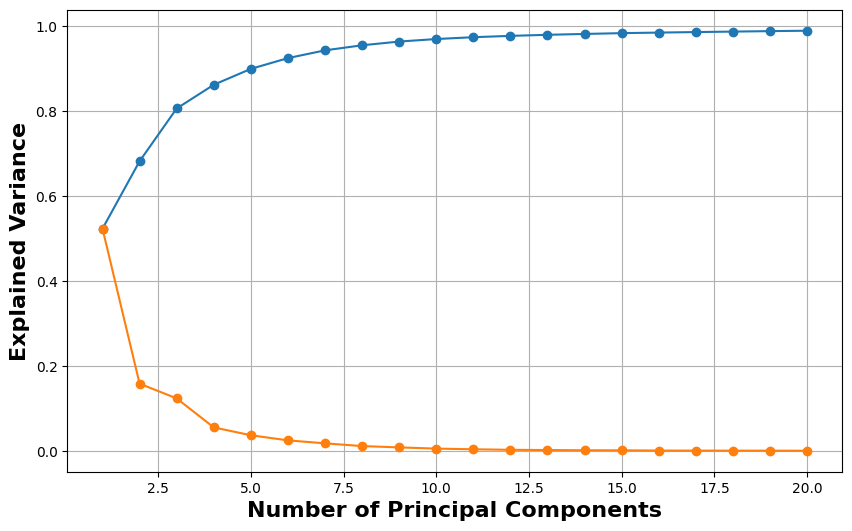

The best number of components that explain at least 90% of the variance: 5
Combined variance of the 5 components: 90.01%
Explained variance ratio of the 5 components: [0.52382386 0.15880886 0.12417023 0.05586654 0.03741597 0.02534047
 0.01832213 0.01187996 0.00880421 0.00593671 0.00433248 0.00309935
 0.00253206 0.00201114 0.00189175 0.00132006 0.00120532 0.00113665
 0.00108927 0.00095545]


In [22]:
explained_variance_ratios = []
cumulative_variance = []

for n in range(1, 21):
    pca = PCA(n_components=n)
    pca.fit(df_known_train_feats)
    explained_variance_ratios.append(pca.explained_variance_ratio_)
    cumulative_variance.append(np.cumsum(pca.explained_variance_ratio_))

explained_variance_df = pd.DataFrame(explained_variance_ratios, columns=[f'PC{i+1}' for i in range(20)])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=[f'PC{i+1}' for i in range(20)])

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 21), cumulative_variance_df.iloc[-1, :], marker='o', label='cumulative')
plt.plot(np.arange(1, 21), explained_variance_df.iloc[-1, :], marker='o', label='individual')
plt.xlabel('Number of Principal Components', fontsize=16, fontweight='bold')
plt.ylabel('Explained Variance', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()

for i, cum_variance in enumerate(cumulative_variance_df.iloc[-1, :]):
    if cum_variance >= 0.9:
        best_n_components = i + 1
        break

print(f"The best number of components that explain at least 90% of the variance: {best_n_components}")
print(f"Combined variance of the {best_n_components} components: {explained_variance_df.iloc[-1, :][:best_n_components].sum() * 100:.2f}%")
print(f"Explained variance ratio of the {best_n_components} components: {pca.explained_variance_ratio_}")

In [23]:
# We now perform PCA with the selected best n_components
pca = PCA(n_components=best_n_components)
X_train_pca = pca.fit_transform(df_known_train_feats)
X_test_pca = pca.transform(df_orphan_test_feats)

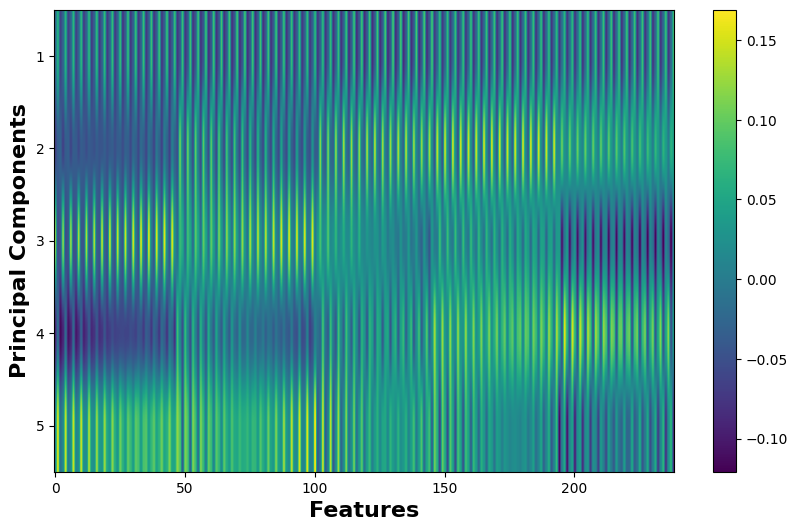

In [24]:
plt.figure(figsize=(10, 6))
plt.imshow(pca.components_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.ylabel('Principal Components', fontsize=16, fontweight='bold')
plt.yticks(ticks=range(best_n_components), labels=[str(i) for i in range(1, best_n_components+1)])
plt.xlabel('Features', fontsize=16, fontweight='bold')
plt.show()

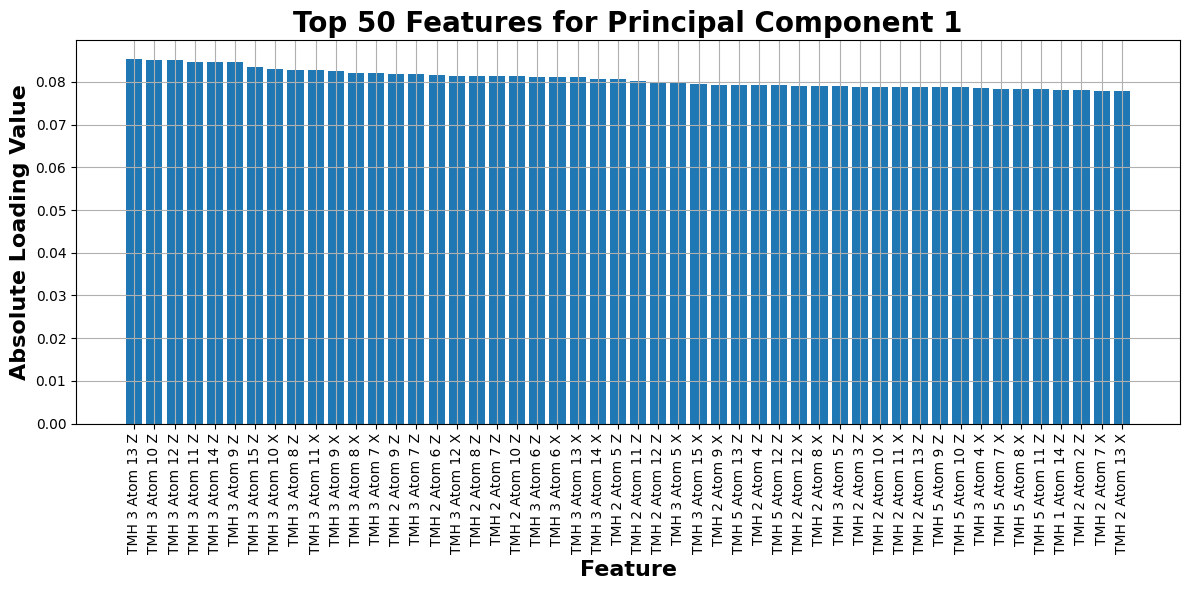

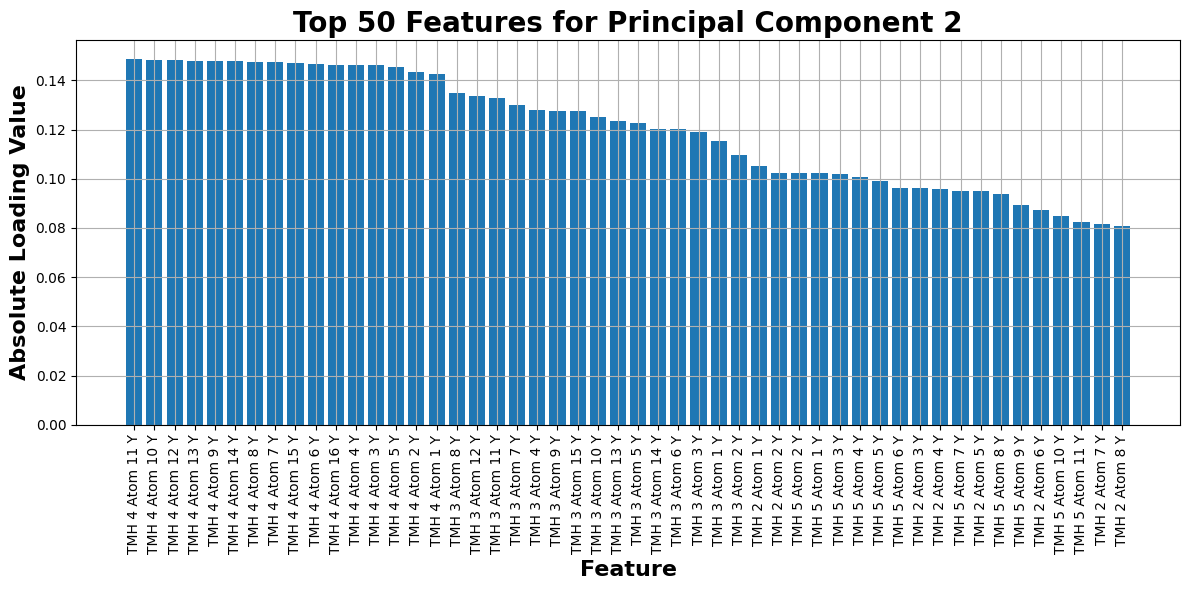

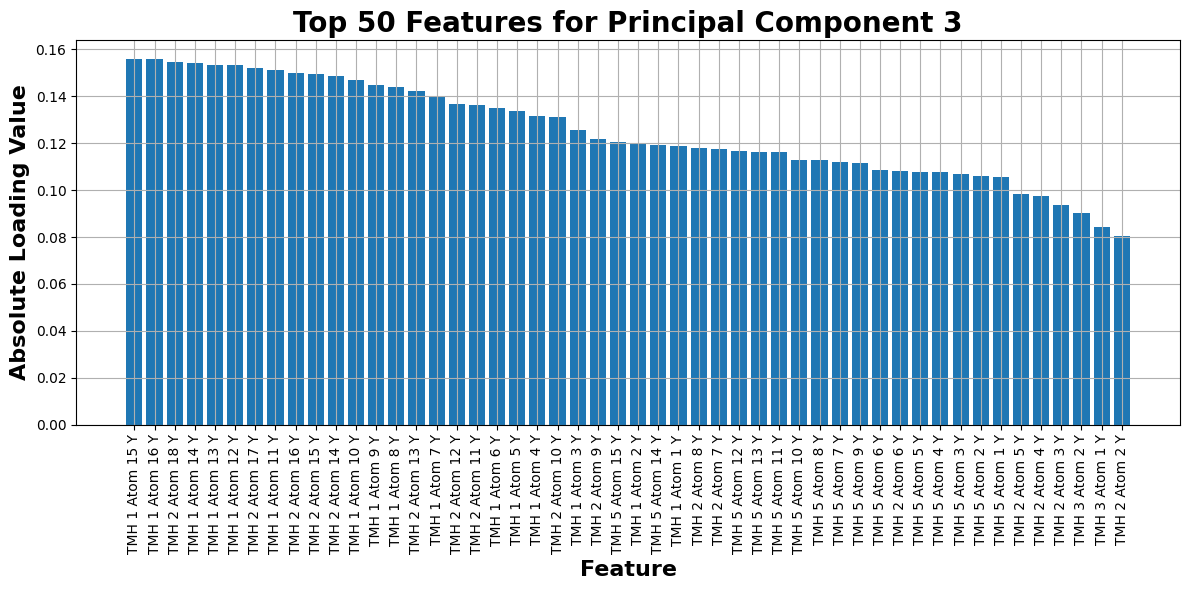

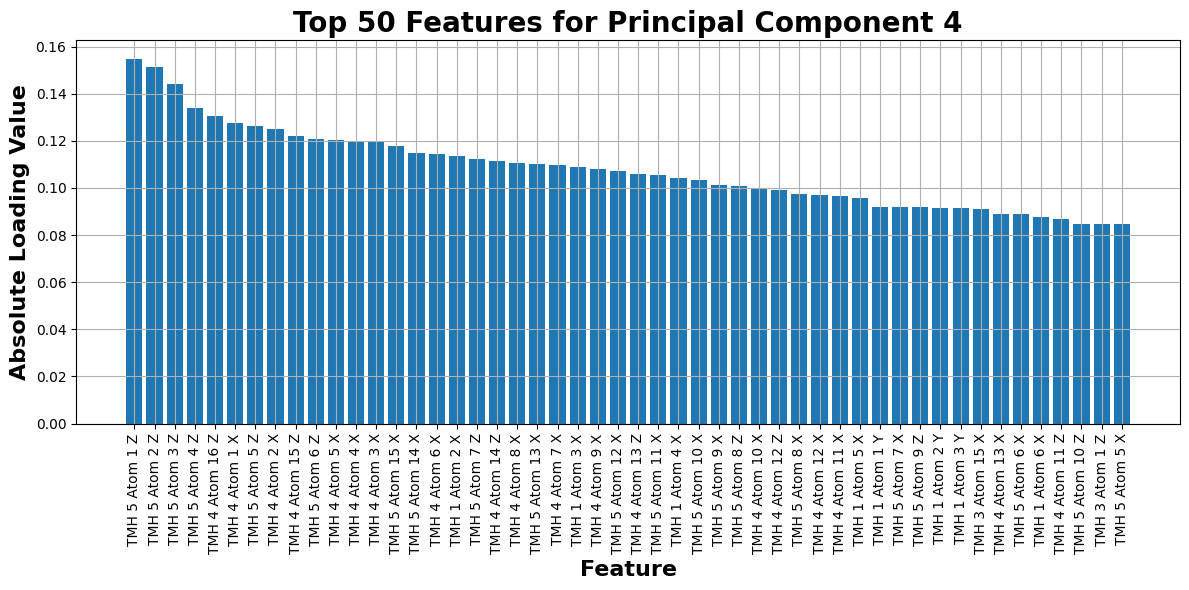

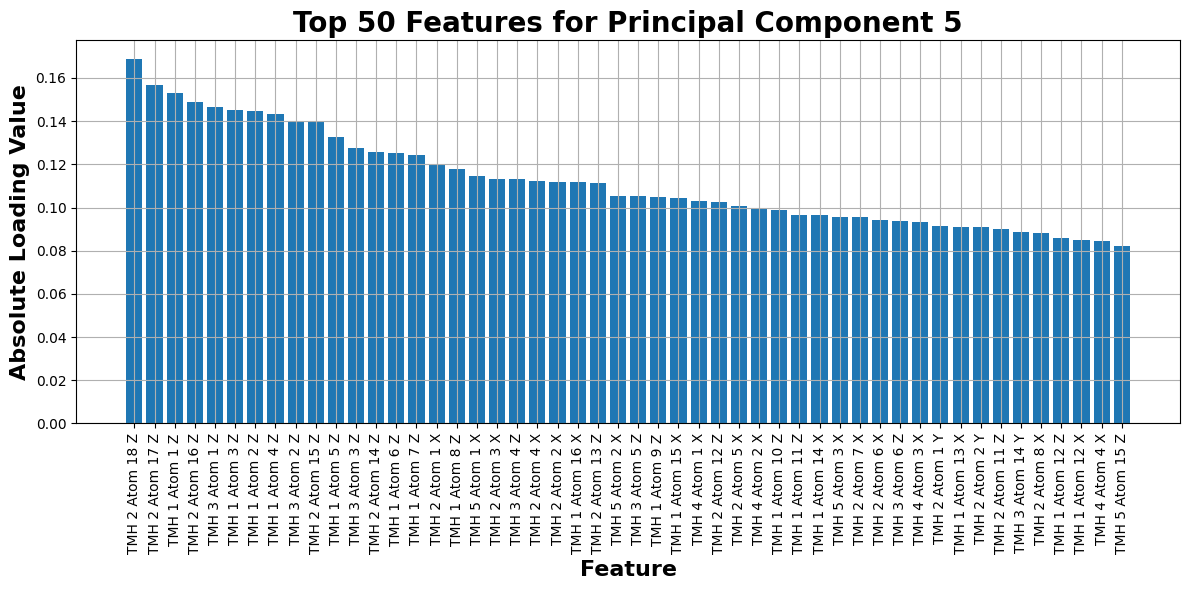

In [25]:
top_n = 50
feature_names = df_known_train_feats.columns

abs_loadings = np.abs(pca.components_)

# For each factor, select the top N features based on their absolute loadings
for i in range(pca.components_.shape[0]):
    top_indices = np.argsort(abs_loadings[i])[::-1][:top_n]
    
    if len(top_indices) > 0:
        plt.figure(figsize=(12, 6))
    
        top_feature_names = feature_names[top_indices]
        
        plt.bar(top_feature_names, abs_loadings[i, top_indices])
        
        plt.title(f"Top {top_n} Features for Principal Component {i+1}", fontsize=20, fontweight='bold')
        plt.xlabel("Feature", fontsize=16, fontweight='bold')
        plt.ylabel("Absolute Loading Value", fontsize=16, fontweight='bold')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No top {top_n} features for Factor {i+1}")

In [26]:
top_features_dict = {f"PC{i+1}": [] for i in range(pca.components_.shape[0])}

# For each factor, select the top N features based on their absolute loadings
for i in range(pca.components_.shape[0]):
    top_indices = np.argsort(abs_loadings[i])[::-1][:top_n]
    
    top_feature_names = feature_names[top_indices]
    top_loading_values = abs_loadings[i, top_indices]
    
    top_features_dict[f"PC{i+1}"] = list(zip(top_feature_names, top_loading_values))

top_features_df = pd.DataFrame(top_features_dict)
top_features_expanded = {}
for pc in range(pca.components_.shape[0]):
    top_features_expanded[f"PC{pc+1}"] = [f"{feature}: {loading:5f}" for feature, loading in top_features_dict[f"PC{pc+1}"]]

top_features_final_df = pd.DataFrame(top_features_expanded)
top_features_final_df.index = [f"Feature {i+1}" for i in range(top_n)]
top_features_final_df

PC1                        PC2  \
Feature 1   TMH 3 Atom 13 Z: 0.085482  TMH 4 Atom 11 Y: 0.148815   
Feature 2   TMH 3 Atom 10 Z: 0.085231  TMH 4 Atom 10 Y: 0.148291   
Feature 3   TMH 3 Atom 12 Z: 0.085044  TMH 4 Atom 12 Y: 0.148105   
Feature 4   TMH 3 Atom 11 Z: 0.084714  TMH 4 Atom 13 Y: 0.147939   
Feature 5   TMH 3 Atom 14 Z: 0.084605   TMH 4 Atom 9 Y: 0.147739   
Feature 6    TMH 3 Atom 9 Z: 0.084574  TMH 4 Atom 14 Y: 0.147700   
Feature 7   TMH 3 Atom 15 Z: 0.083444   TMH 4 Atom 8 Y: 0.147647   
Feature 8   TMH 3 Atom 10 X: 0.083035   TMH 4 Atom 7 Y: 0.147394   
Feature 9    TMH 3 Atom 8 Z: 0.082752  TMH 4 Atom 15 Y: 0.147210   
Feature 10  TMH 3 Atom 11 X: 0.082696   TMH 4 Atom 6 Y: 0.146437   
Feature 11   TMH 3 Atom 9 X: 0.082470  TMH 4 Atom 16 Y: 0.146356   
Feature 12   TMH 3 Atom 8 X: 0.082204   TMH 4 Atom 4 Y: 0.146138   
Feature 13   TMH 3 Atom 7 X: 0.082149   TMH 4 Atom 3 Y: 0.146080   
Feature 14   TMH 2 Atom 9 Z: 0.081948   TMH 4 Atom 5 Y: 0.145393   
Feature 15   TMH 3 Atom 7 Z: 0.081878   TMH 4 Atom 2 Y: 0.143381   
Feature 16   TMH 2 Atom 6 Z: 0.081679   TMH 4 Atom 1 Y: 0.142695   
Feature 17  TMH 3 Atom 12 X: 0.081496   TMH 3 Atom 8 Y: 0.134644   
Feature 18   TMH 2 Atom 8 Z: 0.081339  TMH 3 Atom 12 Y: 0.133813   
Feature 19   TMH 2 Atom 7 Z: 0.081329  TMH 3 Atom 11 Y: 0.132860   
Feature 20  TMH 2 Atom 10 Z: 0.081288   TMH 3 Atom 7 Y: 0.129809   
Feature 21   TMH 3 Atom 6 Z: 0.081240   TMH 3 Atom 4 Y: 0.127777   
Feature 22   TMH 3 Atom 6 X: 0.081106   TMH 3 Atom 9 Y: 0.127356   
Feature 23  TMH 3 Atom 13 X: 0.081056  TMH 3 Atom 15 Y: 0.127345   
Feature 24  TMH 3 Atom 14 X: 0.080775  TMH 3 Atom 10 Y: 0.125071   
Feature 25   TMH 2 Atom 5 Z: 0.080670  TMH 3 Atom 13 Y: 0.123535   
Feature 26  TMH 2 Atom 11 Z: 0.080131   TMH 3 Atom 5 Y: 0.122815   
Feature 27  TMH 2 Atom 12 Z: 0.079848  TMH 3 Atom 14 Y: 0.120325   
Feature 28   TMH 3 Atom 5 X: 0.079793   TMH 3 Atom 6 Y: 0.120294   
Feature 29  TMH 3 Atom 15 X: 0.079515   TMH 3 Atom 3 Y: 0.118883   
Feature 30   TMH 2 Atom 9 X: 0.079382   TMH 3 Atom 1 Y: 0.115135   
Feature 31  TMH 5 Atom 13 Z: 0.079368   TMH 3 Atom 2 Y: 0.109843   
Feature 32   TMH 2 Atom 4 Z: 0.079265   TMH 2 Atom 1 Y: 0.105052   
Feature 33  TMH 5 Atom 12 Z: 0.079197   TMH 2 Atom 2 Y: 0.102467   
Feature 34  TMH 2 Atom 12 X: 0.079059   TMH 5 Atom 2 Y: 0.102367   
Feature 35   TMH 2 Atom 8 X: 0.079032   TMH 5 Atom 1 Y: 0.102130   
Feature 36   TMH 3 Atom 5 Z: 0.078976   TMH 5 Atom 3 Y: 0.101936   
Feature 37   TMH 2 Atom 3 Z: 0.078908   TMH 5 Atom 4 Y: 0.100533   
Feature 38  TMH 2 Atom 10 X: 0.078865   TMH 5 Atom 5 Y: 0.098929   
Feature 39  TMH 2 Atom 11 X: 0.078864   TMH 5 Atom 6 Y: 0.096325   
Feature 40  TMH 2 Atom 13 Z: 0.078828   TMH 2 Atom 3 Y: 0.096154   
Feature 41   TMH 5 Atom 9 Z: 0.078786   TMH 2 Atom 4 Y: 0.095660   
Feature 42  TMH 5 Atom 10 Z: 0.078771   TMH 5 Atom 7 Y: 0.094901   
Feature 43   TMH 3 Atom 4 X: 0.078540   TMH 2 Atom 5 Y: 0.094829   
Feature 44   TMH 5 Atom 7 X: 0.078445   TMH 5 Atom 8 Y: 0.093778   
Feature 45   TMH 5 Atom 8 X: 0.078340   TMH 5 Atom 9 Y: 0.089319   
Feature 46  TMH 5 Atom 11 Z: 0.078282   TMH 2 Atom 6 Y: 0.087287   
Feature 47  TMH 1 Atom 14 Z: 0.078139  TMH 5 Atom 10 Y: 0.084798   
Feature 48   TMH 2 Atom 2 Z: 0.078038  TMH 5 Atom 11 Y: 0.082426   
Feature 49   TMH 2 Atom 7 X: 0.078003   TMH 2 Atom 7 Y: 0.081740   
Feature 50  TMH 2 Atom 13 X: 0.077930   TMH 2 Atom 8 Y: 0.080977   

                                  PC3                        PC4  \
Feature 1   TMH 1 Atom 15 Y: 0.156104   TMH 5 Atom 1 Z: 0.154911   
Feature 2   TMH 1 Atom 16 Y: 0.156018   TMH 5 Atom 2 Z: 0.151494   
Feature 3   TMH 2 Atom 18 Y: 0.154725   TMH 5 Atom 3 Z: 0.144257   
Feature 4   TMH 1 Atom 14 Y: 0.154071   TMH 5 Atom 4 Z: 0.133855   
Feature 5   TMH 1 Atom 13 Y: 0.153319  TMH 4 Atom 16 Z: 0.130418   
Feature 6   TMH 1 Atom 12 Y: 0.153298   TMH 4 Atom 1 X: 0.127770   
Feature 7   TMH 2 Atom 17 Y: 0.152293   TMH 5 Atom 5 Z: 0.126249   
Feature 8   TMH 1 Ato

# Factor Analysis

## On the original features

In [27]:
fa = FactorAnalysis(n_components=best_n_components)
X_train_fa = fa.fit_transform(df_known_train_feats)
X_test_fa = fa.transform(df_orphan_test_feats)

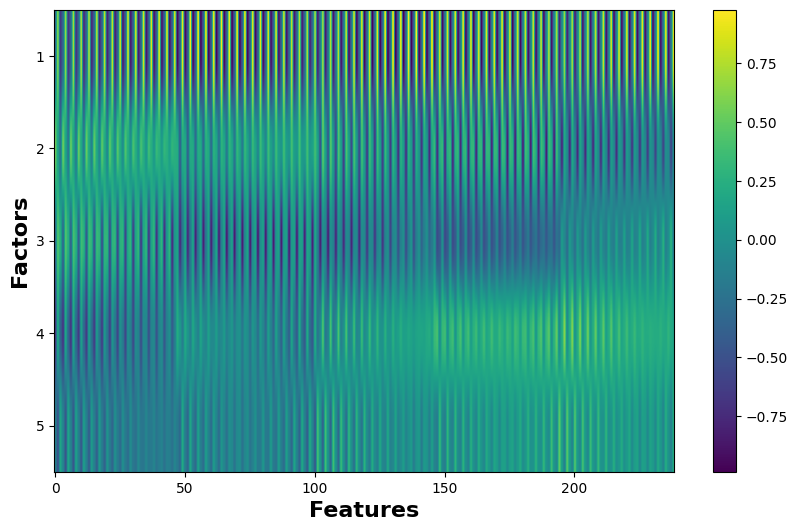

In [28]:
plt.figure(figsize=(10, 6))
plt.imshow(fa.components_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.ylabel('Factors', fontsize=16, fontweight='bold')
plt.yticks(ticks=range(best_n_components), labels=[str(i) for i in range(1, best_n_components+1)])
plt.xlabel('Features', fontsize=16, fontweight='bold')
plt.show()

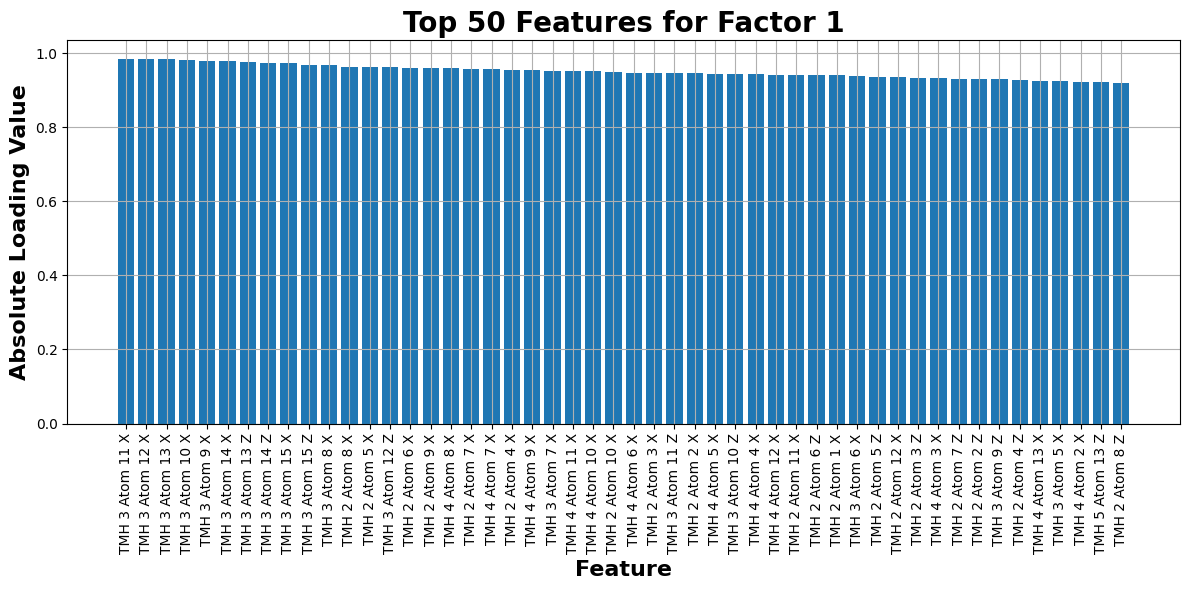

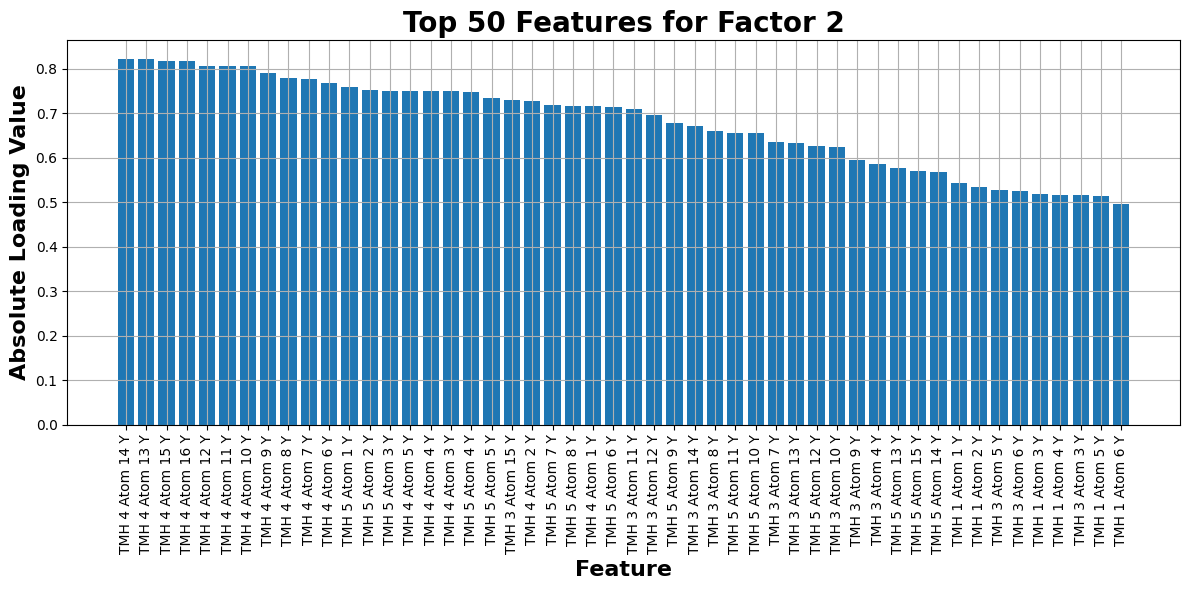

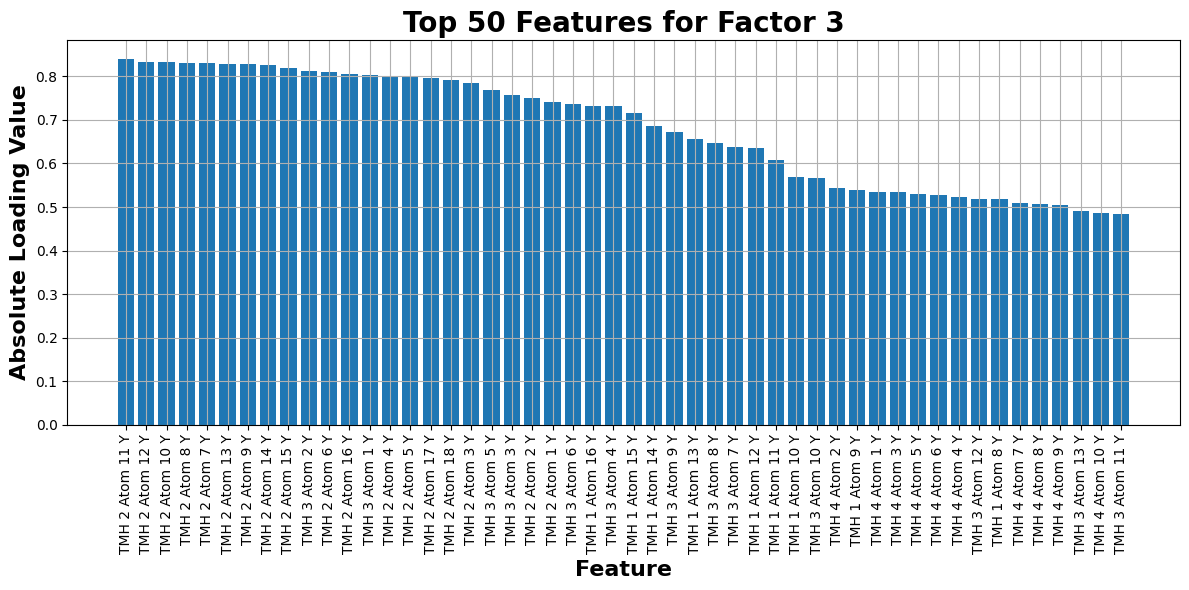

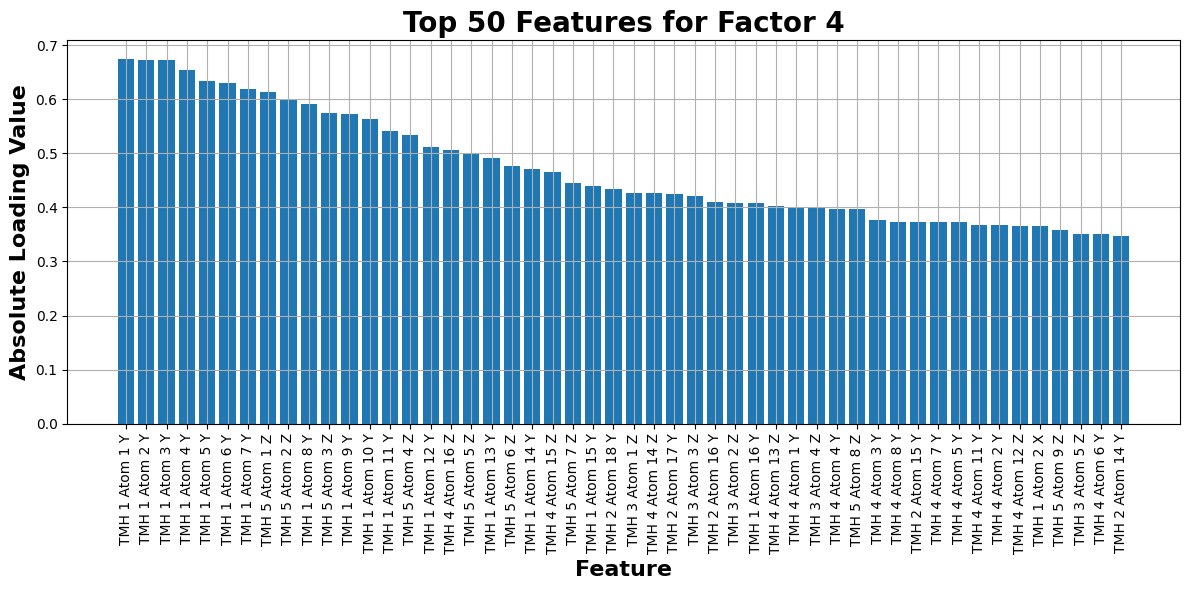

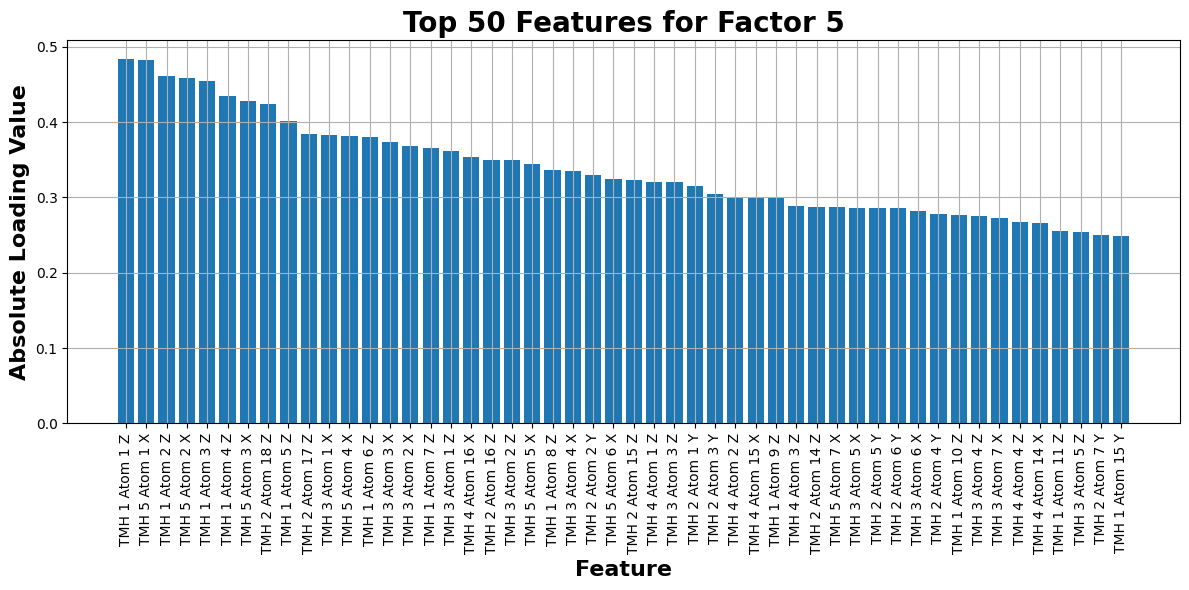

In [29]:
top_n = 50
feature_names = df_known_train_feats.columns

abs_loadings_fa = np.abs(fa.components_)

# For each factor, select the top N features based on their absolute loadings
for i in range(fa.components_.shape[0]):
    top_indices = np.argsort(abs_loadings_fa[i])[::-1][:top_n]
    
    if len(top_indices) > 0:
        plt.figure(figsize=(12, 6))
        
        top_feature_names = feature_names[top_indices]
        
        plt.bar(top_feature_names, abs_loadings_fa[i, top_indices])
        
        plt.title(f"Top {top_n} Features for Factor {i+1}", fontsize=20, fontweight='bold')
        plt.xlabel("Feature", fontsize=16, fontweight='bold')
        plt.ylabel("Absolute Loading Value", fontsize=16, fontweight='bold')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No top {top_n} features for Factor {i+1}")

In [30]:
top_features_dict_fa = {f"Factor{i+1}": [] for i in range(fa.components_.shape[0])}

# For each factor, select the top N features based on their absolute loadings
for i in range(fa.components_.shape[0]):
    top_indices = np.argsort(abs_loadings_fa[i])[::-1][:top_n]
    
    top_feature_names = feature_names[top_indices]
    top_loading_values = abs_loadings_fa[i, top_indices]
    
    top_features_dict_fa[f"Factor{i+1}"] = list(zip(top_feature_names, top_loading_values))

top_features_df_fa = pd.DataFrame(top_features_dict_fa)
top_features_expanded_fa = {}
for fa in range(fa.components_.shape[0]):
    top_features_expanded_fa[f"Factor{fa+1}"] = [f"{feature}: {loading:5f}" for feature, loading in top_features_dict_fa[f"Factor{fa+1}"]]

top_features_final_df_fa = pd.DataFrame(top_features_expanded_fa)
top_features_final_df_fa.index = [f"Feature {i+1}" for i in range(top_n)]
top_features_final_df_fa

Factor1                    Factor2  \
Feature 1   TMH 3 Atom 11 X: 0.985026  TMH 4 Atom 14 Y: 0.822247   
Feature 2   TMH 3 Atom 12 X: 0.984446  TMH 4 Atom 13 Y: 0.820848   
Feature 3   TMH 3 Atom 13 X: 0.982677  TMH 4 Atom 15 Y: 0.817047   
Feature 4   TMH 3 Atom 10 X: 0.982205  TMH 4 Atom 16 Y: 0.816014   
Feature 5    TMH 3 Atom 9 X: 0.978800  TMH 4 Atom 12 Y: 0.806573   
Feature 6   TMH 3 Atom 14 X: 0.978115  TMH 4 Atom 11 Y: 0.805396   
Feature 7   TMH 3 Atom 13 Z: 0.976401  TMH 4 Atom 10 Y: 0.804985   
Feature 8   TMH 3 Atom 14 Z: 0.973979   TMH 4 Atom 9 Y: 0.790712   
Feature 9   TMH 3 Atom 15 X: 0.972652   TMH 4 Atom 8 Y: 0.778272   
Feature 10  TMH 3 Atom 15 Z: 0.968366   TMH 4 Atom 7 Y: 0.776963   
Feature 11   TMH 3 Atom 8 X: 0.968127   TMH 4 Atom 6 Y: 0.766492   
Feature 12   TMH 2 Atom 8 X: 0.962550   TMH 5 Atom 1 Y: 0.758724   
Feature 13   TMH 2 Atom 5 X: 0.961385   TMH 5 Atom 2 Y: 0.752096   
Feature 14  TMH 3 Atom 12 Z: 0.961039   TMH 5 Atom 3 Y: 0.750099   
Feature 15   TMH 2 Atom 6 X: 0.959287   TMH 4 Atom 5 Y: 0.750095   
Feature 16   TMH 2 Atom 9 X: 0.958910   TMH 4 Atom 4 Y: 0.749877   
Feature 17   TMH 4 Atom 8 X: 0.958314   TMH 4 Atom 3 Y: 0.749101   
Feature 18   TMH 2 Atom 7 X: 0.958003   TMH 5 Atom 4 Y: 0.747826   
Feature 19   TMH 4 Atom 7 X: 0.956067   TMH 5 Atom 5 Y: 0.733710   
Feature 20   TMH 2 Atom 4 X: 0.955013  TMH 3 Atom 15 Y: 0.730420   
Feature 21   TMH 4 Atom 9 X: 0.952872   TMH 4 Atom 2 Y: 0.726218   
Feature 22   TMH 3 Atom 7 X: 0.951924   TMH 5 Atom 7 Y: 0.717291   
Feature 23  TMH 4 Atom 11 X: 0.950939   TMH 5 Atom 8 Y: 0.715635   
Feature 24  TMH 4 Atom 10 X: 0.950789   TMH 4 Atom 1 Y: 0.715627   
Feature 25  TMH 2 Atom 10 X: 0.948016   TMH 5 Atom 6 Y: 0.713447   
Feature 26   TMH 4 Atom 6 X: 0.947357  TMH 3 Atom 11 Y: 0.709985   
Feature 27   TMH 2 Atom 3 X: 0.946527  TMH 3 Atom 12 Y: 0.695876   
Feature 28  TMH 3 Atom 11 Z: 0.946208   TMH 5 Atom 9 Y: 0.678663   
Feature 29   TMH 2 Atom 2 X: 0.945326  TMH 3 Atom 14 Y: 0.669854   
Feature 30   TMH 4 Atom 5 X: 0.943938   TMH 3 Atom 8 Y: 0.659184   
Feature 31  TMH 3 Atom 10 Z: 0.943653  TMH 5 Atom 11 Y: 0.655487   
Feature 32   TMH 4 Atom 4 X: 0.942082  TMH 5 Atom 10 Y: 0.654312   
Feature 33  TMH 4 Atom 12 X: 0.941846   TMH 3 Atom 7 Y: 0.635485   
Feature 34  TMH 2 Atom 11 X: 0.941844  TMH 3 Atom 13 Y: 0.633785   
Feature 35   TMH 2 Atom 6 Z: 0.940430  TMH 5 Atom 12 Y: 0.625818   
Feature 36   TMH 2 Atom 1 X: 0.939530  TMH 3 Atom 10 Y: 0.623058   
Feature 37   TMH 3 Atom 6 X: 0.937134   TMH 3 Atom 9 Y: 0.593929   
Feature 38   TMH 2 Atom 5 Z: 0.936037   TMH 3 Atom 4 Y: 0.584492   
Feature 39  TMH 2 Atom 12 X: 0.934305  TMH 5 Atom 13 Y: 0.576334   
Feature 40   TMH 2 Atom 3 Z: 0.932511  TMH 5 Atom 15 Y: 0.569888   
Feature 41   TMH 4 Atom 3 X: 0.931844  TMH 5 Atom 14 Y: 0.567851   
Feature 42   TMH 2 Atom 7 Z: 0.928823   TMH 1 Atom 1 Y: 0.544012   
Feature 43   TMH 2 Atom 2 Z: 0.928821   TMH 1 Atom 2 Y: 0.533926   
Feature 44   TMH 3 Atom 9 Z: 0.928805   TMH 3 Atom 5 Y: 0.527257   
Feature 45   TMH 2 Atom 4 Z: 0.928337   TMH 3 Atom 6 Y: 0.525443   
Feature 46  TMH 4 Atom 13 X: 0.925160   TMH 1 Atom 3 Y: 0.519206   
Feature 47   TMH 3 Atom 5 X: 0.924884   TMH 1 Atom 4 Y: 0.516873   
Feature 48   TMH 4 Atom 2 X: 0.922163   TMH 3 Atom 3 Y: 0.515420   
Feature 49  TMH 5 Atom 13 Z: 0.920989   TMH 1 Atom 5 Y: 0.513952   
Feature 50   TMH 2 Atom 8 Z: 0.918701   TMH 1 Atom 6 Y: 0.494680   

                              Factor3                    Factor4  \
Feature 1   TMH 2 Atom 11 Y: 0.840926   TMH 1 Atom 1 Y: 0.675525   
Feature 2   TMH 2 Atom 12 Y: 0.833365   TMH 1 Atom 2 Y: 0.672978   
Feature 3   TMH 2 Atom 10 Y: 0.832575   TMH 1 Atom 3 Y: 0.672782   
Feature 4    TMH 2 Atom 8 Y: 0.831775   TMH 1 Atom 4 Y: 0.653675   
Feature 5    TMH 2 Atom 7 Y: 0.830829   TMH 1 Atom 5 Y: 0.633842   
Feature 6   TMH 2 Atom 13 Y: 0.828389   TMH 1 Atom 6 Y: 0.630112   
Feature 7    TMH 2 Atom 9 Y: 0.828270   TMH 1 Atom 7 Y: 0.618625   
Feature 8   TMH 2

## On the Principal Components

In [31]:
fa_pca = FactorAnalysis(n_components=best_n_components)
fa_pca_result = fa_pca.fit_transform(X_train_pca)

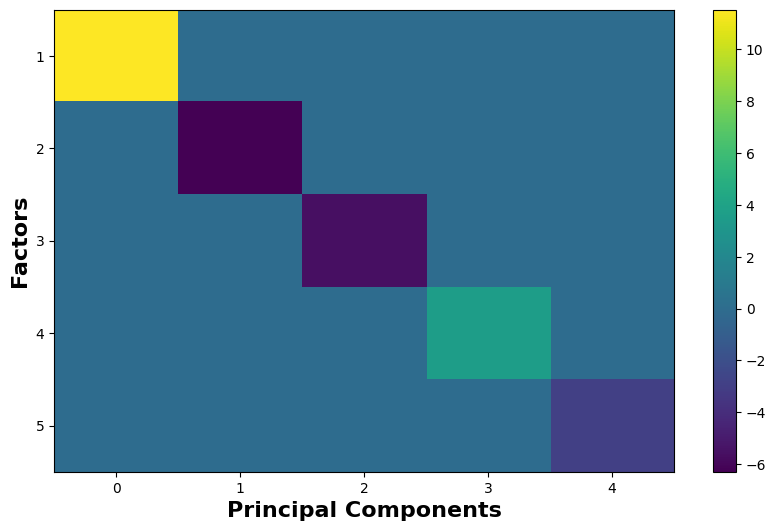

In [32]:
plt.figure(figsize=(10, 6))
plt.imshow(fa_pca.components_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.ylabel('Factors', fontsize=16, fontweight='bold')
plt.yticks(ticks=range(best_n_components), labels=[str(i) for i in range(1, best_n_components+1)])
plt.xlabel('Principal Components', fontsize=16, fontweight='bold')
plt.show()

# Supervised Learning

In [33]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score
# import warnings
# from warnings import simplefilter
# from sklearn.exceptions import ConvergenceWarning
# from sklearn.exceptions import DataConversionWarning

# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=DataConversionWarning)

## Using original features

In [34]:
# y_df = final_targets_df['Class'].ravel()
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_df)
# X_features = final_features_df

# X_train_val, X_test, y_train_val, y_test = X_features[:-100], X_features[-100:], y_encoded[:-100], y_encoded[-100:]
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.4, random_state=42)

In [35]:
# # Define models and parameter grids
# models = {
#     'XGBoost': XGBClassifier(),
#     'Gradient Boosting': GradientBoostingClassifier(),
#     'Random Forest': RandomForestClassifier()
# }

# param_grids = {
#     'XGBoost': {
#         'n_estimators': [10, 25, 50, 75, 100],
#         'max_depth': [3, 6, 10],
#         'learning_rate': [0.01, 0.1, 0.2, 0.5]
#     },
#     'Gradient Boosting': {
#         'n_estimators': [10, 25, 50, 75, 100],
#         'learning_rate': [0.01, 0.1, 0.2, 0.5],
#         'max_depth': [3, 6, 10]
#     },
#     'Random Forest': {
#         'n_estimators': [10, 25, 50, 75, 100],
#         'max_depth': [3, 6, 10],
#         'min_samples_split': [2, 5, 10]
#     }
# }

In [36]:
# # GridSearchCV for each model
# supervised_learning_models = pd.DataFrame()
# result = {}

# for model_name in models:
#     start_time = time.time()
#     grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=3, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')
#     grid_search.fit(X_train, y_train)
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
#     run_time = time.time() - start_time

#     train_score = best_model.score(X_train, y_train)
#     val_score = best_model.score(X_val, y_val)
#     test_score = best_model.score(X_test, y_test)

#     train_wt = 0.1
#     valid_wt = 0.4
#     test_wt = 0.5

#     weighted_accuracy = train_wt*train_score + valid_wt*val_score + test_wt*test_score

#     result = pd.DataFrame({
#         'Model': [model_name],
#         'Training Accuracy': [train_score],
#         'Validation Accuracy': [val_score],
#         'Test Accuracy': [test_score],
#         'Weighted Accuracy': [weighted_accuracy],
#         'Best Parameters': [best_params],
#         'Run Time': [run_time]
#     })
#     supervised_learning_models = pd.concat([supervised_learning_models, result], ignore_index=True)

In [37]:
# supervised_learning_models

In [38]:
# model = 'Random Forest' # based on the best model in the table

# grid_search = GridSearchCV(models[model], param_grids[model], cv=3, n_jobs=-1, scoring='accuracy', return_train_score=True)
# grid_search.fit(X_train, y_train)
# best_rf = grid_search.best_estimator_
# importances = best_rf.feature_importances_
# feature_names = X_features.columns

# sorted_indices = np.argsort(importances)[::-1]
# sorted_features = [feature_names[i] for i in sorted_indices]
# sorted_importances = [importances[i] for i in sorted_indices]

# plt.figure(figsize=(10, 6))
# plt.barh(sorted_features[:10], sorted_importances[:10], color='blue')
# plt.xlabel('Feature Importance', fontsize=16, fontweight='bold')
# plt.gca().invert_yaxis()
# plt.show()

## Using Principal Components

In [39]:
# X_features_pca = pca_result

# X_train_val_pca, X_test_pca, y_train_val_pca, y_test_pca = X_features_pca[:-100], X_features_pca[-100:], y_encoded[:-100], y_encoded[-100:]
# X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_val_pca, y_train_val_pca, test_size=0.4, random_state=42)

In [40]:
# # GridSearchCV for each model
# supervised_learning_models_pca = pd.DataFrame()
# result = {}

# for model_name in models:
#     start_time = time.time()
#     grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=3, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')
#     grid_search.fit(X_train_pca, y_train_pca)
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
#     run_time = time.time() - start_time

#     train_score = best_model.score(X_train_pca, y_train_pca)
#     val_score = best_model.score(X_val_pca, y_val_pca)
#     test_score = best_model.score(X_test_pca, y_test_pca)

#     train_wt = 0.1
#     valid_wt = 0.4
#     test_wt = 0.5

#     weighted_accuracy = train_wt*train_score + valid_wt*val_score + test_wt*test_score

#     result = pd.DataFrame({
#         'Model': [model_name],
#         'Training Accuracy': [train_score],
#         'Validation Accuracy': [val_score],
#         'Test Accuracy': [test_score],
#         'Weighted Accuracy': [weighted_accuracy],
#         'Best Parameters': [best_params],
#         'Run Time': [run_time]
#     })
#     supervised_learning_models_pca = pd.concat([supervised_learning_models_pca, result], ignore_index=True)

In [41]:
# supervised_learning_models_pca

In [42]:
# model = 'XGBoost' # based on the best model in the table

# grid_search = GridSearchCV(models[model], param_grids[model], cv=3, n_jobs=-1, scoring='accuracy', return_train_score=True)
# grid_search.fit(X_train_pca, y_train_pca)
# best_rf = grid_search.best_estimator_
# importances = best_rf.feature_importances_
# feature_names = [f'Principal Component {i}' for i in range(1, 8)]

# sorted_indices = np.argsort(importances)[::-1]
# sorted_features = [feature_names[i] for i in sorted_indices]
# sorted_importances = [importances[i] for i in sorted_indices]

# plt.figure(figsize=(10, 6))
# plt.barh(sorted_features, sorted_importances, color='blue')
# plt.xlabel('Feature Importance', fontsize=16, fontweight='bold')
# plt.gca().invert_yaxis()
# plt.show()

## Using Factors

In [43]:
# X_features_fa = fa_result

# X_train_val_fa, X_test_fa, y_train_val_fa, y_test_fa = X_features_fa[:-100], X_features_fa[-100:], y_encoded[:-100], y_encoded[-100:]
# X_train_fa, X_val_fa, y_train_fa, y_val_fa = train_test_split(X_train_val_fa, y_train_val_fa, test_size=0.4, random_state=42)

In [44]:
# # GridSearchCV for each model
# supervised_learning_models_fa = pd.DataFrame()
# result = {}

# for model_name in models:
#     start_time = time.time()
#     grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=3, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')
#     grid_search.fit(X_train_fa, y_train_fa)
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
#     run_time = time.time() - start_time

#     train_score = best_model.score(X_train_fa, y_train_fa)
#     val_score = best_model.score(X_val_fa, y_val_fa)
#     test_score = best_model.score(X_test_fa, y_test_fa)

#     train_wt = 0.1
#     valid_wt = 0.4
#     test_wt = 0.5

#     weighted_accuracy = train_wt*train_score + valid_wt*val_score + test_wt*test_score

#     result = pd.DataFrame({
#         'Model': [model_name],
#         'Training Accuracy': [train_score],
#         'Validation Accuracy': [val_score],
#         'Test Accuracy': [test_score],
#         'Weighted Accuracy': [weighted_accuracy],
#         'Best Parameters': [best_params],
#         'Run Time': [run_time]
#     })
#     supervised_learning_models_fa = pd.concat([supervised_learning_models_fa, result], ignore_index=True)

In [45]:
# supervised_learning_models_fa

In [46]:
# model = 'Random Forest' # based on the best model in the table

# grid_search = GridSearchCV(models[model], param_grids[model], cv=3, n_jobs=-1, scoring='accuracy', return_train_score=True)
# grid_search.fit(X_train_fa, y_train_fa)
# best_rf = grid_search.best_estimator_
# importances = best_rf.feature_importances_
# feature_names = [f'Factor {i}' for i in range(1, 8)]

# sorted_indices = np.argsort(importances)[::-1]
# sorted_features = [feature_names[i] for i in sorted_indices]
# sorted_importances = [importances[i] for i in sorted_indices]

# plt.figure(figsize=(10, 6))
# plt.barh(sorted_features, sorted_importances, color='blue')
# plt.xlabel('Feature Importance', fontsize=16, fontweight='bold')
# plt.gca().invert_yaxis()
# plt.show()

# Unsupervised Learning

In [47]:
def find_optimal_clusters(df, max_clusters=10):
    # For KMeans
    kmeans_silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans_clusters = kmeans.fit_predict(df)
        kmeans_silhouette_scores.append(silhouette_score(df, kmeans_clusters))

    optimal_kmeans_clusters = np.argmax(kmeans_silhouette_scores) + 2

    # For Agglomerative Clustering
    agglo_silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        agglo = AgglomerativeClustering(n_clusters=n_clusters)
        agglo_clusters = agglo.fit_predict(df)
        agglo_silhouette_scores.append(silhouette_score(df, agglo_clusters))

    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), kmeans_silhouette_scores, marker='o', linestyle='--', color='g', label='KMeans')
    plt.plot(range(2, max_clusters + 1), agglo_silhouette_scores, marker='o', linestyle='--', color='r', label='Agglomerative')
    plt.xlabel("Number of Clusters", fontsize=16, fontweight='bold')
    plt.ylabel("Silhouette Score", fontsize=16, fontweight='bold')
    plt.legend()
    plt.show()

    optimal_agglo_clusters = np.argmax(agglo_silhouette_scores) + 2

    # For DBSCAN
    eps_values = np.arange(0.1, 2.1, 0.1)
    min_samples_values = range(3, 10)
    dbscan_silhouette_scores = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_clusters = dbscan.fit_predict(df)
            
            # Ignore the noise points (labeled as -1 in DBSCAN)
            if len(set(dbscan_clusters)) > 1:
                score = silhouette_score(df, dbscan_clusters)
                dbscan_silhouette_scores.append((eps, min_samples, score))
    
    dbscan_eps_values = [score[0] for score in dbscan_silhouette_scores]
    dbscan_min_samples_values = [score[1] for score in dbscan_silhouette_scores]
    dbscan_scores = [score[2] for score in dbscan_silhouette_scores]
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(dbscan_eps_values, dbscan_min_samples_values, c=dbscan_scores, cmap='viridis')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Silhoutte Score', fontsize=14, fontweight='bold')
    plt.xlabel("eps", fontsize=16, fontweight='bold')
    plt.ylabel("min_samples", fontsize=16, fontweight='bold')
    plt.show()

    best_dbscan_params = max(dbscan_silhouette_scores, key=lambda x: x[2], default=None)

    print(f"Optimal number of clusters for KMeans: {optimal_kmeans_clusters}")
    print(f"Optimal number of clusters for Agglomerative Clustering: {optimal_agglo_clusters}")
    if best_dbscan_params:
        print(f"Optimal DBSCAN parameters: eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}")
    else:
        print("No suitable DBSCAN clustering found.")

    return optimal_kmeans_clusters, optimal_agglo_clusters, best_dbscan_params

In [48]:
# def perform_clustering(df, optimal_kmeans, optimal_hierarchical, optimal_dbscan):
#     kmeans = KMeans(n_clusters=optimal_kmeans)
#     kmeans_clusters = kmeans.fit_predict(df)
    
#     hierarchical = AgglomerativeClustering(n_clusters=optimal_hierarchical)
#     hierarchical_clusters = hierarchical.fit_predict(df)
    
#     dbscan = DBSCAN(eps=optimal_dbscan[0], min_samples=optimal_dbscan[1])
#     dbscan_clusters = dbscan.fit_predict(df)

#     links = sch.linkage(df, method='ward')

#     return kmeans_clusters, hierarchical_clusters, dbscan_clusters, links

In [49]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster import hierarchy as sch
import numpy as np

def fit_and_predict_clusters(X_train, X_test, optimal_kmeans, optimal_hierarchical, optimal_dbscan):
    """
    Fits clustering models to the training data and predicts or fits to the test data.

    Parameters:
    - X_train: Training features.
    - X_test: Test features.
    - optimal_kmeans: Optimal number of clusters for KMeans.
    - optimal_hierarchical: Optimal number of clusters for Hierarchical Clustering.
    - optimal_dbscan: Tuple (eps, min_samples) for DBSCAN.

    Returns:
    - A dictionary with cluster labels and linkage matrices for both training and test datasets.
    """
    results = {}
    
    # KMeans: Fit on training data, predict on both training and test data
    kmeans = KMeans(n_clusters=optimal_kmeans, random_state=42)
    kmeans.fit(X_train)
    results['kmeans_train'] = kmeans.predict(X_train)
    results['kmeans_test'] = kmeans.predict(X_test)

    # Hierarchical Clustering: Fit and produce linkage for dendrogram, then fit_predict
    hierarchical_train = AgglomerativeClustering(n_clusters=optimal_hierarchical)
    results['hierarchical_train'] = hierarchical_train.fit_predict(X_train)
    results['links_train'] = sch.linkage(X_train, method='ward')
    
    hierarchical_test = AgglomerativeClustering(n_clusters=optimal_hierarchical)
    results['hierarchical_test'] = hierarchical_test.fit_predict(X_test)
    results['links_test'] = sch.linkage(X_test, method='ward')
    
    # DBSCAN: Fit and predict independently for training and test datasets
    dbscan_train = DBSCAN(eps=optimal_dbscan[0], min_samples=optimal_dbscan[1])
    results['dbscan_train'] = dbscan_train.fit_predict(X_train)
    
    dbscan_test = DBSCAN(eps=optimal_dbscan[0], min_samples=optimal_dbscan[1])
    results['dbscan_test'] = dbscan_test.fit_predict(X_test)

    return results

In [50]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# # Function to plot clusters
# def plot_clusters(X_train, X_test, y_train_clusters, y_test_clusters, title):
#     """
#     Plots the clusters for training and test datasets with distinct colors and markers.

#     Parameters:
#     - X_train: Training features (2D).
#     - X_test: Test features (2D).
#     - y_train_clusters: Cluster labels for the training data.
#     - y_test_clusters: Cluster labels for the test data.
#     - title: Plot title to distinguish different clustering results.
#     """
#     num_clusters = max(len(np.unique(y_train_clusters)), len(np.unique(y_test_clusters)))
#     colors = plt.cm.get_cmap('viridis', num_clusters)  # Choosing a colormap that scales well

#     plt.figure(figsize=(14, 7))
    
#     # Plot training data
#     plt.subplot(1, 2, 1)
#     scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_clusters, cmap=colors, alpha=0.5, marker='o', label='Training Data')
#     plt.title(title + ' - Training Set')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.colorbar(scatter, label='Cluster ID')
    
#     # Plot test data
#     plt.subplot(1, 2, 2)
#     scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_clusters, cmap=colors, alpha=1, marker='x', label='Test Data')
#     plt.title(title + ' - Test Set')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.colorbar(scatter, label='Cluster ID')
    
#     plt.tight_layout()
#     plt.show()

# # Function to plot dendrogram
# def plot_dendrogram(linkage_matrix, title):
#     plt.figure(figsize=(10, 5))
#     sch.dendrogram(linkage_matrix)
#     plt.title(title)
#     plt.xlabel('Sample index')
#     plt.ylabel('Distance')
#     plt.show()

In [51]:
def plot_and_cluster(df_train, df_test, kmeans_train, hier_train, dbscan_train, links_train, kmeans_test, hier_test, dbscan_test, links_test, label=''):
    print('K-means Clustering')
    # plt.figure(figsize=(10, 7))
    # scatter_train_k = plt.scatter(df_train[:, 0], df_train[:, 1], c=kmeans_train, cmap=colors, alpha=0.3, marker='o', label='Training Data')
    # scatter_test_k = plt.scatter(df_test[:, 0], df_test[:, 1], c=kmeans_test, cmap=colors, alpha=1, marker='x', label='Test Data')
    # plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    # plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    # plt.colorbar(scatter_train_k, label='Cluster ID')
    # plt.show()
    num_clusters_k = max(len(np.unique(kmeans_train)), len(np.unique(kmeans_train)))
    colors_k = plt.cm.get_cmap('viridis', num_clusters_k)
    unique_labels_k = np.unique(kmeans_train)
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.subplot(1, 2, 1)
    scatter_train_k = plt.scatter(df_train[:, 0], df_train[:, 1], c=kmeans_train, cmap=colors_k, alpha=1, marker='o', label='Training Data')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    cbar_train_k = plt.colorbar(scatter_train_k, ticks=np.arange(len(unique_labels_k)))
    cbar_train_k.set_label('Cluster ID', fontsize=14, fontweight='bold')
    cbar_train_k.ax.set_yticklabels([str(label+1) for label in unique_labels_k], fontsize=12, verticalalignment='center')
    
    # Plot test data
    plt.subplot(1, 2, 2)
    scatter_test_k = plt.scatter(df_test[:, 0], df_test[:, 1], c=kmeans_test, cmap=colors_k, alpha=1, marker='x', label='Test Data')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    cbar_test_k = plt.colorbar(scatter_test_k, ticks=np.arange(len(unique_labels_k)))
    cbar_test_k.set_label('Cluster ID', fontsize=14, fontweight='bold')
    cbar_test_k.ax.set_yticklabels([str(label+1) for label in unique_labels_k], fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

    print('Agglomerative Clustering')
    # plt.figure(figsize=(10, 7))
    # scatter_train_h = plt.scatter(df_train[:, 0], df_train[:, 1], c=hier_train, cmap=colors, alpha=0.3, marker='o', label='Training Data')
    # scatter_test_h = plt.scatter(df_test[:, 0], df_test[:, 1], c=hier_test, cmap=colors, alpha=1, marker='x', label='Test Data')
    # plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    # plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    # plt.colorbar(scatter_train_h, label='Cluster ID')
    # plt.show()
    num_clusters_h = max(len(np.unique(hier_train)), len(np.unique(hier_train)))
    colors_h = plt.cm.get_cmap('viridis', num_clusters_h)
    unique_labels_h = np.unique(hier_train)
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.subplot(1, 2, 1)
    scatter_train_h = plt.scatter(df_train[:, 0], df_train[:, 1], c=hier_train, cmap=colors_h, alpha=1, marker='o', label='Training Data')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    cbar_train_h = plt.colorbar(scatter_train_h, ticks=np.arange(len(unique_labels_h)))
    cbar_train_h.set_label('Cluster ID', fontsize=14, fontweight='bold')
    cbar_train_h.ax.set_yticklabels([str(label+1) for label in unique_labels_h], fontsize=12, verticalalignment='center')
    
    # Plot test data
    plt.subplot(1, 2, 2)
    scatter_test_h = plt.scatter(df_test[:, 0], df_test[:, 1], c=hier_test, cmap=colors_h, alpha=1, marker='x', label='Test Data')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    cbar_test_h = plt.colorbar(scatter_test_h, ticks=np.arange(len(unique_labels_h)))
    cbar_test_h.set_label('Cluster ID', fontsize=14, fontweight='bold')
    cbar_test_h.ax.set_yticklabels([str(label+1) for label in unique_labels_h], fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

    print('DBSCAN Clustering')
    # plt.figure(figsize=(10, 7))
    # scatter_train_d = plt.scatter(df_train[:, 0], df_train[:, 1], c=dbscan_train, cmap=colors, alpha=0.3, marker='o', label='Training Data')
    # scatter_test_d = plt.scatter(df_test[:, 0], df_test[:, 1], c=dbscan_test, cmap=colors, alpha=1, marker='x', label='Test Data')
    # plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    # plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    # plt.colorbar(scatter_train_d, label='Cluster ID')
    # plt.show()
    num_clusters_d = max(len(np.unique(dbscan_train)), len(np.unique(dbscan_train)))
    colors_d = plt.cm.get_cmap('viridis', num_clusters_d)
    unique_labels_d = np.unique(dbscan_train)
    plt.figure(figsize=(14, 7))

    # Plot training data
    plt.subplot(1, 2, 1)
    scatter_train_d = plt.scatter(df_train[:, 0], df_train[:, 1], c=dbscan_train, cmap=colors_d, alpha=1, marker='o', label='Training Data')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    cbar_train_d = plt.colorbar(scatter_train_d, ticks=np.arange(len(unique_labels_d)))
    cbar_train_d.set_label('Cluster ID', fontsize=14, fontweight='bold')
    cbar_train_d.ax.set_yticklabels([str(label) for label in unique_labels_d], fontsize=12, verticalalignment='center')
    
    # Plot test data
    plt.subplot(1, 2, 2)
    scatter_test_d = plt.scatter(df_test[:, 0], df_test[:, 1], c=dbscan_test, cmap=colors_d, alpha=1, marker='x', label='Test Data')
    plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
    plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
    cbar_test_d = plt.colorbar(scatter_test_d, ticks=np.arange(len(unique_labels_d)))
    cbar_test_d.set_label('Cluster ID', fontsize=14, fontweight='bold')
    cbar_test_d.ax.set_yticklabels([str(label) for label in unique_labels_d], fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 7))
    sch.dendrogram(links_train)
    plt.xticks([])
    plt.xlabel('Samples', fontsize=16, fontweight='bold')
    plt.ylabel('Distance', fontsize=16, fontweight='bold')
    plt.show()

    plt.figure(figsize=(10, 7))
    sch.dendrogram(links_test)
    plt.xticks([])
    plt.xlabel('Samples', fontsize=16, fontweight='bold')
    plt.ylabel('Distance', fontsize=16, fontweight='bold')
    plt.show()

## Optimal clusters

### Using Principal Components

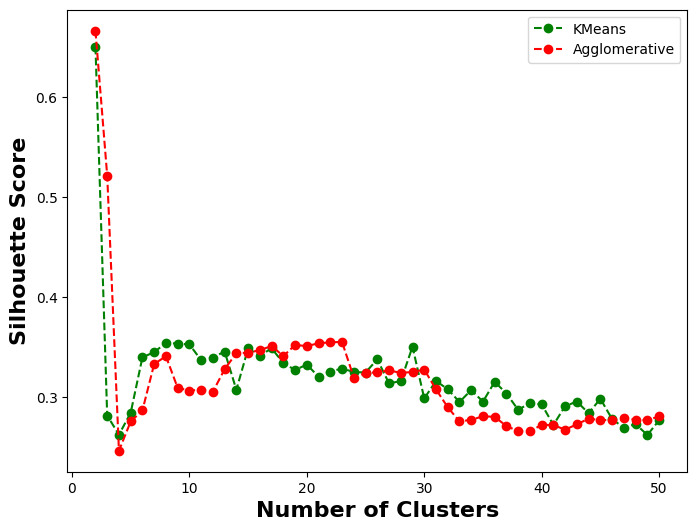

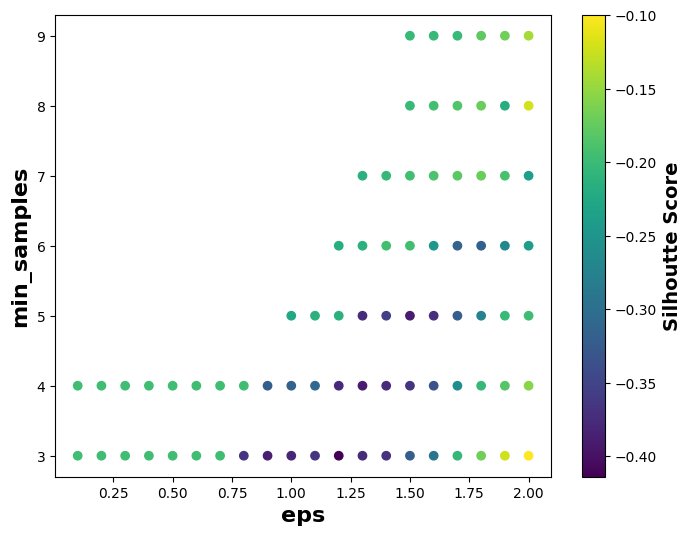

Optimal number of clusters for KMeans: 2
Optimal number of clusters for Agglomerative Clustering: 2
Optimal DBSCAN parameters: eps=2.0, min_samples=3


In [52]:
optimal_kmeans_clusters_pca, optimal_agglo_clusters_pca, best_dbscan_params_pca = find_optimal_clusters(X_train_pca, max_clusters=50)

In [53]:
# kmeans_clusters_pca, agglo_clusters_pca, dbscan_clusters_pca, links_pca = perform_clustering(X_train_pca, optimal_kmeans_clusters_pca, optimal_agglo_clusters_pca, best_dbscan_params_pca)

In [54]:
# plot_and_cluster(X_train_pca, kmeans_clusters_pca, agglo_clusters_pca, dbscan_clusters_pca, links_pca, label='Principal Component')

In [55]:
results_new_pca = fit_and_predict_clusters(X_train_pca, X_test_pca, optimal_kmeans_clusters_pca, optimal_agglo_clusters_pca, best_dbscan_params_pca)

K-means Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_k = plt.cm.get_cmap('viridis', num_clusters_k)


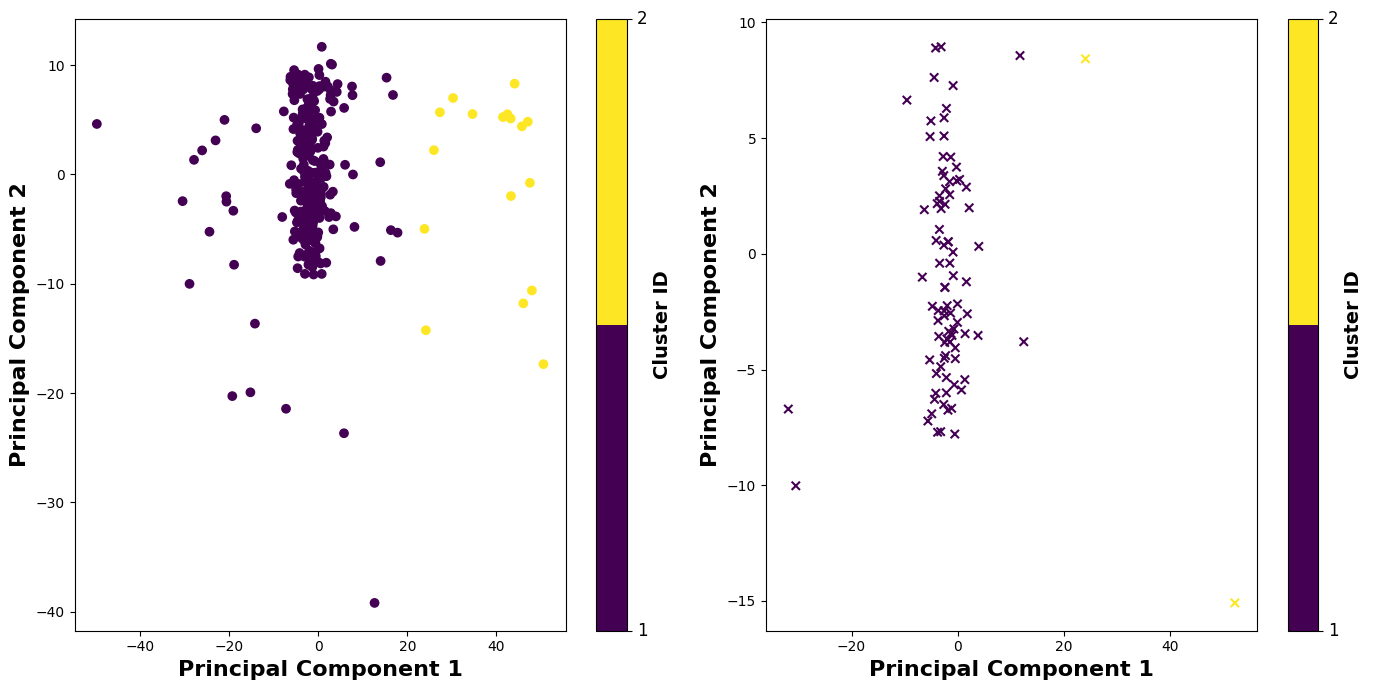

Agglomerative Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_h = plt.cm.get_cmap('viridis', num_clusters_h)


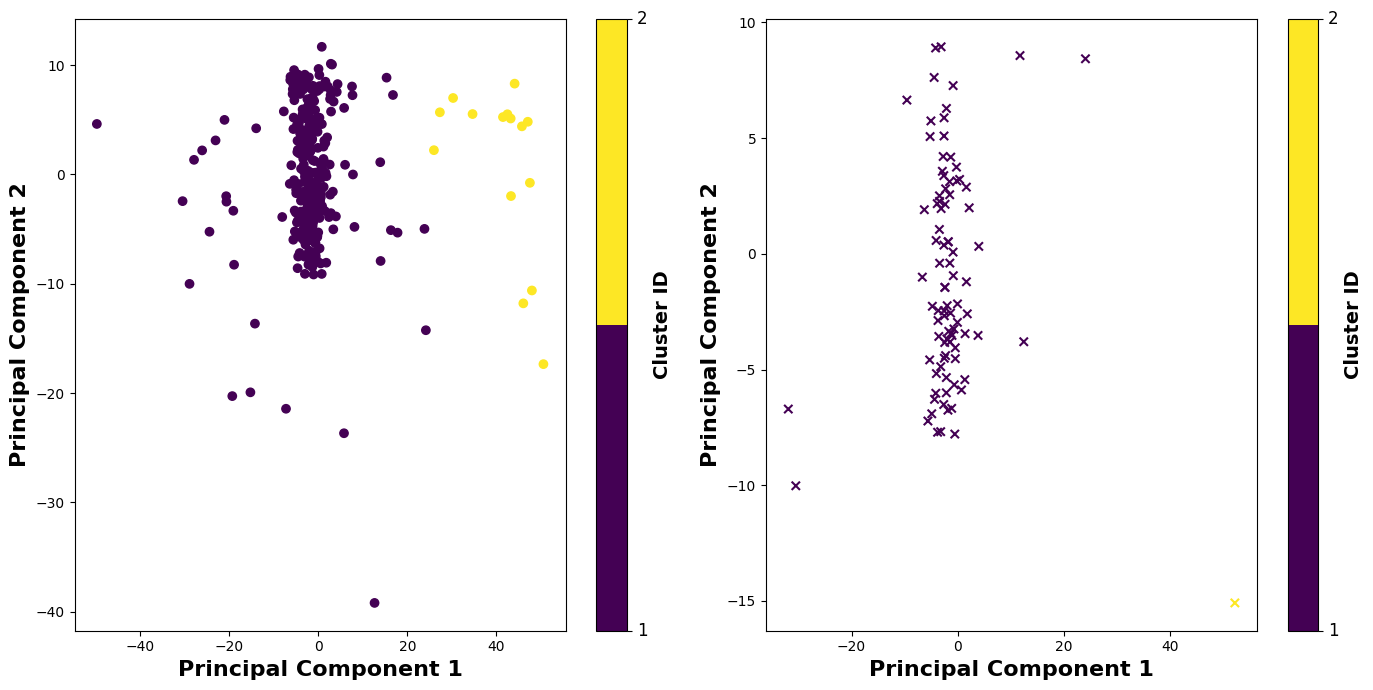

DBSCAN Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_d = plt.cm.get_cmap('viridis', num_clusters_d)


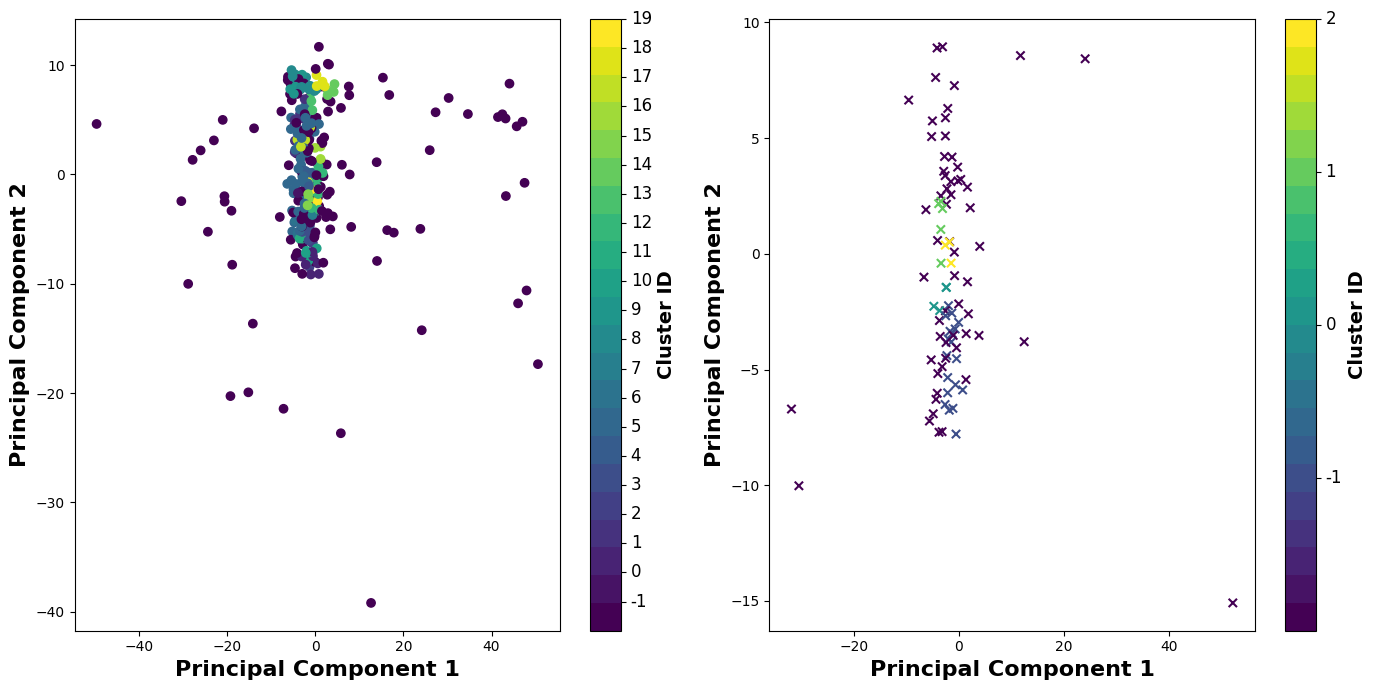

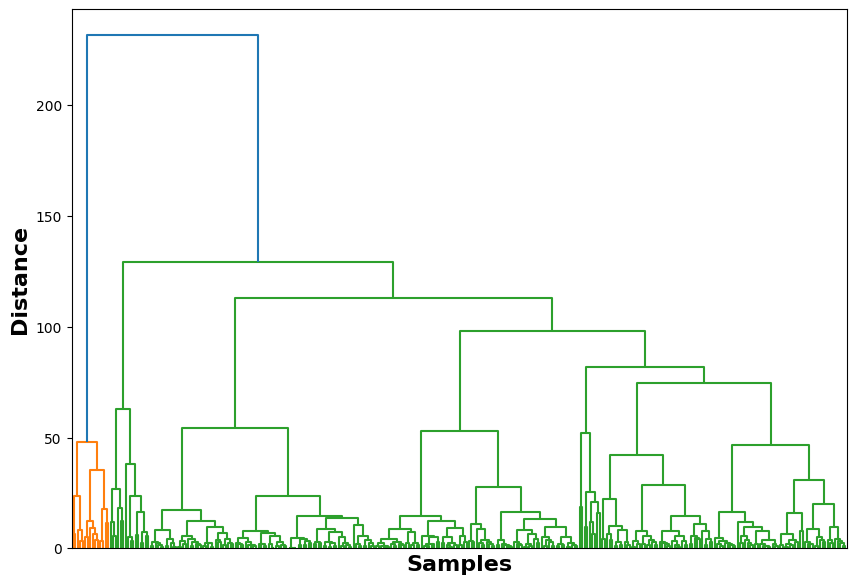

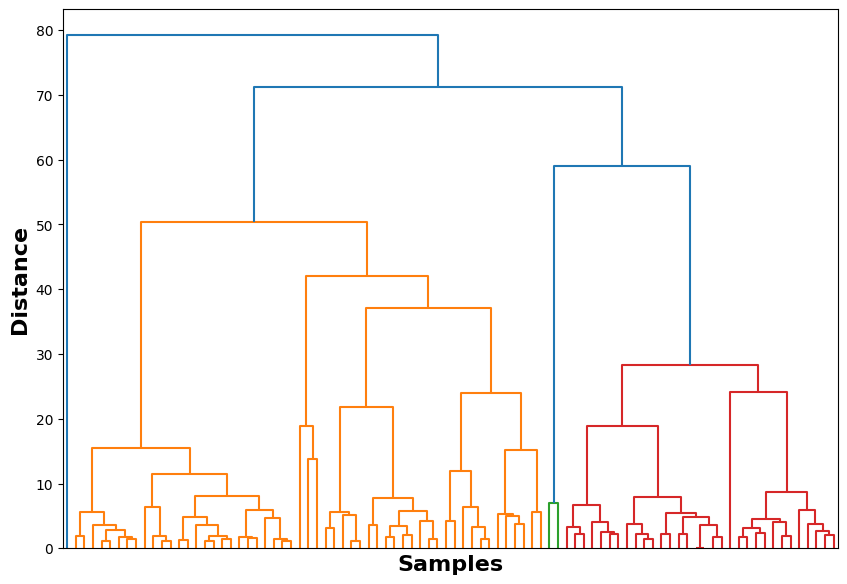

In [56]:
plot_and_cluster(X_train_pca, X_test_pca, results_new_pca['kmeans_train'], results_new_pca['hierarchical_train'], results_new_pca['dbscan_train'], results_new_pca['links_train'], results_new_pca['kmeans_test'], results_new_pca['hierarchical_test'], results_new_pca['dbscan_test'], results_new_pca['links_test'], label='Principal Component')

### Using Factors

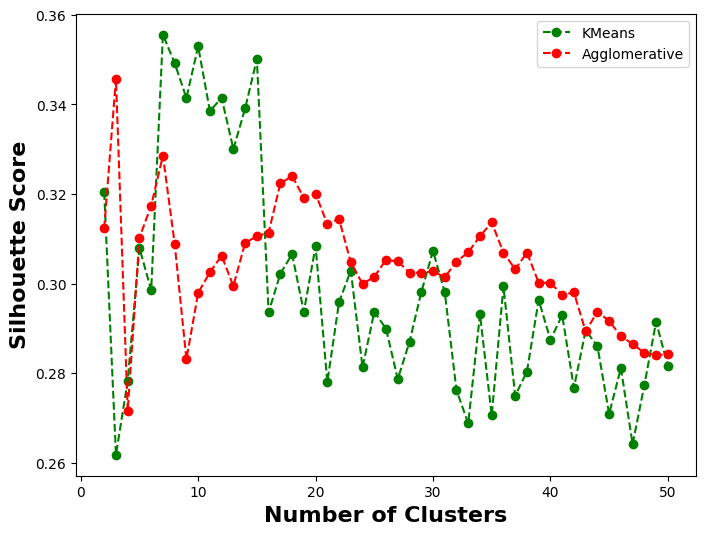

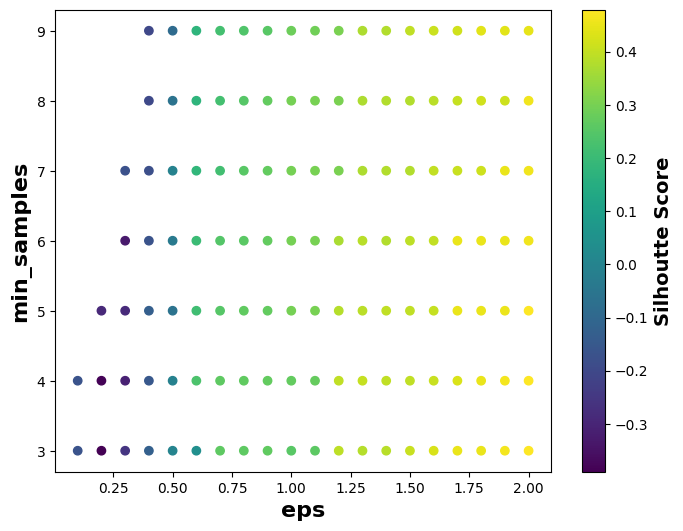

Optimal number of clusters for KMeans: 7
Optimal number of clusters for Agglomerative Clustering: 3
Optimal DBSCAN parameters: eps=2.0, min_samples=5


In [57]:
optimal_kmeans_clusters_fa, optimal_agglo_clusters_fa, best_dbscan_params_fa = find_optimal_clusters(X_train_fa, max_clusters=50)

In [58]:
results_new_fa = fit_and_predict_clusters(X_train_fa, X_test_fa, optimal_kmeans_clusters_fa, optimal_agglo_clusters_fa, best_dbscan_params_fa)

K-means Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_k = plt.cm.get_cmap('viridis', num_clusters_k)


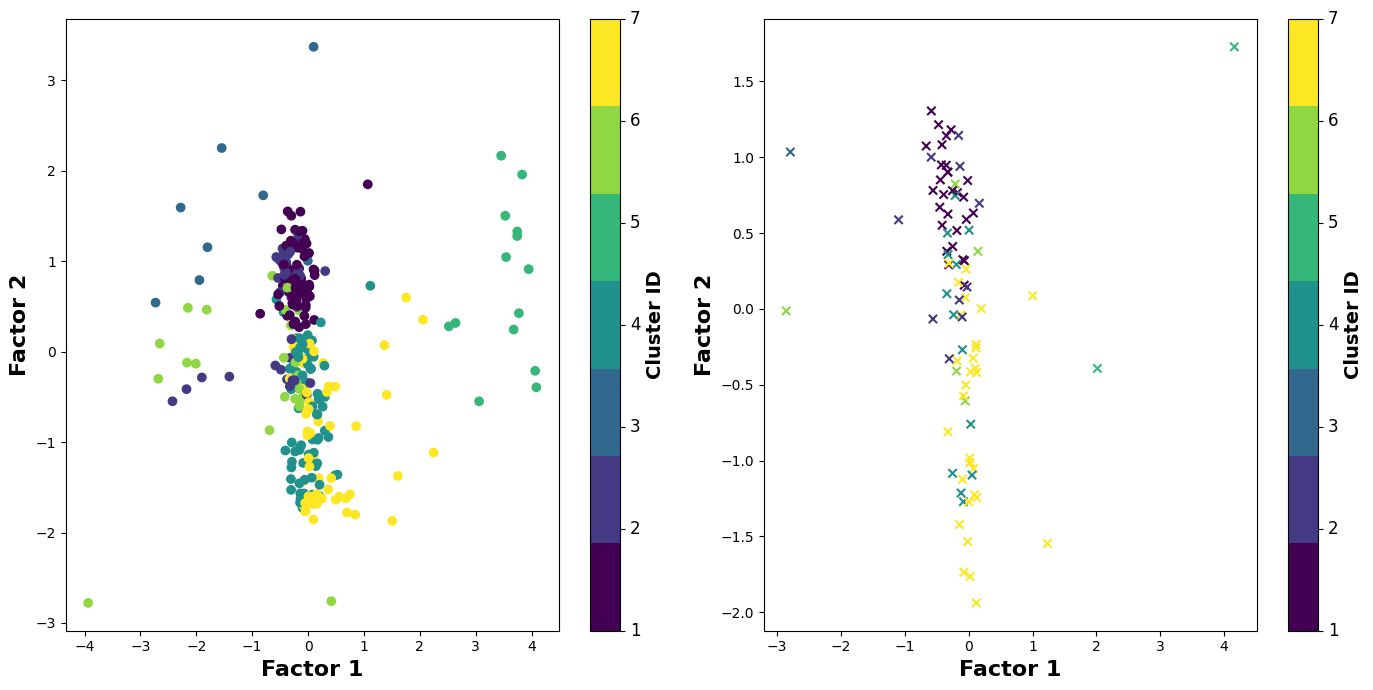

/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_h = plt.cm.get_cmap('viridis', num_clusters_h)


Agglomerative Clustering


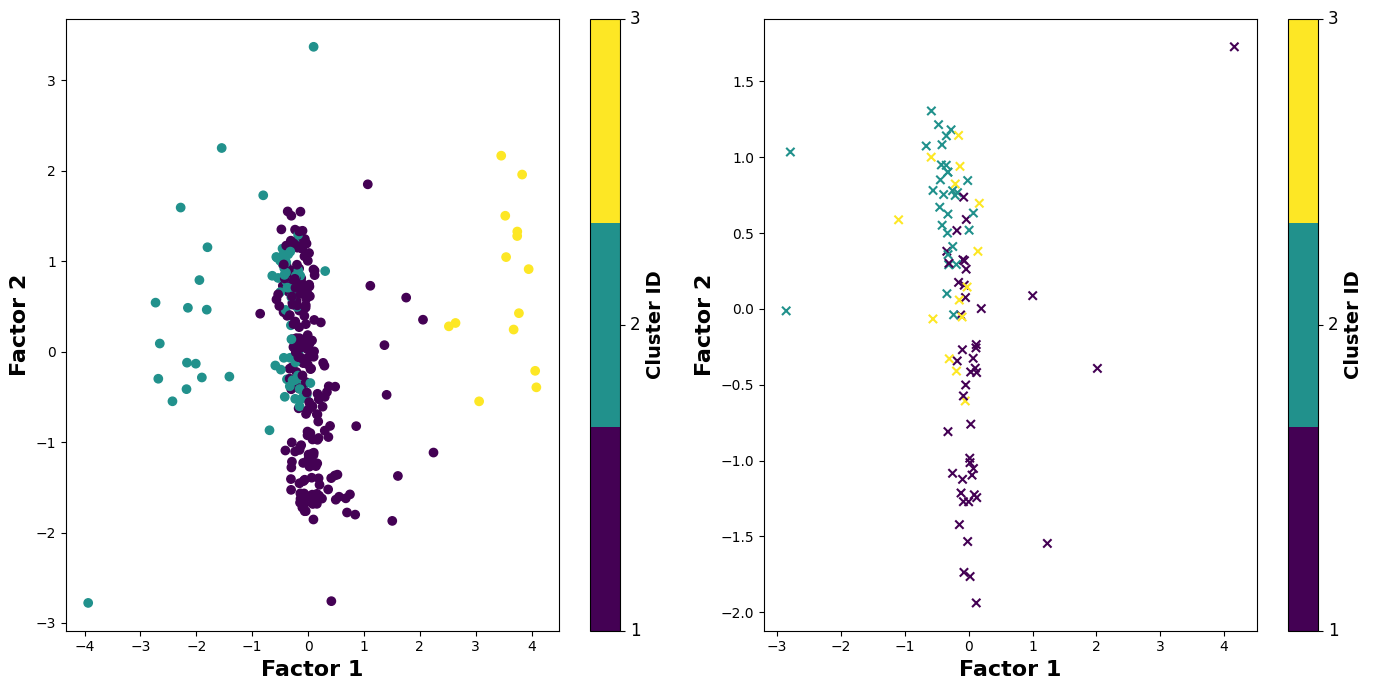

DBSCAN Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_d = plt.cm.get_cmap('viridis', num_clusters_d)


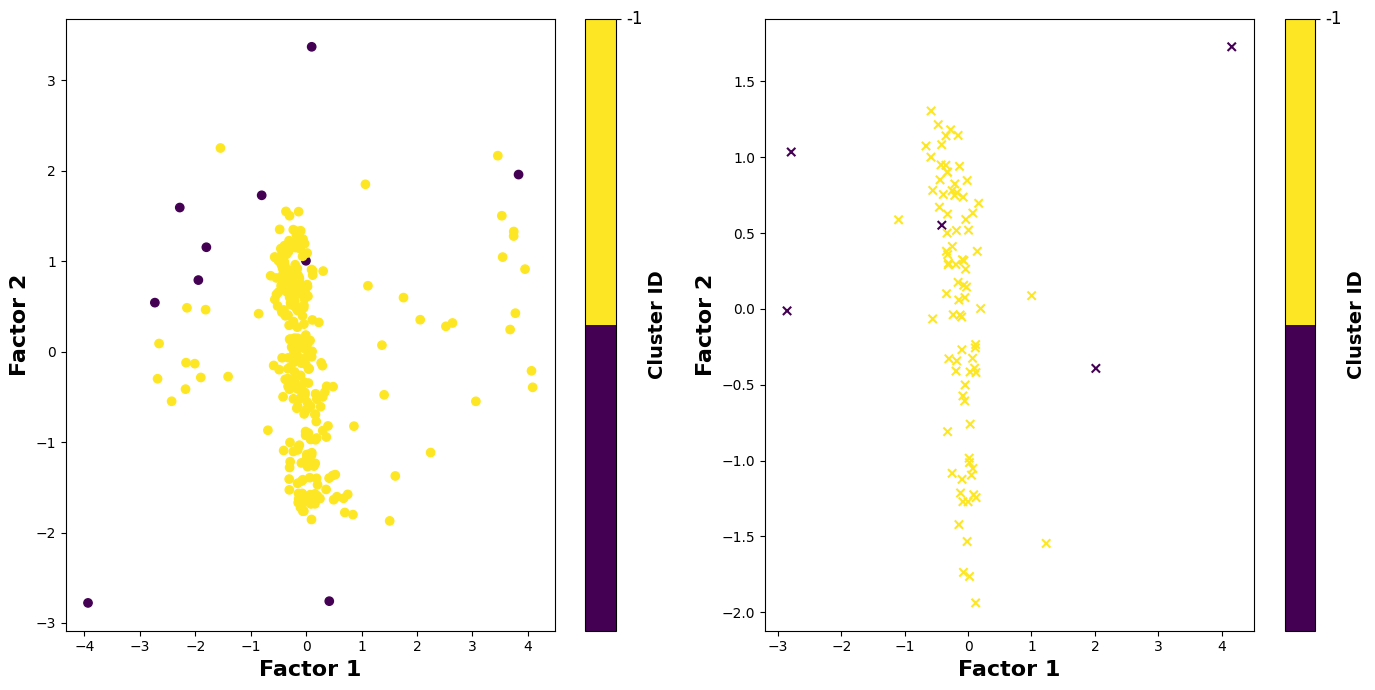

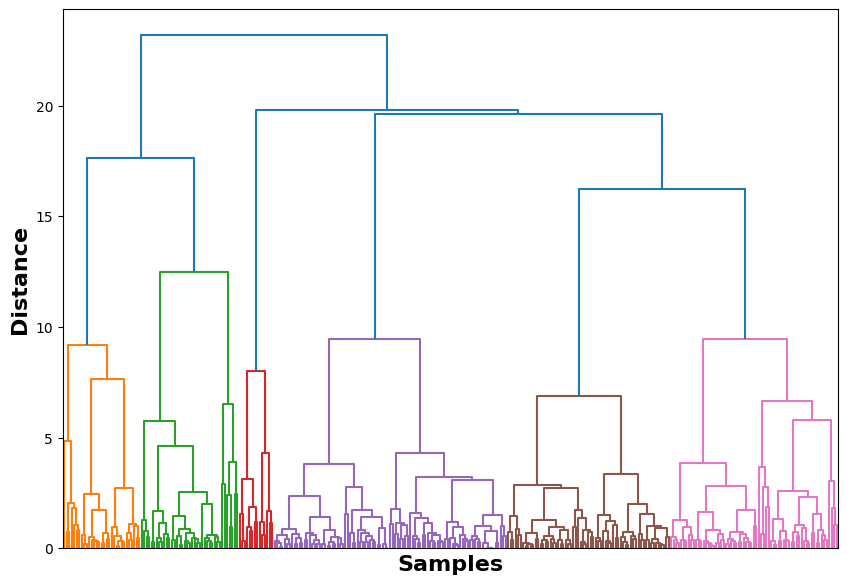

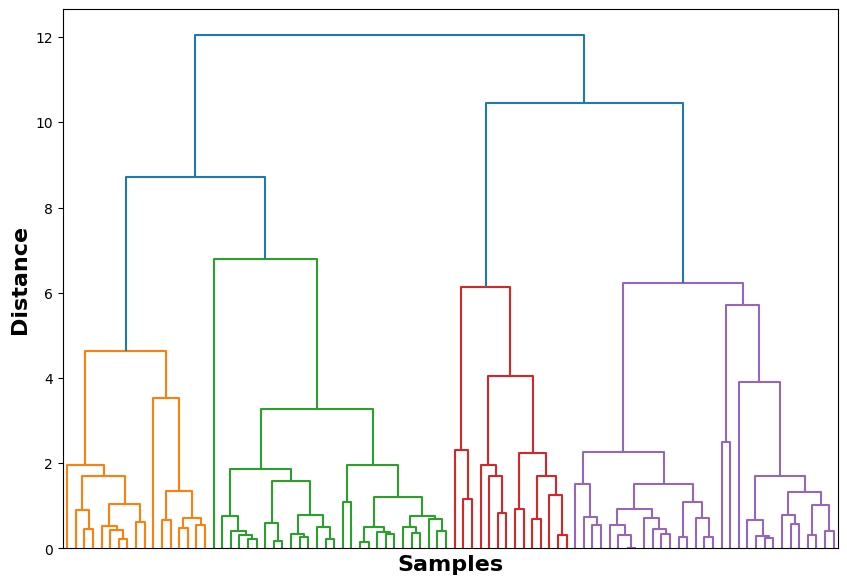

In [59]:
plot_and_cluster(X_train_fa, X_test_fa, results_new_fa['kmeans_train'], results_new_fa['hierarchical_train'], results_new_fa['dbscan_train'], results_new_fa['links_train'], results_new_fa['kmeans_test'], results_new_fa['hierarchical_test'], results_new_fa['dbscan_test'], results_new_fa['links_test'], label='Factor')

In [60]:
# kmeans_clusters_fa, agglo_clusters_fa, dbscan_clusters_fa, links_fa = perform_clustering(X_train_fa, optimal_kmeans_clusters_fa, optimal_agglo_clusters_fa, best_dbscan_params_fa)

In [61]:
# plot_and_cluster(X_train_fa, kmeans_clusters_fa, agglo_clusters_fa, dbscan_clusters_fa, links_fa, label='Factor')

## Training clusters

### Using Principal Components

In [62]:
results_orig_pca = fit_and_predict_clusters(X_train_pca, X_test_pca, 6, 6, best_dbscan_params_pca)

K-means Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_k = plt.cm.get_cmap('viridis', num_clusters_k)


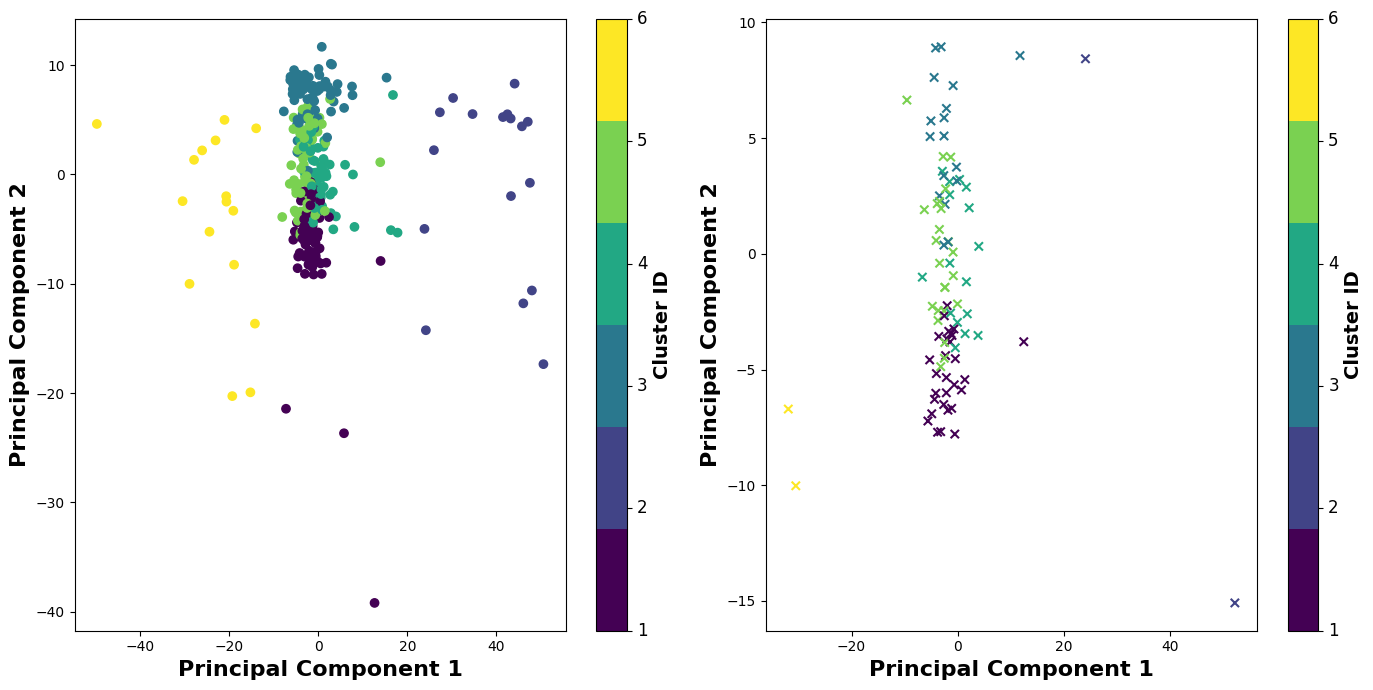

Agglomerative Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_h = plt.cm.get_cmap('viridis', num_clusters_h)


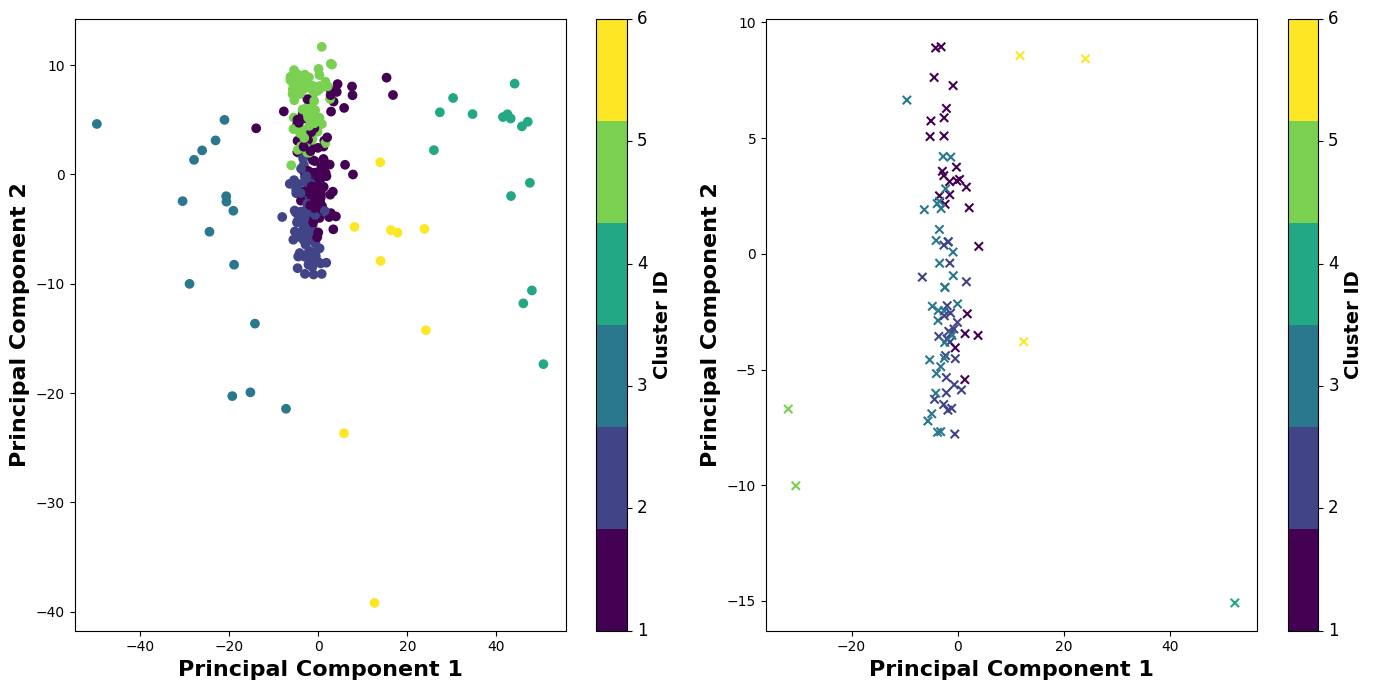

DBSCAN Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_d = plt.cm.get_cmap('viridis', num_clusters_d)


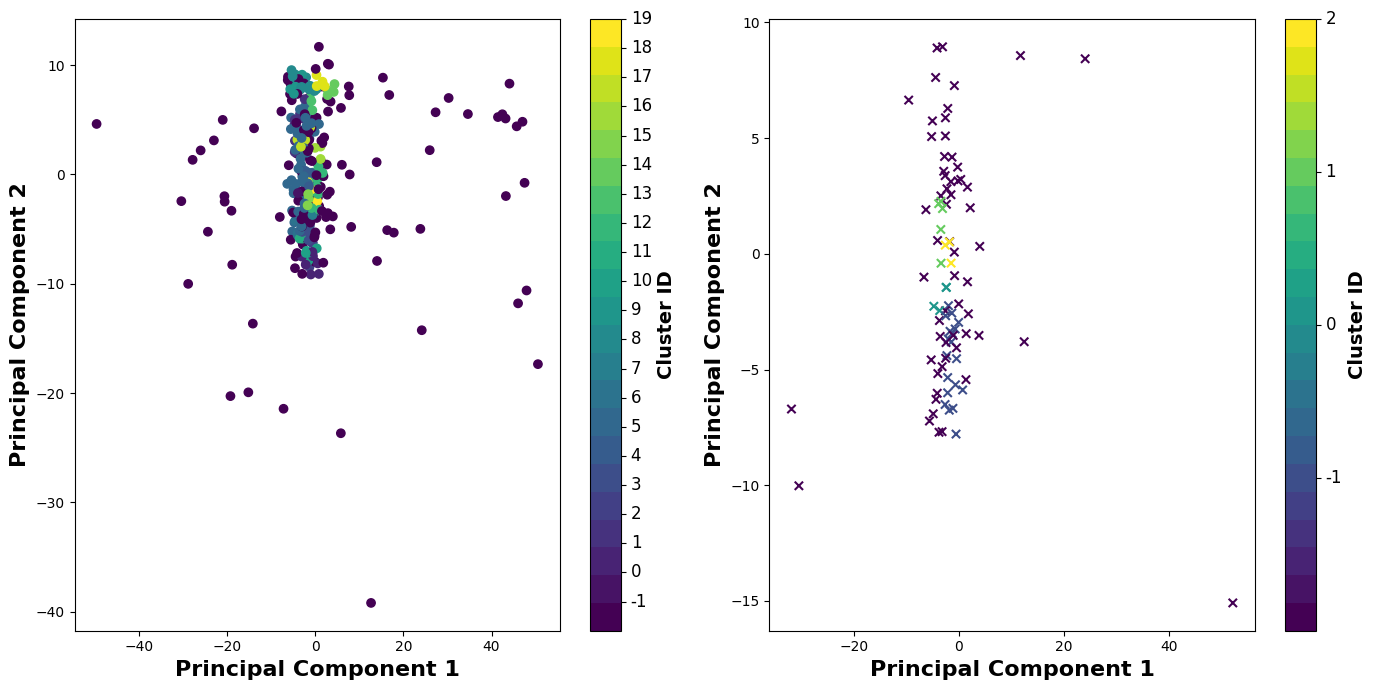

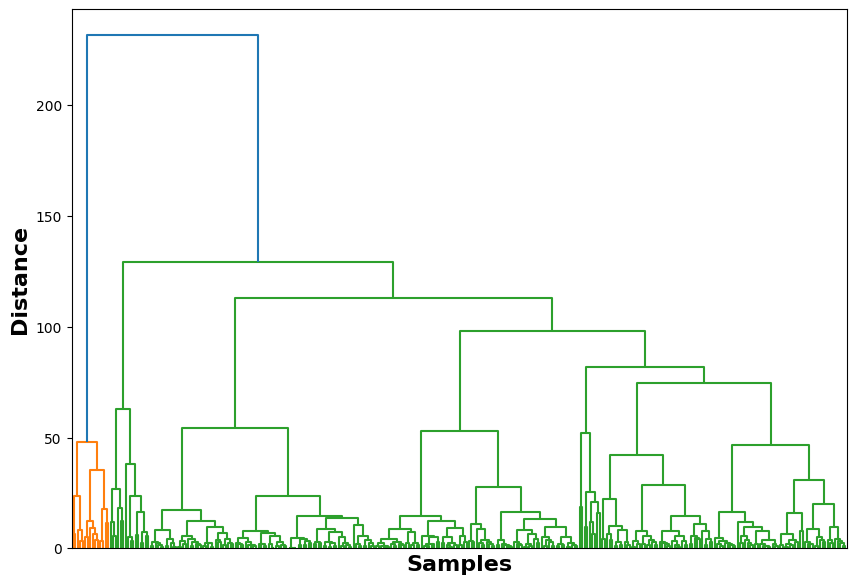

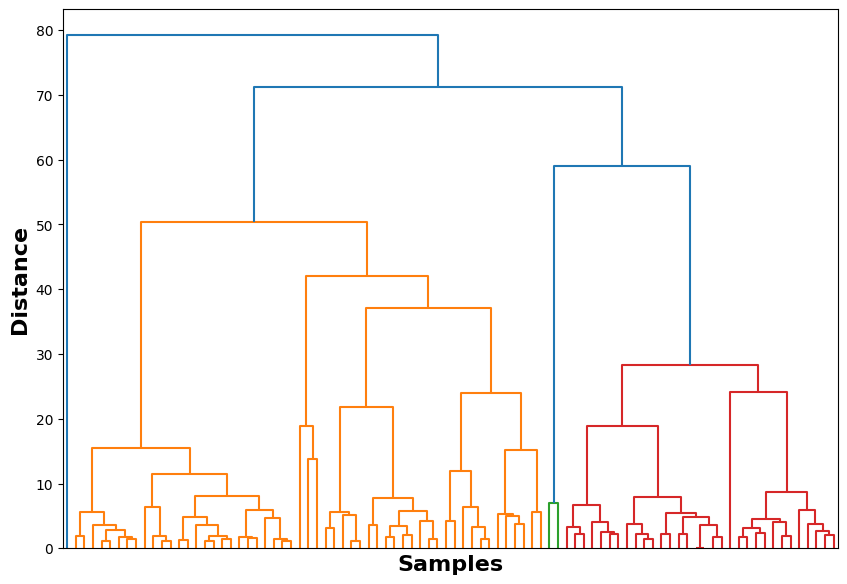

In [63]:
plot_and_cluster(X_train_pca, X_test_pca, results_orig_pca['kmeans_train'], results_orig_pca['hierarchical_train'], results_orig_pca['dbscan_train'], results_orig_pca['links_train'], results_orig_pca['kmeans_test'], results_orig_pca['hierarchical_test'], results_orig_pca['dbscan_test'], results_orig_pca['links_test'], label='Principal Component')

### Using Factors

In [64]:
results_orig_fa = fit_and_predict_clusters(X_train_fa, X_test_fa, 6, 6, best_dbscan_params_fa)

K-means Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_k = plt.cm.get_cmap('viridis', num_clusters_k)


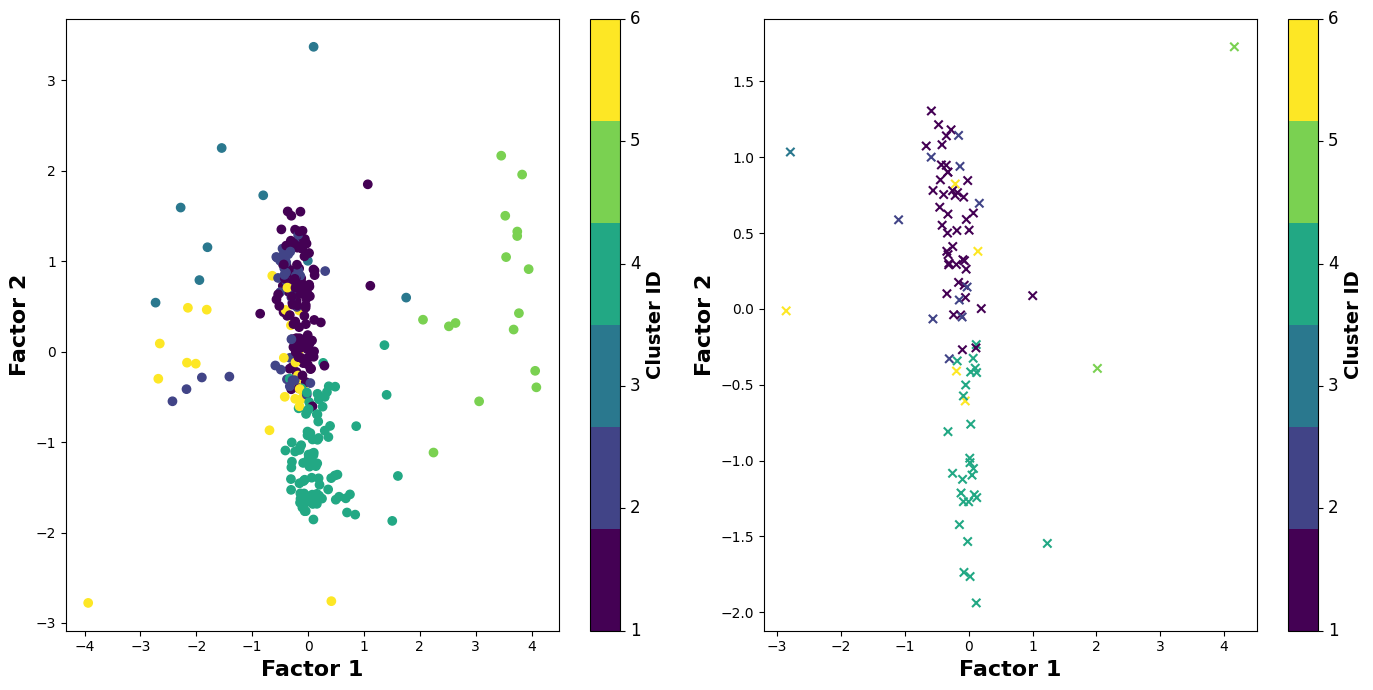

Agglomerative Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_h = plt.cm.get_cmap('viridis', num_clusters_h)


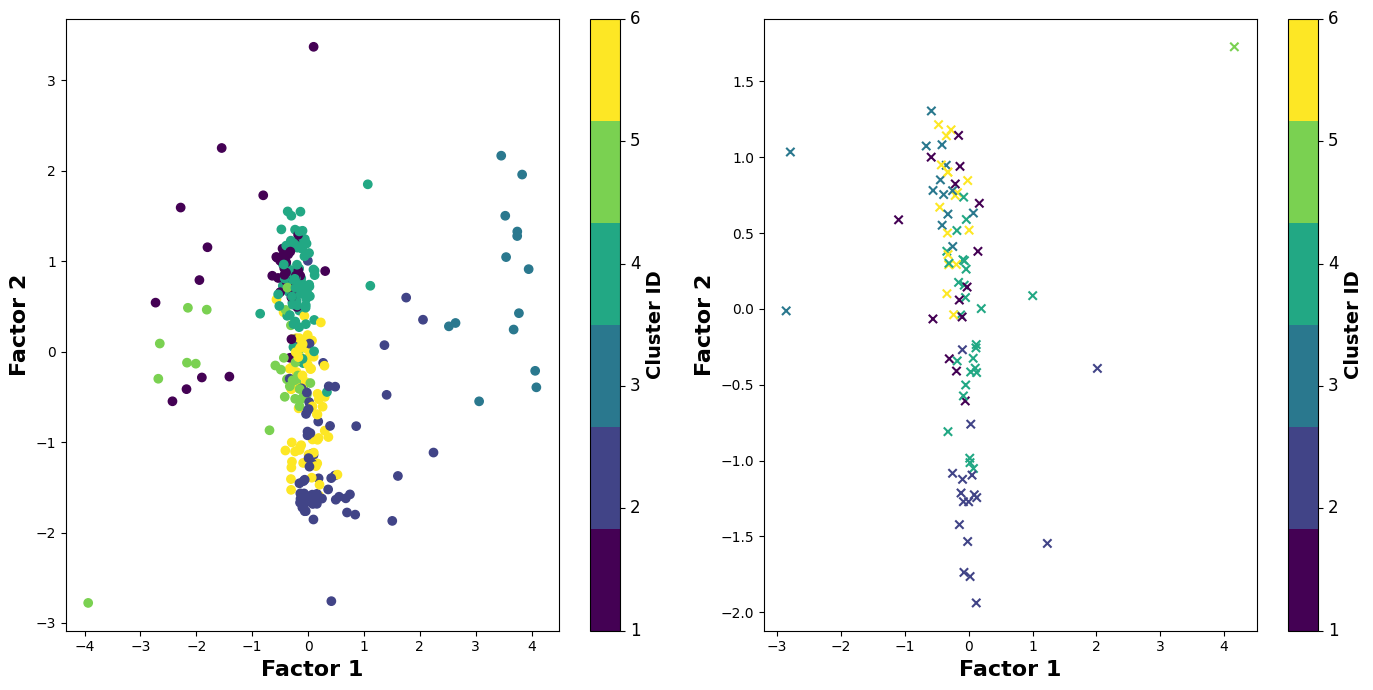

DBSCAN Clustering


/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/2022920792.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_d = plt.cm.get_cmap('viridis', num_clusters_d)


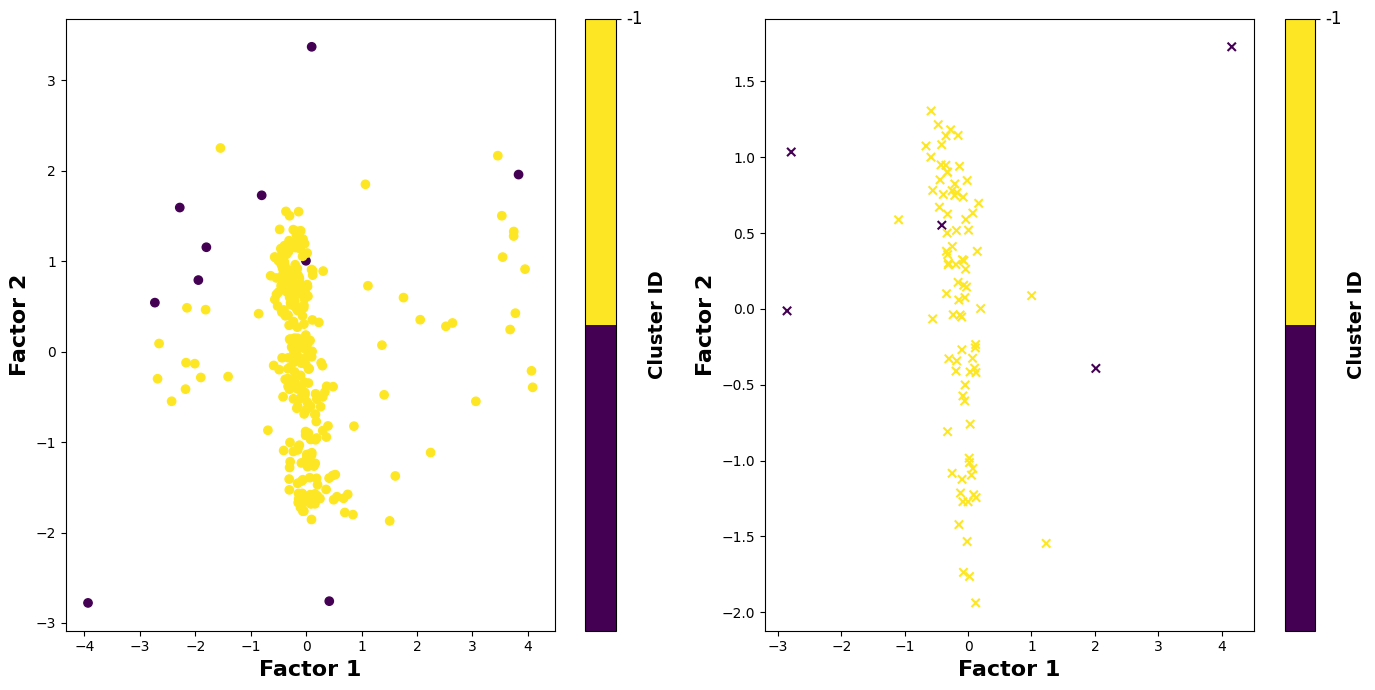

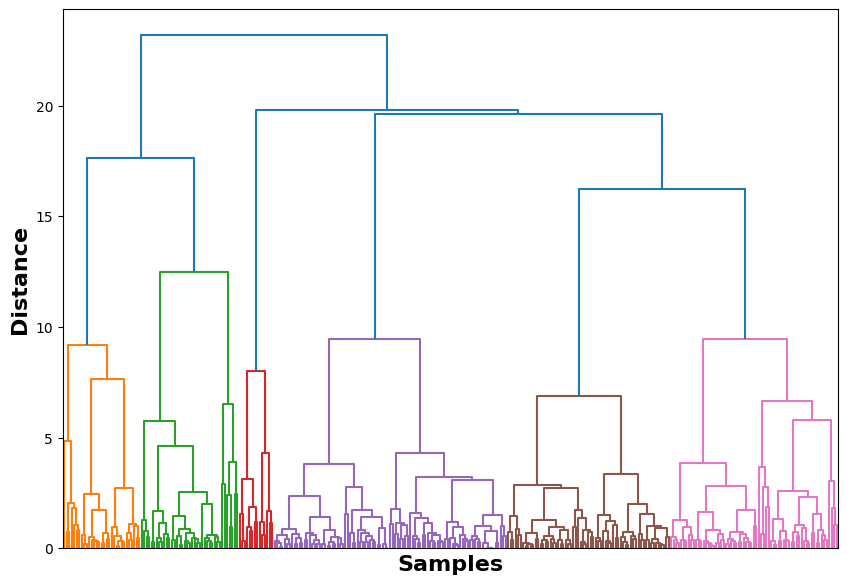

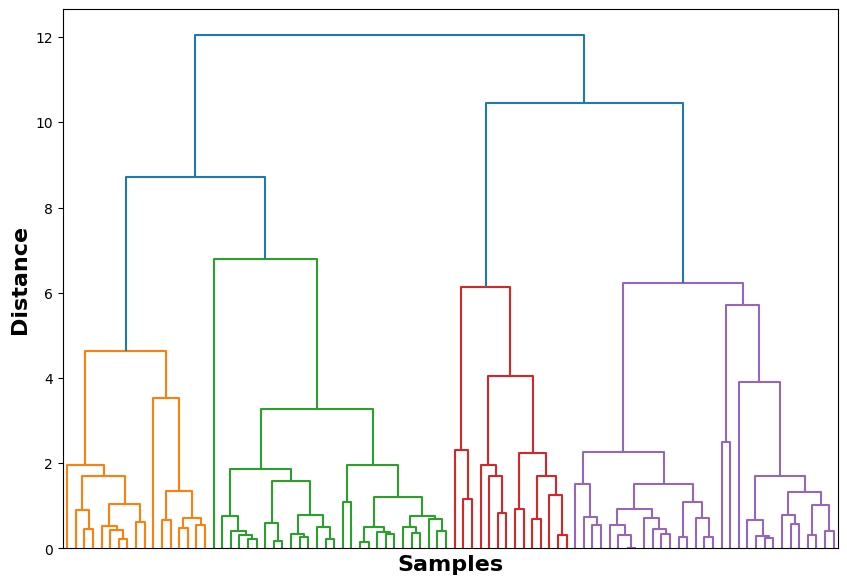

In [65]:
plot_and_cluster(X_train_fa, X_test_fa, results_orig_fa['kmeans_train'], results_orig_fa['hierarchical_train'], results_orig_fa['dbscan_train'], results_orig_fa['links_train'], results_orig_fa['kmeans_test'], results_orig_fa['hierarchical_test'], results_orig_fa['dbscan_test'], results_orig_fa['links_test'], label='Factor')

# Original Dataset

/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/3359789842.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_train = plt.cm.get_cmap('viridis', num_clusters_train)
/var/folders/8h/n388zfks0k1djzz5n7r6d5m00000gn/T/ipykernel_37460/3359789842.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_test = plt.cm.get_cmap('viridis', num_clusters_test)


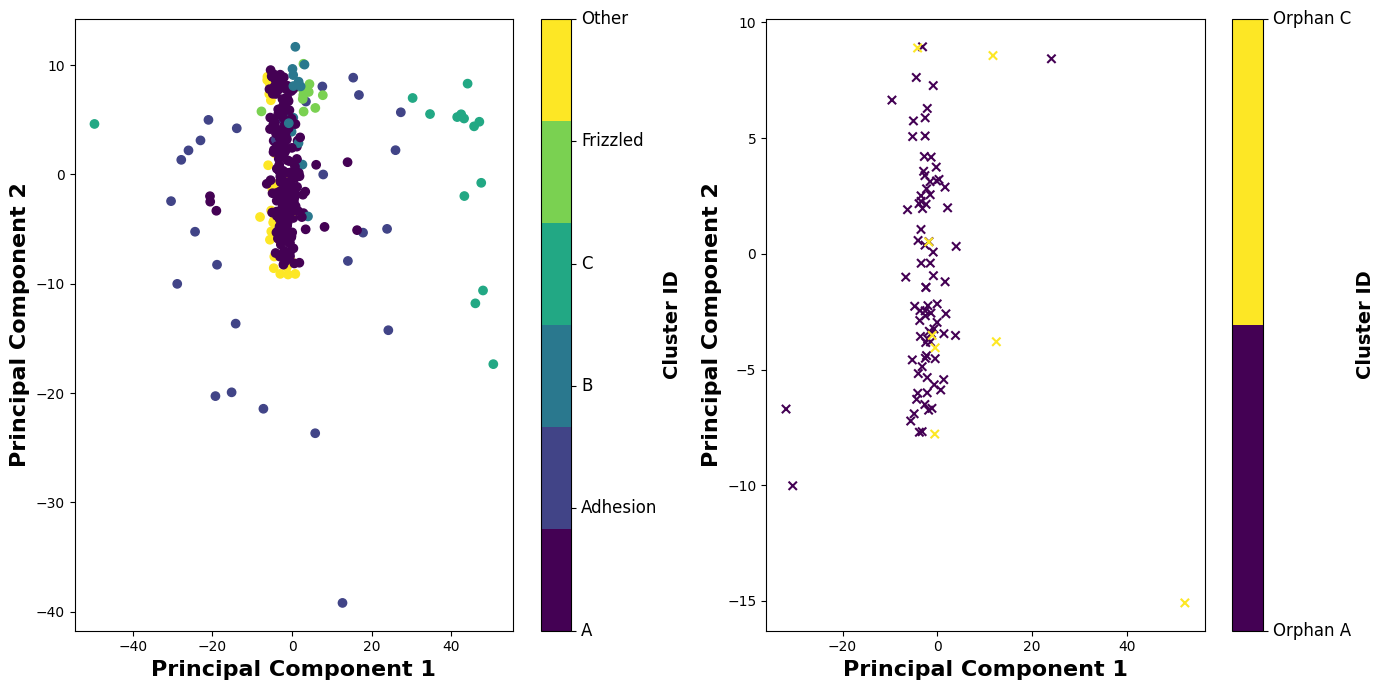

In [66]:
# Convert class labels from dtype=object to numeric codes
class_labels_train = pd.Categorical(df_known_train_targets['Class'])
numeric_labels_train = class_labels_train.codes
label_map_train = dict(enumerate(class_labels_train.categories))

class_labels_test = pd.Categorical(df_orphan_test_targets['Class'])
numeric_labels_test = class_labels_test.codes
label_map_test = dict(enumerate(class_labels_test.categories))

# Determine the number of unique clusters for both sets
num_clusters_train = len(np.unique(numeric_labels_train))
num_clusters_test = len(np.unique(numeric_labels_test))

# Get colormaps for the number of clusters in each dataset
colors_train = plt.cm.get_cmap('viridis', num_clusters_train)
colors_test = plt.cm.get_cmap('viridis', num_clusters_test)

label = 'Principal Component'

plt.figure(figsize=(14, 7))

# Plot training data
plt.subplot(1, 2, 1)
scatter_train_k = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=numeric_labels_train, cmap=colors_train, alpha=1, marker='o', label='Training Data')
plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
cbar_train = plt.colorbar(scatter_train_k, ticks=np.arange(num_clusters_train))
cbar_train.set_label('Cluster ID', fontsize=14, fontweight='bold')
cbar_train.set_ticklabels([label_map_train[i] for i in np.arange(num_clusters_train)], fontsize=12, verticalalignment='center')

# Plot test data
plt.subplot(1, 2, 2)
scatter_test_k = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=numeric_labels_test, cmap=colors_test, alpha=1, marker='x', label='Test Data')
plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
cbar_test = plt.colorbar(scatter_test_k, ticks=np.arange(num_clusters_test))
cbar_test.set_label('Cluster ID', fontsize=14, fontweight='bold')
cbar_test.set_ticklabels([label_map_test[i] for i in np.arange(num_clusters_test)], fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()

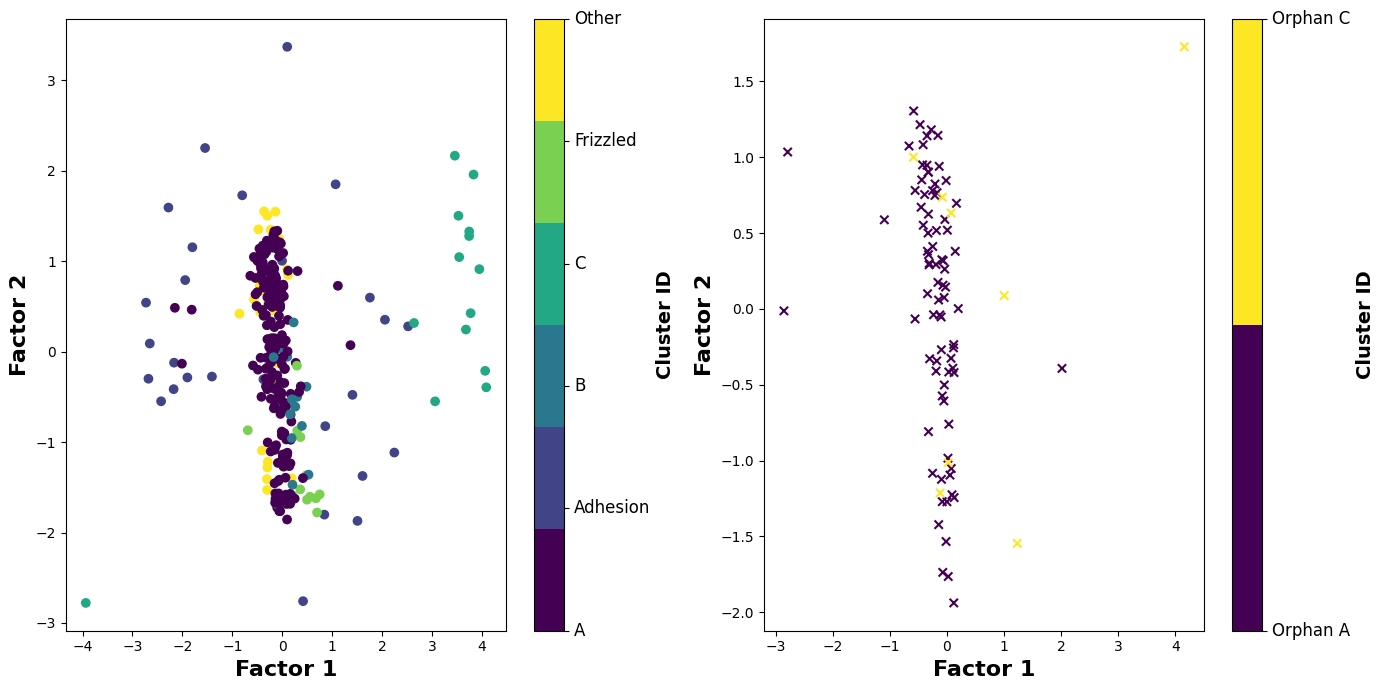

In [67]:
label = 'Factor'

plt.figure(figsize=(14, 7))

# Plot training data
plt.subplot(1, 2, 1)
scatter_train_k = plt.scatter(X_train_fa[:, 0], X_train_fa[:, 1], c=numeric_labels_train, cmap=colors_train, alpha=1, marker='o', label='Training Data')
plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
cbar_train = plt.colorbar(scatter_train_k, ticks=np.arange(num_clusters_train))
cbar_train.set_label('Cluster ID', fontsize=14, fontweight='bold')
cbar_train.set_ticklabels([label_map_train[i] for i in np.arange(num_clusters_train)], fontsize=12, verticalalignment='center')

# Plot test data
plt.subplot(1, 2, 2)
scatter_test_k = plt.scatter(X_test_fa[:, 0], X_test_fa[:, 1], c=numeric_labels_test, cmap=colors_test, alpha=1, marker='x', label='Test Data')
plt.xlabel(f'{label} 1', fontsize=16, fontweight='bold')
plt.ylabel(f'{label} 2', fontsize=16, fontweight='bold')
cbar_test = plt.colorbar(scatter_test_k, ticks=np.arange(num_clusters_test))
cbar_test.set_label('Cluster ID', fontsize=14, fontweight='bold')
cbar_test.set_ticklabels([label_map_test[i] for i in np.arange(num_clusters_test)], fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()

# Combined Clustering Methods

## Training Data

### Using Principal Components

In [68]:
kmeans_results_pca_new = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'K-means PCA Optimal Params': results_new_pca['kmeans_train']
})

agglo_results_pca_new = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'Agglomerative PCA Optimal Params': results_new_pca['hierarchical_train']
})

dbscan_results_pca_new = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'DBSCAN PCA Optimal Params': results_new_pca['dbscan_train']
})

In [69]:
kmeans_results_pca_orig = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'K-means PCA Original Params': results_orig_pca['kmeans_train']
})

agglo_results_pca_orig = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'Agglomerative PCA Original Params': results_orig_pca['hierarchical_train']
})

dbscan_results_pca_orig = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'DBSCAN PCA Original Params': results_orig_pca['dbscan_train']
})

### Using Factors

In [70]:
kmeans_results_fa_new = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'K-means FA Optimal Params': results_new_fa['kmeans_train']
})

agglo_results_fa_new = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'Agglomerative FA Optimal Params': results_new_fa['hierarchical_train']
})

dbscan_results_fa_new = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'DBSCAN FA Optimal Params': results_new_fa['dbscan_train']
})

In [71]:
kmeans_results_fa_orig = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'K-means FA Original Params': results_orig_fa['kmeans_train']
})

agglo_results_fa_orig = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'Agglomerative FA Original Params': results_orig_fa['hierarchical_train']
})

dbscan_results_fa_orig = pd.DataFrame({
    'protein': df_known_train_targets.index,
    'DBSCAN FA Original Params': results_new_fa['dbscan_train']
})

### Combined

In [72]:
clustering_summary_training_data = kmeans_results_pca_orig.merge(kmeans_results_pca_new, on='protein', how='outer') \
                               .merge(kmeans_results_fa_orig, on='protein', how='outer') \
                               .merge(kmeans_results_fa_new, on='protein', how='outer') \
                               .merge(agglo_results_pca_orig, on='protein', how='outer') \
                               .merge(agglo_results_pca_new, on='protein', how='outer') \
                               .merge(agglo_results_fa_orig, on='protein', how='outer') \
                               .merge(agglo_results_fa_new, on='protein', how='outer') \
                               .merge(dbscan_results_pca_orig, on='protein', how='outer') \
                               .merge(dbscan_results_pca_new, on='protein', how='outer') \
                               .merge(dbscan_results_fa_orig, on='protein', how='outer') \
                               .merge(dbscan_results_fa_new, on='protein', how='outer')

clustering_summary_training_data_final = pd.merge(clustering_summary_training_data, df_known_train_targets, left_on='protein', right_index=True)
clustering_summary_training_data_final

protein  K-means PCA Original Params  K-means PCA Optimal Params  \
0    O00144                            2                           0   
1    O00222                            1                           1   
2    O00254                            4                           0   
3    O00421                            2                           0   
4    O00574                            3                           0   
..      ...                          ...                         ...   
304  Q9Y2T6                            2                           0   
305  Q9Y5N1                            4                           0   
306  Q9Y5X5                            4                           0   
307  Q9Y5Y4                            2                           0   
308  Q9Y653                            3                           0   

     K-means FA Original Params  K-means FA Optimal Params  \
0                             3                          3   
1                             4                          4   
2                             0                          3   
3                             3                          3   
4                             1                          1   
..                          ...                        ...   
304                           3                          6   
305                           0                          0   
306                           0                          3   
307                           3                          6   
308                           3                          6   

     Agglomerative PCA Original Params  Agglomerative PCA Optimal Params  \
0                                    0                                 0   
1                                    3                                 1   
2                                    4                                 0   
3                                    4                                 0   
4                                    0                                 0   
..                                 ...                               ...   
304                                  4                                 0   
305                                  1                                 0   
306                                  4                                 0   
307                                  0                                 0   
308                                  5                                 0   

     Agglomerative FA Original Params  Agglomerative FA Optimal Params  \
0                                   1                                0   
1                                   2                                2   
2                                   5                                0   
3                                   5                                0   
4                                   0                                1   
..                                ...                              ...   
304                                 1                                0   
305                                 3                                0   
306                                 5                                0   
307                                 1                                0   
308                                 1                                0   

     DBSCAN PCA Original Params  DBSCAN PCA Optimal Params  \
0                            15                         15   
1                            -1                         -1   
2                             6                          6   
3                            -1                         -1   
4                            13                         13   
..                          ...                        ...   
304                          -1                         -1   
305                           6                          6   
306                          -1   

### Pair Plots

<Figure size 600x400 with 0 Axes>

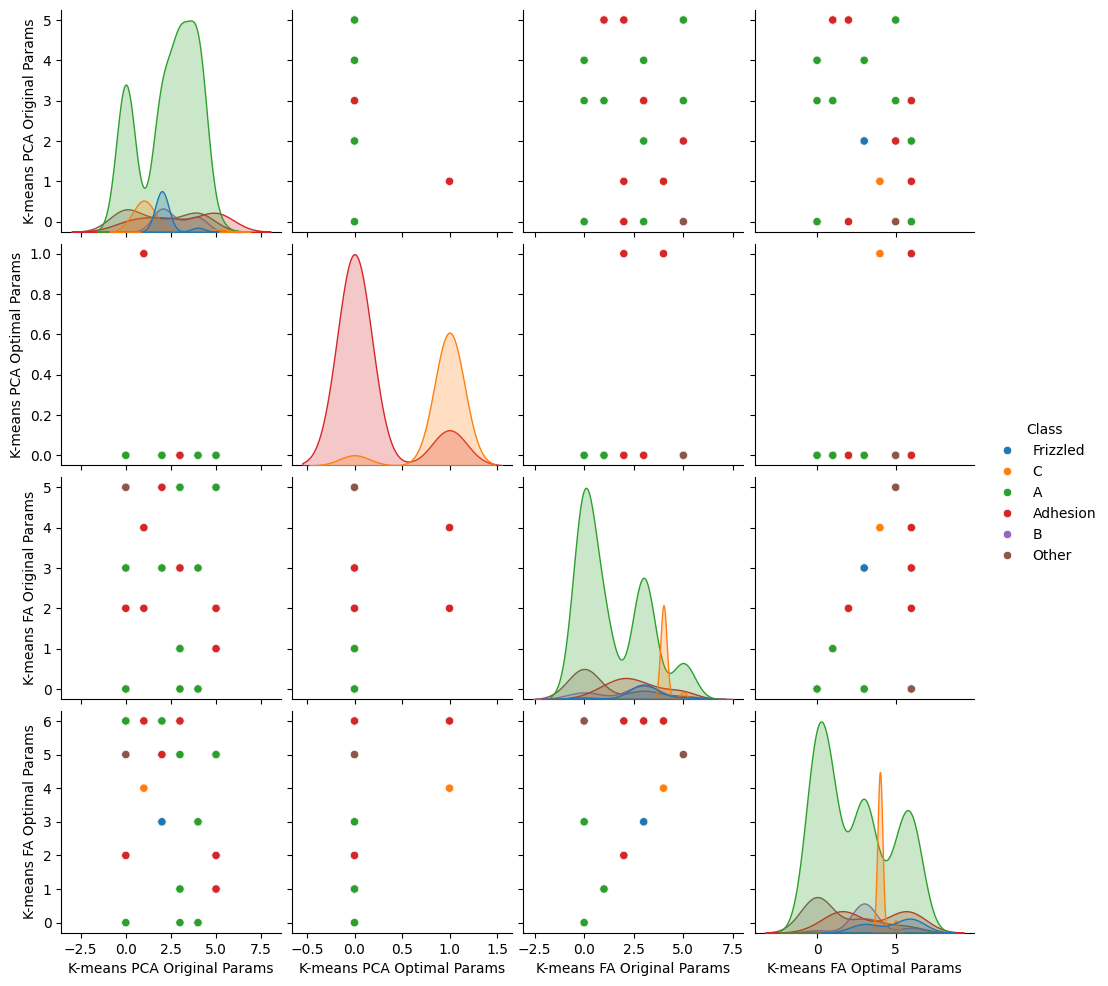

In [73]:
features = ['K-means PCA Original Params', 'K-means PCA Optimal Params', 'K-means FA Original Params', 'K-means FA Optimal Params', 'Class']
plt.figure(figsize=(6, 4))
sns.pairplot(clustering_summary_training_data_final[features], hue='Class')
plt.show()

<Figure size 600x400 with 0 Axes>

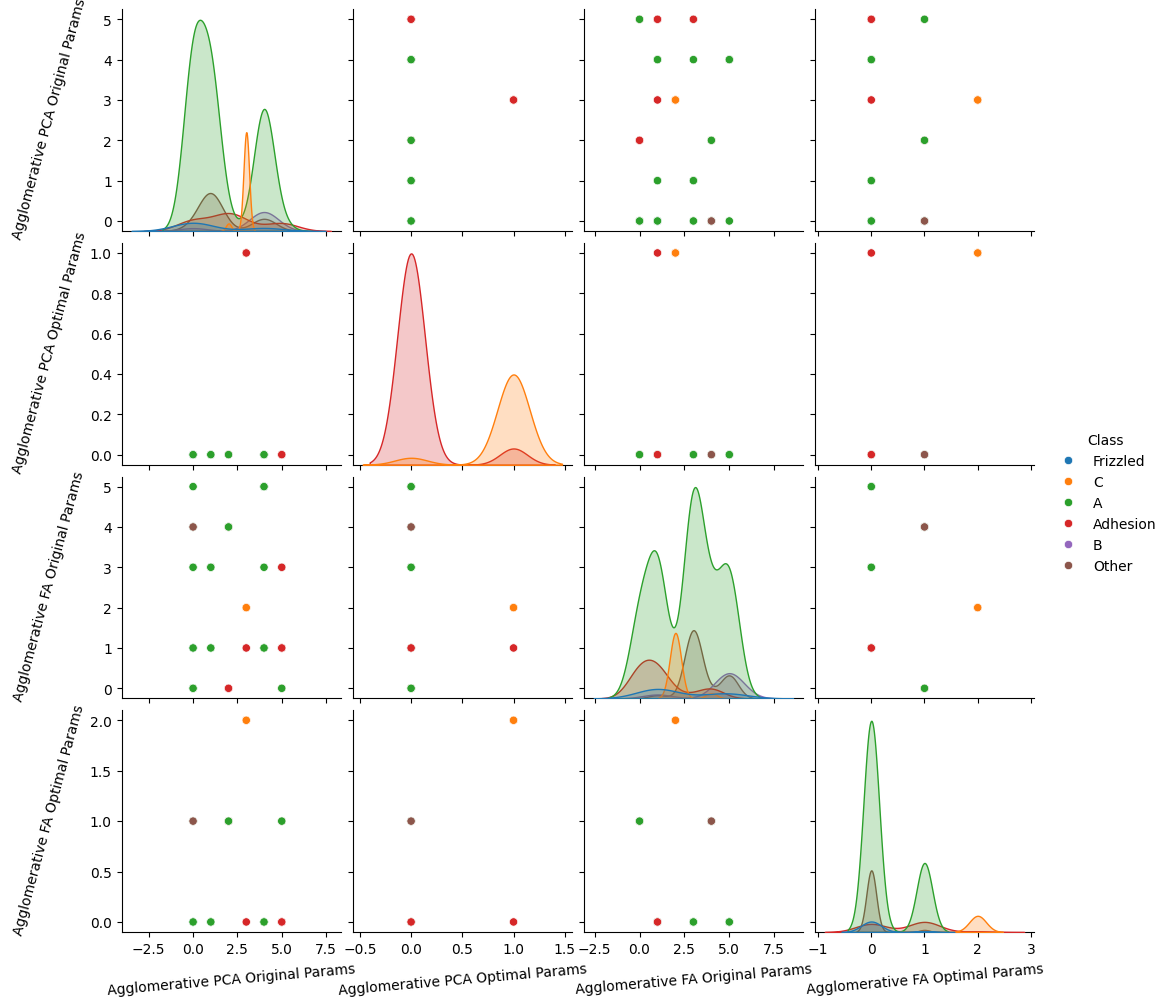

In [74]:
features = ['Agglomerative PCA Original Params', 'Agglomerative PCA Optimal Params', 'Agglomerative FA Original Params', 'Agglomerative FA Optimal Params', 'Class']
plt.figure(figsize=(6, 4))
pairplot = sns.pairplot(clustering_summary_training_data_final[features], hue='Class')
for ax in pairplot.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), rotation=75)
    ax.get_yaxis().set_label_coords(-0.3, 0.5)
    ax.set_xlabel(ax.get_xlabel(), rotation=5)
plt.show()

<Figure size 600x400 with 0 Axes>

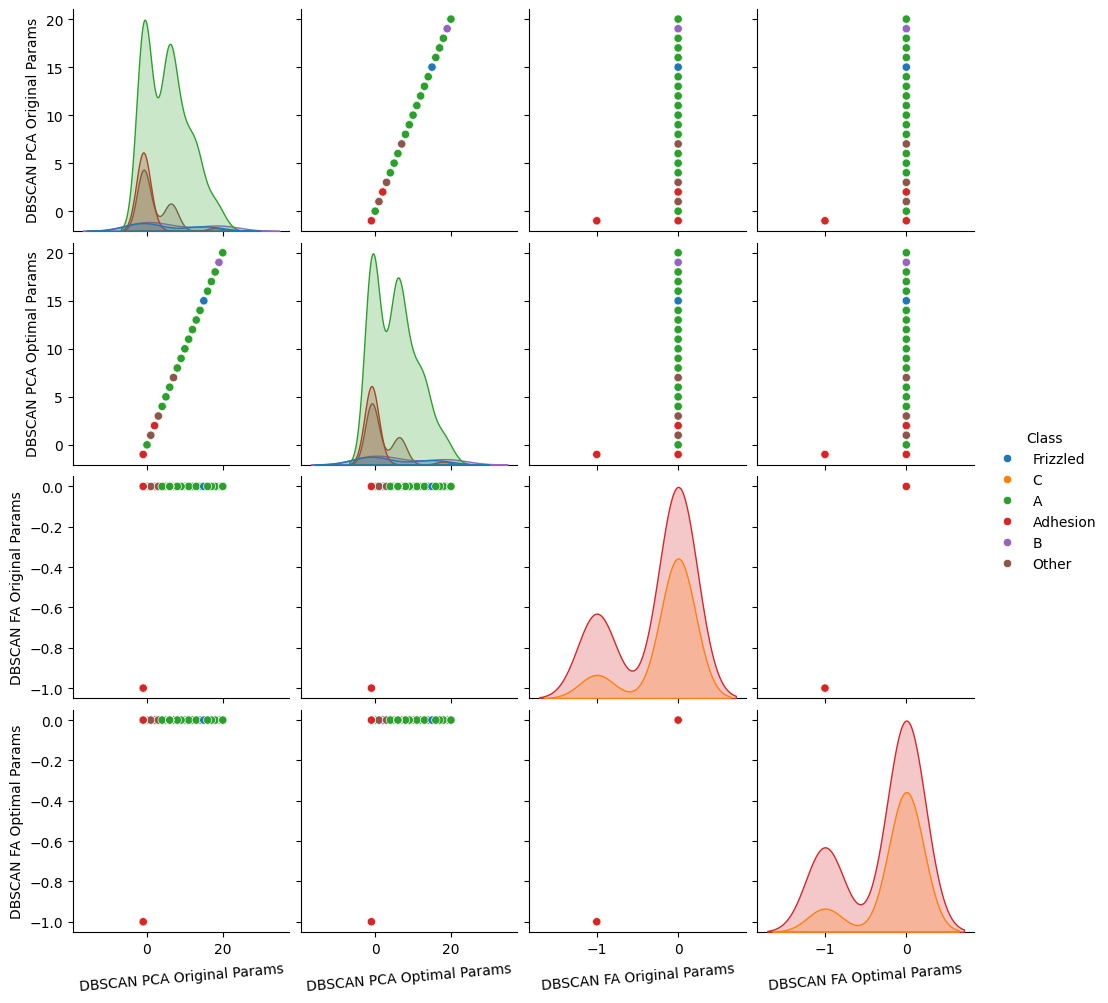

In [75]:
features = ['DBSCAN PCA Original Params', 'DBSCAN PCA Optimal Params', 'DBSCAN FA Original Params', 'DBSCAN FA Optimal Params', 'Class']
plt.figure(figsize=(6, 4))
pairplot = sns.pairplot(clustering_summary_training_data_final[features], hue='Class')
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=5)
plt.show()

<Figure size 600x400 with 0 Axes>

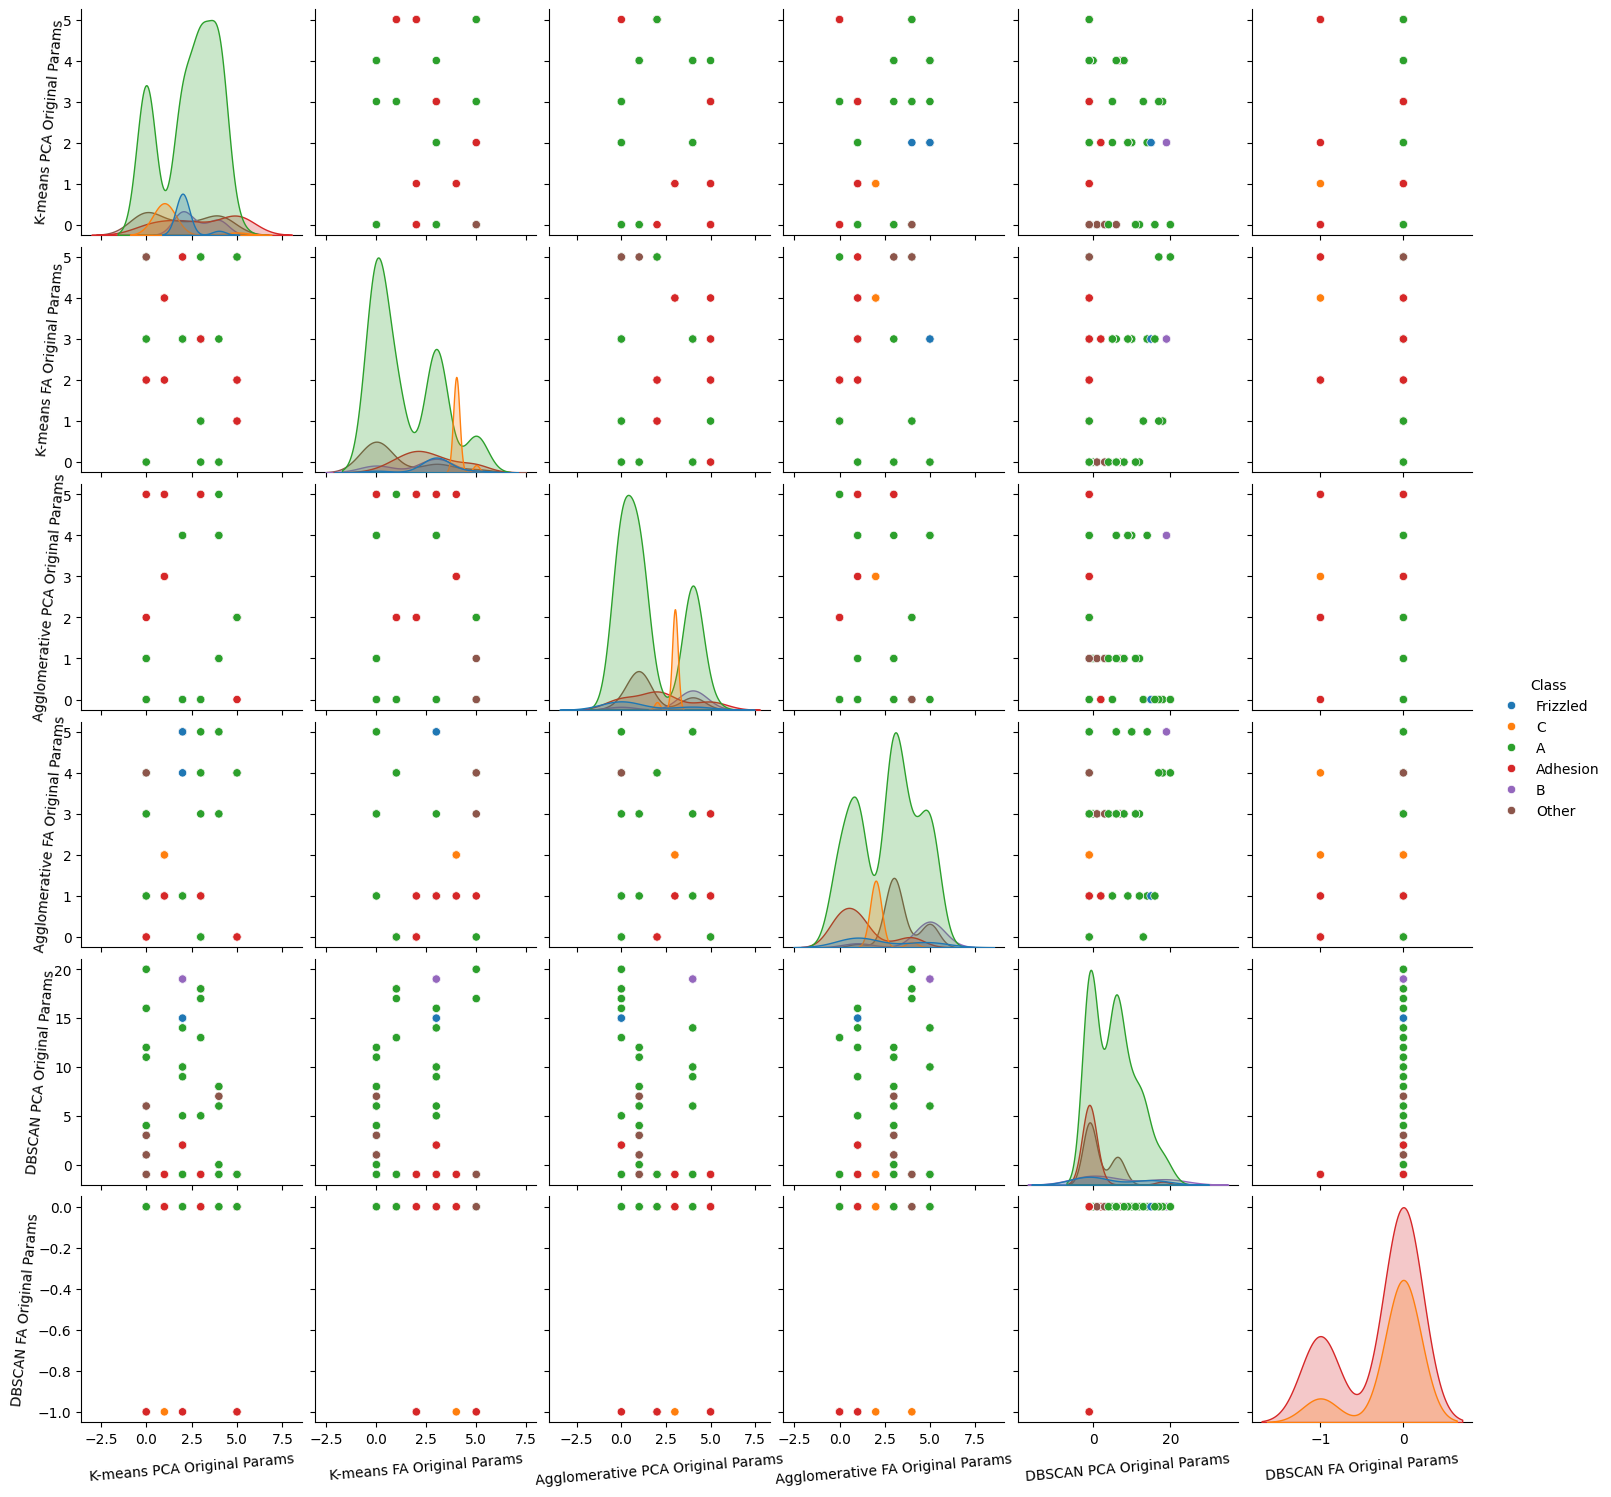

In [76]:
features = ['K-means PCA Original Params', 'K-means FA Original Params','Agglomerative PCA Original Params', 'Agglomerative FA Original Params', 'DBSCAN PCA Original Params', 'DBSCAN FA Original Params', 'Class']
plt.figure(figsize=(6, 4))
pairplot = sns.pairplot(clustering_summary_training_data_final[features], hue='Class')
for ax in pairplot.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), rotation=85)
    ax.set_xlabel(ax.get_xlabel(), rotation=5)
plt.show()

## Test Data

### Using Principal Components

In [77]:
kmeans_test_results_pca_new = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'K-means PCA Optimal Params': results_new_pca['kmeans_test']
})

agglo_test_results_pca_new = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'Agglomerative PCA Optimal Params': results_new_pca['hierarchical_test']
})

dbscan_test_results_pca_new = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'DBSCAN PCA Optimal Params': results_new_pca['dbscan_test']
})

In [78]:
kmeans_test_results_pca_orig = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'K-means PCA Original Params': results_orig_pca['kmeans_test']
})

agglo_test_results_pca_orig = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'Agglomerative PCA Original Params': results_orig_pca['hierarchical_test']
})

dbscan_test_results_pca_orig = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'DBSCAN PCA Original Params': results_orig_pca['dbscan_test']
})

### Using Factors

In [79]:
kmeans_test_results_fa_new = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'K-means FA Optimal Params': results_new_fa['kmeans_test']
})

agglo_test_results_fa_new = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'Agglomerative FA Optimal Params': results_new_fa['hierarchical_test']
})

dbscan_test_results_fa_new = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'DBSCAN FA Optimal Params': results_new_fa['dbscan_test']
})

In [80]:
kmeans_test_results_fa_orig = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'K-means FA Original Params': results_orig_fa['kmeans_test']
})

agglo_test_results_fa_orig = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'Agglomerative FA Original Params': results_orig_fa['hierarchical_test']
})

dbscan_test_results_fa_orig = pd.DataFrame({
    'protein': df_orphan_test_targets.index,
    'DBSCAN FA Original Params': results_new_fa['dbscan_test']
})

### Combined

In [81]:
clustering_summary_test_data = kmeans_test_results_pca_orig.merge(kmeans_test_results_pca_new, on='protein', how='outer') \
                               .merge(kmeans_test_results_fa_orig, on='protein', how='outer') \
                               .merge(kmeans_test_results_fa_new, on='protein', how='outer') \
                               .merge(agglo_test_results_pca_orig, on='protein', how='outer') \
                               .merge(agglo_test_results_pca_new, on='protein', how='outer') \
                               .merge(agglo_test_results_fa_orig, on='protein', how='outer') \
                               .merge(agglo_test_results_fa_new, on='protein', how='outer') \
                               .merge(dbscan_test_results_pca_orig, on='protein', how='outer') \
                               .merge(dbscan_test_results_pca_new, on='protein', how='outer') \
                               .merge(dbscan_test_results_fa_orig, on='protein', how='outer') \
                               .merge(dbscan_test_results_fa_new, on='protein', how='outer')

clustering_summary_test_data_final = pd.merge(clustering_summary_test_data, df_orphan_test_targets, left_on='protein', right_index=True)
clustering_summary_test_data_final

protein  K-means PCA Original Params  K-means PCA Optimal Params  \
0   O00155                            3                           0   
1   O00270                            0                           0   
2   O00398                            0                           0   
3   O14626                            0                           0   
4   O14804                            4                           0   
..     ...                          ...                         ...   
85  Q9UJ42                            3                           0   
86  Q9UNW8                            2                           0   
87  Q9UPC5                            3                           0   
88  Q9Y2T5                            2                           0   
89  Q9Y5Y3                            0                           0   

    K-means FA Original Params  K-means FA Optimal Params  \
0                            1                          1   
1                            0                          6   
2                            0                          0   
3                            0                          6   
4                            0                          0   
..                         ...                        ...   
85                           5                          5   
86                           3                          6   
87                           5                          5   
88                           3                          6   
89                           5                          5   

    Agglomerative PCA Original Params  Agglomerative PCA Optimal Params  \
0                                   0                                 0   
1                                   1                                 0   
2                                   1                                 0   
3                                   1                                 0   
4                                   2                                 0   
..                                ...                               ...   
85                                  0                                 0   
86                                  0                                 0   
87                                  0                                 0   
88                                  0                                 0   
89                                  0                                 0   

    Agglomerative FA Original Params  Agglomerative FA Optimal Params  \
0                                  0                                2   
1                                  3                                0   
2                                  3                                0   
3                                  3                                0   
4                                  5                                1   
..                               ...                              ...   
85                                 0                                2   
86                                 1                                0   
87                                 0                                2   
88                                 1                                0   
89                                 0                                2   

    DBSCAN PCA Original Params  DBSCAN PCA Optimal Params  \
0                           -1                         -1   
1                            0                          0   
2                            0                          0   
3                            0                          0   
4                           -1                         -1   
..                         ...                        ...   
85                          -1                         -1   
86                          -1                         -1   
87                          -1                         -1   
88                          -

### Pair Plots

<Figure size 600x400 with 0 Axes>

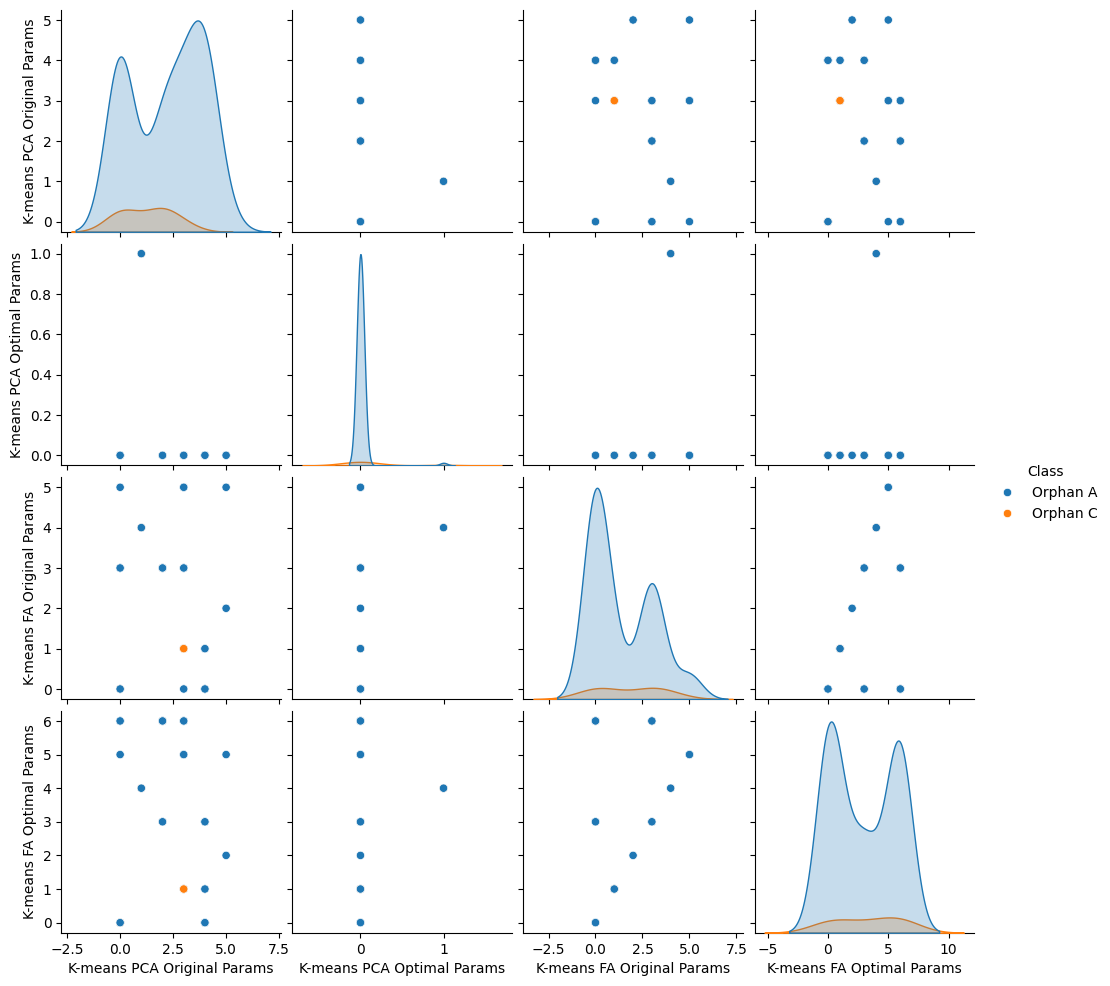

In [82]:
features = ['K-means PCA Original Params', 'K-means PCA Optimal Params', 'K-means FA Original Params', 'K-means FA Optimal Params', 'Class']
plt.figure(figsize=(6, 4))
sns.pairplot(clustering_summary_test_data_final[features], hue='Class')
plt.show()

<Figure size 600x400 with 0 Axes>

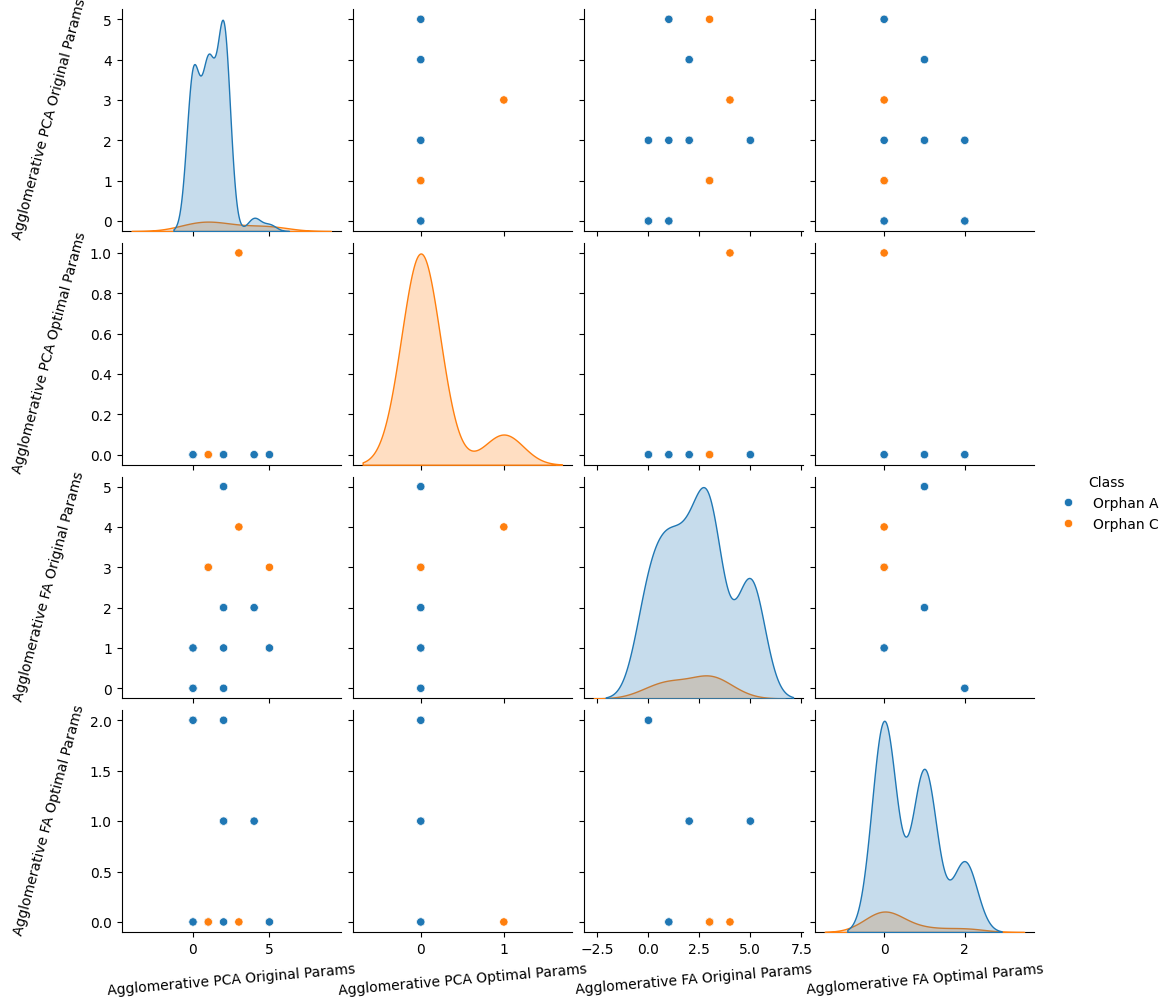

In [83]:
features = ['Agglomerative PCA Original Params', 'Agglomerative PCA Optimal Params', 'Agglomerative FA Original Params', 'Agglomerative FA Optimal Params', 'Class']
plt.figure(figsize=(6, 4))
pairplot = sns.pairplot(clustering_summary_test_data_final[features], hue='Class')
for ax in pairplot.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), rotation=75)
    ax.get_yaxis().set_label_coords(-0.3, 0.5)
    ax.set_xlabel(ax.get_xlabel(), rotation=5)
plt.show()

<Figure size 600x400 with 0 Axes>

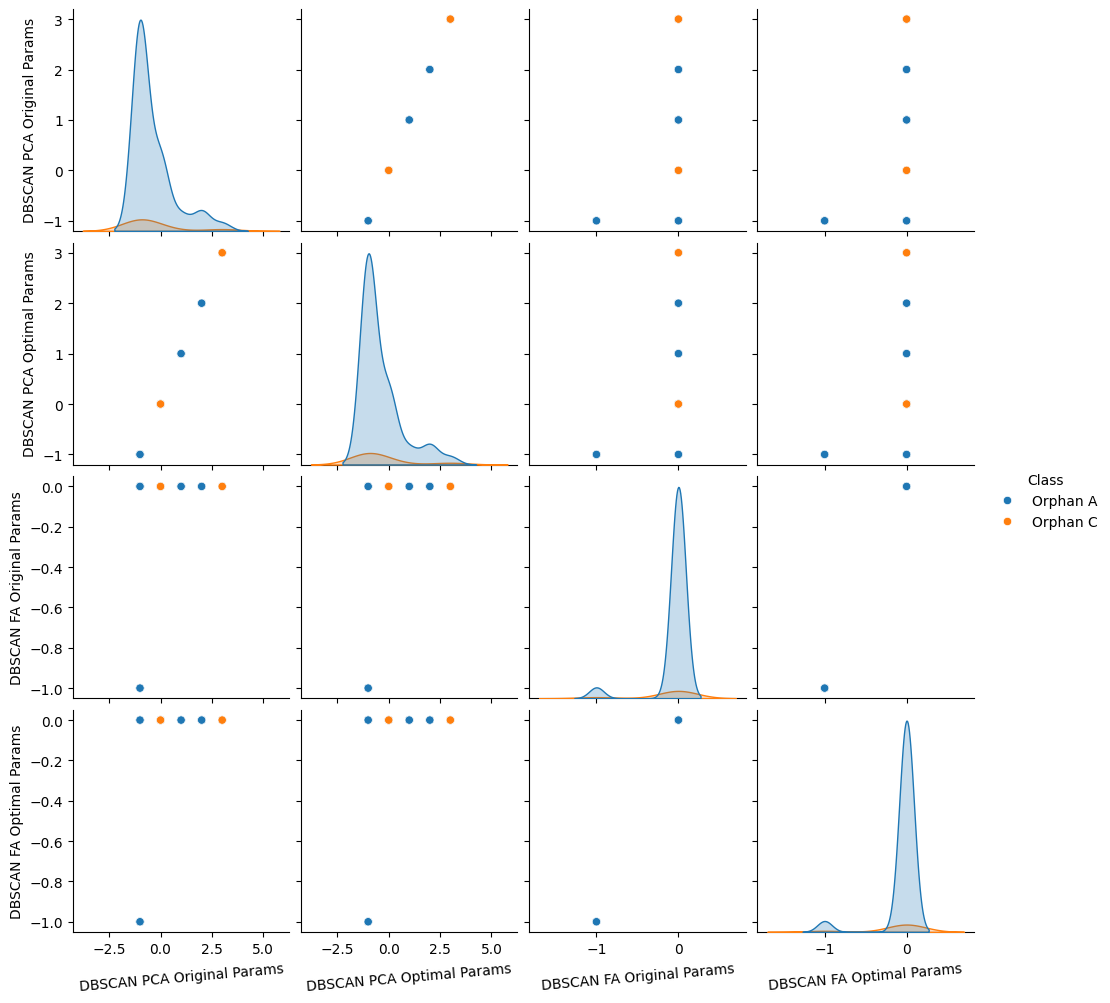

In [84]:
features = ['DBSCAN PCA Original Params', 'DBSCAN PCA Optimal Params', 'DBSCAN FA Original Params', 'DBSCAN FA Optimal Params', 'Class']
plt.figure(figsize=(6, 4))
pairplot = sns.pairplot(clustering_summary_test_data_final[features], hue='Class')
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=5)
plt.show()

<Figure size 600x400 with 0 Axes>

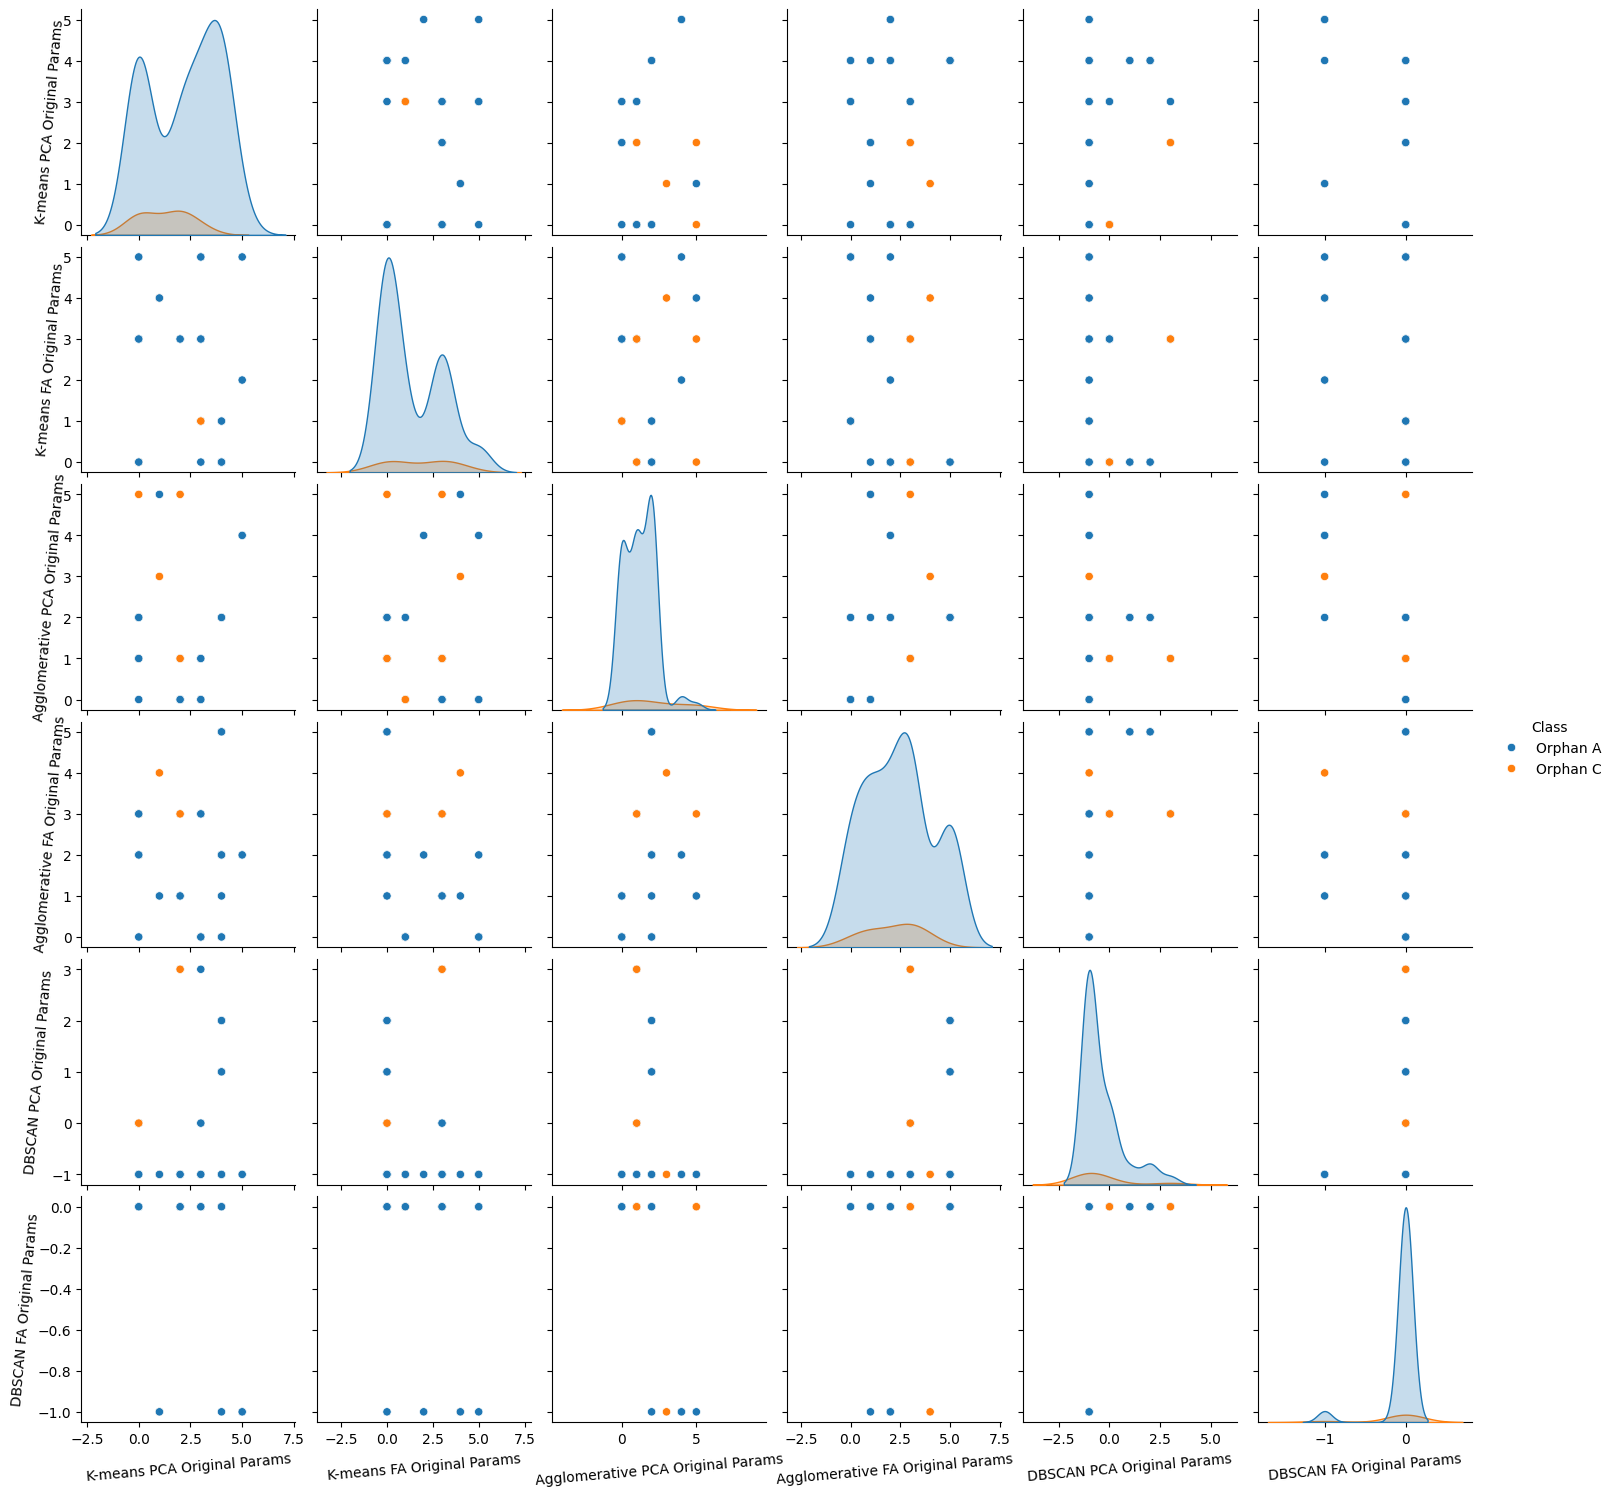

In [85]:
features = ['K-means PCA Original Params', 'K-means FA Original Params','Agglomerative PCA Original Params', 'Agglomerative FA Original Params', 'DBSCAN PCA Original Params', 'DBSCAN FA Original Params', 'Class']
plt.figure(figsize=(6, 4))
pairplot = sns.pairplot(clustering_summary_test_data_final[features], hue='Class')
for ax in pairplot.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), rotation=85)
    ax.set_xlabel(ax.get_xlabel(), rotation=5)
plt.show()

# References

- Weis, W. I., & Kobilka, B. K. (2008). Structural insights into G-protein-coupled receptor activation. Current opinion in structural biology, 18(6), 734–740. https://doi.org/10.1016/j.sbi.2008.09.010
- Kobilka B. K. (2007). G protein coupled receptor structure and activation. Biochimica et biophysica acta, 1768(4), 794–807. https://doi.org/10.1016/j.bbamem.2006.10.021
- Yang, D., Zhou, Q., Labroska, V. et al. G protein-coupled receptors: structure- and function-based drug discovery. Sig Transduct Target Ther 6, 7 (2021). https://doi.org/10.1038/s41392-020-00435-w
- Zhang, M., Chen, T., Lu, X. et al. G protein-coupled receptors (GPCRs): advances in structures, mechanisms and drug discovery. Sig Transduct Target Ther 9, 88 (2024). https://doi.org/10.1038/s41392-024-01803-6
- GPCR | Learn Science at SciTable. (n.d.). https://www.nature.com/scitable/topicpage/gpcr-14047471/
- Odoemelam, C. S., Percival, B., Wallis, H., Chang, M., Ahmad, Z., Scholey, D., Burton, E., Williams, I. H., Kamerlin, C. L., & Wilson, P. B. (2020). G-Protein coupled receptors: structure and function in drug discovery. RSC Advances, 10(60), 36337–36348. https://doi.org/10.1039/d0ra08003a
- Liu, S., Anderson, P. J., Rajagopal, S., Lefkowitz, R. J., & Rockman, H. A. (2024). G Protein-Coupled Receptors: A century of research and Discovery. Circulation Research, 135(1), 174–197. https://doi.org/10.1161/circresaha.124.323067
- Insel, P. A., Sriram, K., Gorr, M. W., Wiley, S. Z., Michkov, A., Salmerón, C., Chinn, A. M. (2019). GPCRomics: An approach to discover GPCR drug targets. Trends in Pharmacological Sciences, 40(6), 378-387. https://doi.org/10.1016/j.tips.2019.04.001
- Sriram, K., & Insel, P. A. (2018). G Protein-Coupled Receptors as Targets for Approved Drugs: How Many Targets and How Many Drugs?. Molecular pharmacology, 93(4), 251–258. https://doi.org/10.1124/mol.117.111062
- Singh, N., Pydi, S. P., Upadhyaya, J., & Chelikani, P. (2011). Structural basis of activation of bitter taste receptor T2R1 and comparison with Class A G-protein-coupled receptors (GPCRs). The Journal of biological chemistry, 286(41), 36032–36041. https://doi.org/10.1074/jbc.M111.246983